# FX MMN paper

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import scipy.stats as sstat
import scipy.signal as ssig
import h5py
from mpl_toolkits.mplot3d import Axes3D
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA as sklearnPCA
import re
import ephys_unit_analysis as ena
import fnmatch
# from PyPDF2 import PdfFileMerger, PdfFileReader
import seaborn as sns
%matplotlib inline
mpl.rcParams['pdf.fonttype'] = 42 
mpl.rcParams['font.sans-serif']=['Arial', 'Helvetica','Bitstream Vera Sans', 'DejaVu Sans', 'Lucida Grande', 
                                 'Verdana', 'Geneva', 'Lucid', 'Avant Garde', 'sans-serif']  

%load_ext autoreload
%autoreload 2
# pal=sns.blend_palette(["black", "crimson"], 2)
sns.despine()
# current_palette = sns.color_palette("colorblind", 10)
# sns.set_palette(current_palette)

# for publication quality plots, not bar graphs, use this: 
def set_pub_plots(pal=sns.blend_palette(["gray","crimson", 'cyan', 'magenta', 'purple'  ],5)):
    sns.set_style("white")
    sns.set_palette(pal)
    sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5, "axes.linewidth":2.5, 'figure.facecolor': 'white'}) 
    sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
    # optional, makes markers bigger, too, axes.linewidth doesn't seem to work
    plt.rcParams['axes.linewidth'] = 2.5

rc_pub={'font.size': 25, 'axes.labelsize': 25, 'legend.fontsize': 25.0, 
    'axes.titlesize': 25, 'xtick.labelsize': 25, 'ytick.labelsize': 25, 
    #'axes.color_cycle':pal, # image.cmap - rewritesd the default colormap
    'axes.linewidth':2.5, 'lines.linewidth': 2.5,
    'xtick.color': 'black', 'ytick.color': 'black', 'axes.edgecolor': 'black','axes.labelcolor':'black','text.color':'black'}
# to restore the defaults, call plt.rcdefaults() 

#set_pub_bargraphs()
set_pub_plots()



#%matplotlib notebook

C:\Users\Chub_lab\Anaconda2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


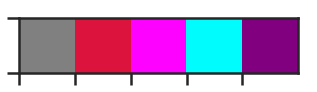

In [2]:
pal=sns.blend_palette(["gray","crimson", 'magenta','cyan',  'purple'  ],5)
sns.palplot(pal)
sns.set_palette(pal)
groups = {'479': 'wt', '480': 'fx', '481':'fx', '482': 'fx', '483': 'wt', '484': 'wt', '485':'wt', '486':'fx', 
          '013': 'wt', '014': 'fx', '016': 'fx', '017': 'wt', '018': 'fx', '019': 'wt', '020': 'wt', '022': 'fx',
         '023': 'wt', '024': 'fx', '025': 'fx', '026': 'fx', '027': 'fx', '028': 'fx', '029': 'wt', '030': 'fx', '031': 'fx', '032': 'fx', 
          '033': 'fx' , '034': 'fx', '035': 'wt', 'W00': 'wt', 'W01': 'wt',
 'W02': 'wt', 'W03': 'wt', 'W04': 'wt', 'W05':'wt'}

In [3]:
probe = '64DB'
oddball = ena.get_paradigm('glob_oddball')
omission = ena.get_paradigm('exp_omission')
sf_tuning = ena.get_paradigm('sf-tuning')
d_odd_stim = {}
d_odd_opto = {}
d_tun_stim = {}
d_tun_opto = {}
oddball_opto_seq = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0])


oddball_opto_idx = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

sf_tuning_opto_seq = np.array([4, 4, 3, 5, 0, 5, 3, 1, 2, 3, 5, 3, 0, 1, 0, 3, 2, 4, 5, 5, 0, 0,
       5, 1, 3, 4, 4, 4, 5, 1, 2, 1, 4, 5, 3, 1, 4, 0, 0, 3, 0, 2, 0, 1,
       3, 1, 0, 5, 5, 2, 1, 1, 1, 4, 4, 1, 5, 0, 5, 3, 1, 3, 0, 3, 0, 3,
       3, 2, 4, 1, 5, 2, 5, 3, 5, 5, 0, 0, 3, 5, 4, 3, 0, 2, 1, 5, 0, 4,
       5, 0, 3, 2, 3, 4, 5, 0, 4, 0, 2, 2, 4, 3, 5, 4, 1, 2, 1, 1, 2, 3,
       2, 2, 0, 3, 0, 1, 2, 5, 2, 3, 0, 1, 3, 4, 0, 2, 2, 2, 0, 5, 4, 2,
       3, 2, 3, 3, 4, 0, 4, 3, 3, 1, 5, 2, 0, 2, 5, 3, 2, 5, 5, 4, 1, 3,
       4, 3, 1, 0, 2, 2, 5, 4, 1, 3, 1, 1, 4, 4, 1, 5, 3, 3, 5, 4, 3, 3,
       1, 0, 2, 4, 1, 5, 1, 3, 5, 1, 1, 1, 4, 2, 3, 0, 0, 1, 1, 1, 3, 2,
       1, 4, 4, 3, 2, 3, 4, 5, 4, 5, 3, 1, 2, 1, 2, 2, 0, 5, 0, 2, 4, 4,
       2, 5, 4, 0, 5, 0, 4, 4, 3, 0, 2, 5, 5, 3, 0, 4, 1, 3, 0, 0, 1, 2,
       2, 5, 1, 4, 3, 0, 0, 5, 4, 4, 1, 0, 4, 2, 2, 4, 5, 1, 5, 0, 5, 2,
       2, 0, 2, 2, 2, 0, 1, 4, 4, 1, 5, 4, 4, 0, 2, 5, 5, 0, 0, 1, 3, 0,
       1, 3, 5, 5, 4, 1, 0, 2, 2, 2, 3, 5, 1, 4])

sf_tuning_opto_idx = np.array([0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0])

for i, v in enumerate(oddball_opto_seq):
    d_odd_stim[i] = v 
for i, v in enumerate(oddball_opto_idx):
    d_odd_opto[i] = v 
for i, v in enumerate(sf_tuning_opto_seq):
    d_tun_stim[i] = v 
for i, v in enumerate(sf_tuning_opto_idx):
    d_tun_opto[i] = v 

channel_groups = ena.get_channel_depth(probe)
odd_idx = np.where(np.array(oddball.values())==9)
omis_idx = np.where(np.array(omission.values())==2)
ch_map = ena.get_channel_depth(probe)

In [11]:
colors_stim = ['gray', 'crimson', 'green']
colors_group = ['k', 'coral']

In [5]:
matches = [] # list of experiment folders
source_folder = r"U:\Data\pak6\OpenEphys\probe_64DB\PV_Ai32\vmmn-LMopto\left1"
for root, dirnames, filenames in os.walk(source_folder):
    for dirname in fnmatch.filter(dirnames, '*conc'):
        if 'atch' in dirname or 'bad' in dirname:
            continue
        matches.append(os.path.join(root, dirname)) 
print matches[:5]
print len(matches)

KeyboardInterrupt: 

In [1]:
for path in matches[:]:

    et = path.split('\\')[-2].split()[0]
    print et

NameError: name 'matches' is not defined

## Generate psth

In [328]:
#Receptive field mapping
ls_psth = []
ls_spikes = []
ls_tmt = []

for path in matches[:]:
    df = 0
    if 'bad' in path or 'opto4' in path:
        continue
    print path
    et = path.split('\\')[-2].split()[0]
    side = 'left-1'
    path_cluster_groups = os.path.join(path, 'cluster_groups.csv')
    cluster_groups = pd.read_csv(path_cluster_groups, sep = '\t')
    # good_units = cluster_groups[cluster_groups.group != 'noise'].cluster_id.values
    noise_units = cluster_groups[cluster_groups['group'] == 'noise'].cluster_id.values
    spike_times = np.load(os.path.join(path, 'spike_times.npy'))
    spike_clusters = np.load(os.path.join(path, 'spike_clusters.npy'))
    templates = np.load(os.path.join(path, 'templates.npy'))
    spike_templates = np.load(os.path.join(path, 'spike_templates.npy'))
    df = pd.DataFrame({'times':spike_times.flatten()/30000.0, 
                       'unit_id':spike_clusters.flatten(), 
                       'templates':spike_templates.flatten() })

    df = df[~df.unit_id.isin(noise_units)]
    df.loc[:,'et'] = et
    df.loc[:,'side'] = side
    df.loc[:,'cluster_id'] = df.loc[:,'unit_id'].astype('str') + 'et' + df.loc[:,'et'] + df.loc[:,'side']
    df.loc[:,'path'] = path
#     df.loc[:,'trial_n'] = df.loc[:,'times']//1.0

    ls_spikes.append(df)

# df_tmt = pd.concat(ls_tmt)
df_spikes = pd.concat(ls_spikes)

# master_kic.head()

U:\Data\pak6\OpenEphys\probe_64DB\PV_Ai32\vmmn-LMopto\left1\PvLMopto1\conc
U:\Data\pak6\OpenEphys\probe_64DB\PV_Ai32\vmmn-LMopto\left1\PvLMopto3\conc
U:\Data\pak6\OpenEphys\probe_64DB\PV_Ai32\vmmn-LMopto\left1\PvLMopto2\conc


In [329]:
df_spikes.head()

templates     times  unit_id         et    side            cluster_id  \
0         40  0.003467       40  PvLMopto1  left-1   40etPvLMopto1left-1   
2        219  0.007033      219  PvLMopto1  left-1  219etPvLMopto1left-1   
4        107  0.008700      107  PvLMopto1  left-1  107etPvLMopto1left-1   
5        104  0.010633      104  PvLMopto1  left-1  104etPvLMopto1left-1   
6         47  0.013167       47  PvLMopto1  left-1   47etPvLMopto1left-1   

                                                path  
0  U:\Data\pak6\OpenEphys\probe_64DB\PV_Ai32\vmmn...  
2  U:\Data\pak6\OpenEphys\probe_64DB\PV_Ai32\vmmn...  
4  U:\Data\pak6\OpenEphys\probe_64DB\PV_Ai32\vmmn...  
5  U:\Data\pak6\OpenEphys\probe_64DB\PV_Ai32\vmmn...  
6  U:\Data\pak6\OpenEphys\probe_64DB\PV_Ai32\vmmn...

In [273]:
df_spikes.to_pickle('fx_var-odd_spikes_12-18-18.pkl')

In [330]:
tmp = df_spikes

df1 = tmp[(tmp.loc[:, 'times'] < 20)] #sf-tuning
df1.loc[:, 'trial_n'] = df1.loc[:, 'times'] //1.0
df1.loc[:,'stim1'] = ['G-1']

df2 = tmp[(tmp.loc[:, 'times'] > 20) & (tmp.loc[:, 'times'] < 40)] #sf-tuning
df2.times = df2.times - 20
df2.loc[:, 'trial_n'] = df2.loc[:, 'times'] //1.0
df2.loc[:,'stim1'] = ['G-1-opto-g01']

# df3 = tmp[(tmp.loc[:, 'times'] > 40) & (tmp.loc[:, 'times'] < 60)] #sf-tuning
# df3.times = df3.times - 40
# df3.loc[:, 'trial_n'] = df3.loc[:, 'times'] //1.0
# df3.loc[:,'stim1'] = ['LM-G-1-opto-g05']

# df4 = tmp[(tmp.loc[:, 'times'] > 60) & (tmp.loc[:, 'times'] < 80)] #sf-tuning
# df4.times = df4.times - 60
# df4.loc[:, 'trial_n'] = df4.loc[:, 'times'] //1.0
# df4.loc[:,'stim1'] = ['LM-G-1-opto-g075']

df3 = tmp[(tmp.loc[:, 'times'] > 40) & (tmp.loc[:, 'times'] < 340)] #sf-tuning
df3.times = df3.times - 40
df3.loc[:, 'trial_n'] = df3.loc[:, 'times'] //1
df3.loc[:,'stim1'] = df3.loc[:, 'trial_n'].map(d_tun_stim)
df3.loc[:,'opto'] = df3.loc[:, 'trial_n'].map(d_tun_opto)

df4 = tmp[(tmp.loc[:, 'times'] > 340)] #sf-nov-odd
df4.times = df4.times - 340
df4.loc[:, 'trial_n'] = df4.loc[:, 'times'] //1
df4.loc[:,'stim1'] = df4.loc[:, 'trial_n'].map(d_odd_stim)
df4.loc[:,'opto'] = df4.loc[:, 'trial_n'].map(d_odd_opto)

# df4 = df_spikes[(df_spikes.loc[:, 'times'] >= 320) ] #sf-nov-odd
# df4.times = df4.times - 320
# df4.loc[:, 'trial_n'] = df4.loc[:, 'times'] //1.0
# df4.loc[:,'stim1'] = df4.loc[:, 'trial_n'].map(omission)

# df4 = df_spikes[ (df_spikes.loc[:, 'times'] > 320) & (df_spikes.loc[:, 'times'] < 360) ] # opto ramp
# df4.loc[:, 'times'] = df4.loc[:, 'times'] - 320
# df4['stim1'] = 'ramp_on'
# df4.loc[:, 'trial_n'] = df4.loc[:, 'times'] //2.0

# df5 = df_spikes[ (df_spikes.loc[:, 'times'] > 360) ] # opto chirp
# df5.loc[:, 'times'] = df5.loc[:, 'times'] - 320
# df5['stim1'] = 'chirp'
# df5.loc[:, 'trial_n'] = df5.loc[:, 'times'] //8.0


In [13]:
df3.trial_n.unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [331]:
d_psth = {}

In [333]:
#generate psth for vmmn data
trial_length = 1.0
th_bin = 0.01
trials_number = 25.0
ls_psth = []
ls_tmt = []

data = df4
# data['opto'] = 1
paradigm = 'sf-oddball-LMopto-g01'
stim_type = 'ctr'

for opto in data.opto.unique():
    tmp = data[data.opto == opto]
    for idx_stim1, stim1 in enumerate(sorted(tmp['stim1'].unique())):
        print stim1
        trials_to_incl = np.arange(400)
        tmp2 = tmp[ (tmp.stim1 == stim1)]
        if 'odd' in paradigm or 'omis' in paradigm:
            odd_trials = tmp[tmp.stim1 == 1].trial_n.unique()
            if stim1 == 1:
                stim_type = 'dev'
                idx_stim1 = 1
            elif stim1 == 0:
                stim_type = 'std'
                trials_to_incl = odd_trials - 1 # pre oddball trials
                idx_stim1 = 0
            elif stim1 == 40:
                stim_type = 'omis'
                trials_to_incl = omis_idx[0] - 1 # pre oddball trials
                idx_stim1 = 0
        for unit in tmp2['cluster_id'].unique():
            tmp3 = tmp2[(tmp2.cluster_id == unit)]
            tmp3 = tmp3[(tmp3.trial_n.isin(trials_to_incl))] 
#             print tmp3.shape
            if tmp3.shape[0] < 1:
                continue
            et = tmp3.et.unique()[0]
            side = tmp3.side.unique()[0]
            path = tmp3.path.unique()[0]
            try:
                tmt, depth, ch_idx = ena.ksort_get_tmt(tmp3, unit, templates, channel_groups)
            except:
                depth = np.nan
            cuid =  str(unit) + 'et' + str(et) + str(stim1) + str(paradigm)
            
            df = ena.getRaster_kilosort(tmp3, unit, trial_length) 
            # check the reliability of the neuron, spike in 0.8 of trials
            if df.trial.unique().size < 0.8*trials_number:
                continue
            h, ttr = ena.PSTH(df.times, th_bin, trial_length, trials_number) # all times rescaled to 0-4 this is why trias number 1.0
            zscore = sstat.mstats.zscore(h)
            mean = np.mean(h[:30])
            std = np.std(h[:30])
            if mean==0:
                std=1
            ztc = (h - mean)/std

            df_psth_tmp = pd.DataFrame({     'times':ttr,    'Hz':h,      'cuid': cuid, 'depth':depth,  
                                        'path': path, 'stim1': stim_type + str(stim1), 'side': side,
                               'abs_times': idx_stim1*trial_length+ttr, 'paradigm':paradigm, 'opto': opto,
                                    'zscore':zscore, 'ztc':ztc,  'et': et, 'cluster_id': unit  })

            ls_psth.append(df_psth_tmp)
#         df_tmt_tmp = pd.DataFrame({'tmt':tmt,  'cluster_id' : unit,  'depth': depth, 'path': path })
#         ls_tmt.append(df_tmt_tmp)
#     break
d_psth[paradigm] = pd.concat(ls_psth)
# df_tmt = pd.concat(ls_tmt)

0
1
0
1


In [25]:
tmp3.templates.unique()

array([254], dtype=uint64)

In [334]:
print d_psth[paradigm].shape
print d_psth[paradigm].stim1.unique()
print d_psth[paradigm].cluster_id.unique().size

(55600, 14)
['std0' 'dev1']
190


In [335]:
df_vmmn2 = pd.concat(d_psth.values()).reset_index(drop = True)

In [289]:
df_vmmn['group'] =  df_vmmn.et.map(groups)
print df_vmmn2['group'].unique()

['wt' 'fx']


In [336]:
df_vmmn2.groupby([ 'et', 'side']).path.unique()

et         side  
PvLMopto1  left-1    [U:\Data\pak6\OpenEphys\probe_64DB\PV_Ai32\vmm...
PvLMopto2  left-1    [U:\Data\pak6\OpenEphys\probe_64DB\PV_Ai32\vmm...
PvLMopto3  left-1    [U:\Data\pak6\OpenEphys\probe_64DB\PV_Ai32\vmm...
Name: path, dtype: object

In [398]:
the_sine[0]

array([ 1.22464680e-15,  5.92907929e-01,  9.54902241e-01,  9.45000819e-01,
        5.67059864e-01, -3.17279335e-02, -6.18158986e-01, -9.63842159e-01,
       -9.34147860e-01, -5.40640817e-01,  6.34239197e-02,  6.42787610e-01,
        9.71811568e-01,  9.22354294e-01,  5.13677392e-01, -9.50560433e-02,
       -6.66769001e-01, -9.78802446e-01, -9.09631995e-01, -4.86196736e-01,
        1.26592454e-01,  6.90079011e-01,  9.84807753e-01,  8.95993774e-01,
        4.58226522e-01, -1.58001396e-01, -7.12694171e-01, -9.89821442e-01,
       -8.81453363e-01, -4.29794912e-01,  1.89251244e-01,  7.34591709e-01,
        9.93838464e-01,  8.66025404e-01,  4.00930535e-01, -2.20310533e-01,
       -7.55749574e-01, -9.96854776e-01, -8.49725430e-01, -3.71662456e-01,
        2.51147987e-01,  7.76146464e-01,  9.98867339e-01,  8.32569855e-01,
        3.42020143e-01, -2.81732557e-01, -7.95761841e-01, -9.99874128e-01,
       -8.14575952e-01, -3.12033446e-01,  3.12033446e-01,  8.14575952e-01,
        9.99874128e-01,  

In [337]:
df_vmmn = df_vmmn.append(df_vmmn2)

In [4]:
path = r"U:\Data_Analysis\pak6\Analysis of units\FX mmn paper\fx-mmn-paper_master_spikes.pkl"
df_spikes = pd.read_pickle(path)
path = r"U:\Data_Analysis\pak6\Analysis of units\FX mmn paper\fx-mmn-paper_master_tmt.pkl"
df_tmt = pd.read_pickle(path)
path = r"U:\Data_Analysis\pak6\Analysis of units\FX mmn paper\fx-mmn-paper_master_psth.pkl"
df_vmmn = pd.read_pickle(path)

In [5]:
df_vmmn.groupby(['group', 'et', 'side']).path.unique()

group  et   side   
fx     014  left-2     [U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-o...
            right-1    [U:\Data\pak6\OpenEphys\probe_64DA\FX\sf-nov-v...
       016  left-2     [U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-o...
            right-1    [U:\Data\pak6\OpenEphys\probe_64DA\FX\sf-nov-v...
       022  left-2     [U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-o...
       024  left-2     [U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-o...
       026  left-1     [U:\Data\skissing\WT vs Fragile X\2018.12.18 V...
       027  left-1     [U:\Data\skissing\WT vs Fragile X\2018.12.18 V...
       028  left-1     [U:\Data\skissing\WT vs Fragile X\2018.12.18 V...
       030  left-1     [U:\Data\skissing\WT vs Fragile X\2018.12.18 V...
       031  left-1     [U:\Data\skissing\WT vs Fragile X\2018.12.18 V...
       033  left-1     [U:\Data\skissing\WT vs Fragile X\2018.12.18 V...
       480  left       [U:\Data\pak6\OpenEphys\probe_64DB\Thy1_FX\sf-...
            right      [U:\Data

In [165]:
# d_psth['sf_tuning'].loc[:, 'times'] = d_psth['sf_tuning'].loc[:, 'times'] - 0.04
d_psth['G-1-LMopto-g01'].loc[:, 'abs_times'] = d_psth['G-1-LMopto-g01'].loc[:, 'abs_times'] + 1

In [6]:
conditions = [
    (df_vmmn['depth'] <= 600) & (df_vmmn['depth'] >= 400),
    (df_vmmn['depth'] < 400) ,
    (df_vmmn['depth'] > 600)]
choices = ['l4', 'l5/6', 'l2/3']
df_vmmn['layer'] = np.select(conditions, choices)

In [7]:
df_vmmn.paradigm.unique()

array(['sf_tuning', 'sf_loc_omis', 'sf_nov_odd', 'opto_ramp',
       'opto_chirp'], dtype=object)

In [8]:
def get_opto_resp(tmp):
    base_fr = tmp[(tmp.times > 0.05) & (tmp.times < 0.55) ].Hz.values
    opto_fr = tmp[(tmp.times > 1.05) & (tmp.times < 1.55) ].Hz.values
    exc_inh = np.mean(opto_fr) - np.mean(base_fr)
    p_resp = sstat.wilcoxon(opto_fr, base_fr)
    if p_resp[1] < 0.05:
        if exc_inh > 0:
            tmp['resp_sig'] = 'exc'
        else:
            tmp['resp_sig'] = 'inh'
    else:
        tmp['resp_sig'] = 'ns'
    return tmp

In [43]:
def get_mmn_idx(data, val = 'Hz' ):
# data = tmp_3km[(tmp_3km.times > 0.1)
#               & (tmp_3km.r_groups < 5)    
#              ]
# val = 'ztc'
# for unit in data.cluster_id.unique()[::50]:
#     tmp = data[(data.cluster_id == unit)]
    
#     tmp.loc[:,'norm_fr'] = tmp.groupby('stim1').Hz.apply(lambda x: (x - min(x)) / (max(x) - min(x)))
    tmp = data
#     rg = tmp.r_groups.unique()[0]

    sf_pref = tmp.pref.unique()[0]

    base_fr = tmp[(tmp.times > 0.05) & (tmp.times < 0.3) & (tmp.stim1.str.contains('dev'))].Hz.values
    dev_fr = tmp[(tmp.times > 0.35) & (tmp.times < 0.6) & (tmp.stim1.str.contains('dev'))].Hz.values
    exc_inh = np.mean(dev_fr) - np.mean(base_fr)
    p_resp = sstat.wilcoxon(dev_fr, base_fr)
    if p_resp[1] < 0.05:
        if exc_inh > 0:
            data['resp_sig'] = 'exc'
        else:
            data['resp_sig'] = 'inh'
    else:
        data['resp_sig'] = 'ns'
        
    base = tmp[(tmp.times > 0)
              & (tmp.times < 0.3)]   
    
    std_base = base[base.stim1.str.contains('std')][val].values
    dev_base = base[base.stim1.str.contains('dev')][val].values
    ctr_base = base[base.stim1 == 'ctr2'][val].values.mean()
    
    tmp2 = tmp[(tmp.times > 0.35)
              & (tmp.times < 0.8)]
    std = tmp2[tmp2.stim1.str.contains('std')][val].values
    dev = tmp2[tmp2.stim1.str.contains('dev')][val].values
    ctr = tmp2[tmp2.stim1 == 'ctr2'][val].values

    std_area = (np.mean(std)) - np.mean(std_base)
    dev_area = (np.mean(dev)) - np.mean(dev_base)
    ctr_area = (np.mean(ctr)) - np.mean(ctr_base)

#     std_area = np.trapz(std - np.mean(std_base))
#     dev_area = np.trapz(dev - np.mean(dev_base))
#     ctr_area = np.trapz(ctr - np.mean(ctr_base))
    
    my_list1 = [std_area, dev_area, ctr_area]
    
    if all(i > 0 for i in my_list1) or all(i < 0 for i in my_list1):
        ssa = (ctr_area - std_area) / (ctr_area + std_area)
        dd = (dev_area - ctr_area) / (dev_area + ctr_area)
        mm = (dev_area - std_area) / (dev_area + std_area)
#         if sf_pref == 'ctr2' or sf_pref == 2:
#             dd = (dev_area - std_area) / (dev_area + std_area)
        
        data.loc[:,'ssa_hz'] = ssa
        data.loc[:,'dd_hz'] = dd
        data.loc[:,'mm_hz'] = mm
        
    if all(i < 0 for i in my_list1):
        data.loc[:, 'resp_sig'] = 'inh'
    return data
#     print ssa, dd
#     plt.plot(tmp[tmp.stim1 == 'ctr2'].times.values, tmp[tmp.stim1 == 'ctr2'].ztc.values,  '.b')
#     plt.plot(tmp[tmp.stim1 == 'dev9'].times.values, tmp[tmp.stim1 == 'dev9'].ztc.values,   '.r')
#     plt.plot(tmp[tmp.stim1 == 'std3'].times.values, tmp[tmp.stim1 == 'std3'].ztc.values,   '.g')
#     plt.axvline(x = 0.3)
#     plt.show()

'layer'

[Text(68,0.5,u'1879'), Text(0.5,57.5,u'')]

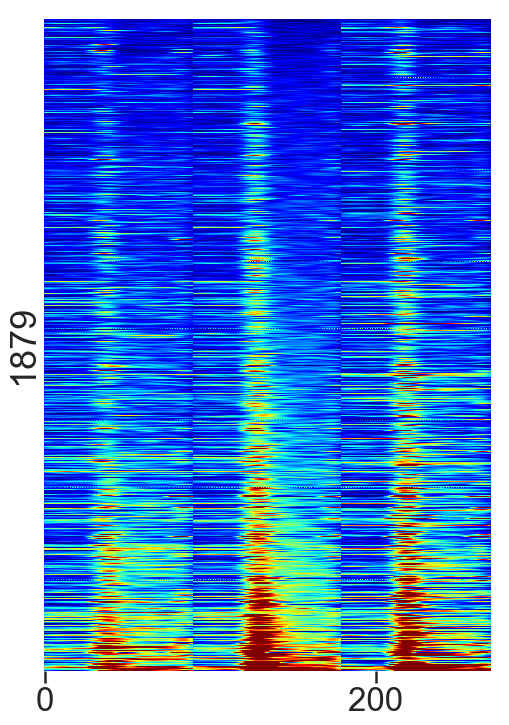

In [9]:
# %matplotlib notebook
f, ax = plt.subplots(figsize = (8, 12), facecolor = 'w')
idx = 13
_data = df_vmmn
high_ztc_units = _data[_data.ztc > 400].cluster_id.unique()

# print recs[idx]

data = _data[(_data.paradigm.str.contains('odd') )
              | (_data.stim1.str.contains('ctr2')) 
#                 | (_data.stim1.str.contains('std')) 
#                 & (_data.layer == 'l2/3')
               ]  

# data = _data[ (_data.paradigm.str.contains('odd')) | (_data.stim1.str.contains('ctr2'))]
# data = _data[ (_data.paradigm.str.contains('chirp')) ]
# opto0_units = data[data.opto == 0].cluster_id.unique()
# data = data[(data.layer == 'l5/6')]
data = data[~(data.cluster_id.isin(high_ztc_units))]
# units_include = df_vmmn[df_vmmn.paradigm.str.contains('tuning')].cluster_id.unique()
# data = data[data.cluster_id.isin(units_include)]

data = data.dropna()

# data = data[data.cluster_id.isin(result[result.n_type != 'un'].cluster_id.unique())]
data = data[ (data.times >= 0.05) & (data.times < 0.95)]
# data = data.sort_values(by = ['stim1'])
hm = data.pivot('cluster_id', 'abs_times', 'Hz')
hm = hm.dropna()
good_units = hm.index.values
hm2 = hm.values[ np.argsort(np.mean(hm.values[:,130:180], axis = 1) )]

sns.heatmap(hm2, cmap = 'jet',  annot=False, xticklabels = 200, vmax = 30,
            vmin = 0, robust = True, yticklabels=False, ax = ax, cbar = False )
ax.set(xlabel='', ylabel= hm.shape[0])
# plt.savefig('hm-fx_all_units_std-dev-ctr.png')

No handlers could be found for logger "matplotlib.legend"


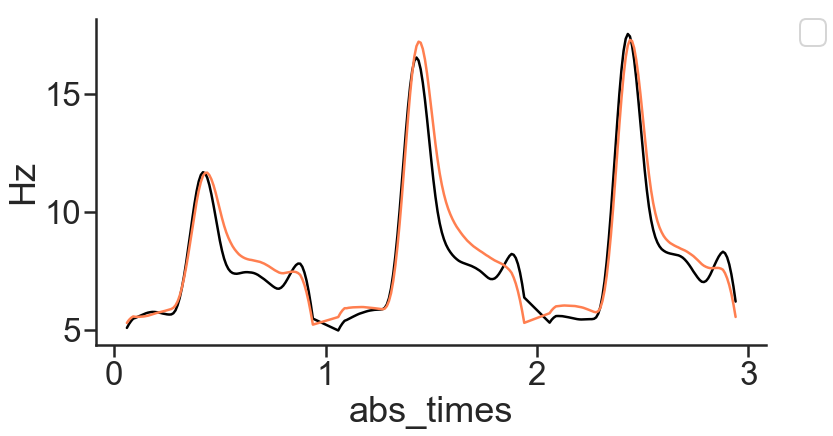

In [12]:
zsc = 'Hz'

fig, ax = plt.subplots(figsize= (12,6))
# data = _data[ (_data.paradigm == 'sf_tuning') & (_data.cluster_id.isin(good_units)) ]
# data = _data[ (_data.paradigm.str.contains('odd')) | (_data.stim1.str.contains('ctr2'))]
data = data[ data.cluster_id.isin(good_units)]

# data = data[data.side.str.contains('left')]
fig_inp = data[(data.times > 0.05) & (data.times < 0.95)]
# target_units = df_odd[df_odd.resp_sig == 'inh'].cluster_id.unique()
# fig_inp = fig_inp[fig_inp.cluster_id.isin(target_units)]
# fig_inp = fig_inp[fig_inp['resp_sig'] == 'ns']
# fig_inp = fig_inp[fig_inp.opto == 0]
# fig_inp['plot_times'] = fig_inp['stim1'].str.split('ctr', expand = True)[1].astype('int')*0.5 + fig_inp['times']
fig_inp = fig_inp.sort_values(by = ['group'], ascending=False)

# f, ax = plt.subplots(figsize = (12, 8), facecolor = 'w

sns.lineplot(data=fig_inp, x = 'abs_times', y = zsc, ci = None, 
             palette = colors_group, legend = False, hue = 'group',
      estimator=np.nanmean)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# for i in range(6):
#     plt.axvspan(0.35 +i, 0.5+i, alpha=0.25, color='gray')
# plt.axvspan(0.9, 1.7,ymin = 0.95, ymax = 1, alpha=0.5, color='green')
# plt.savefig('line-sf_tuning-l23-abs_times.pdf')

Text(0.5,0,u't (sec)')

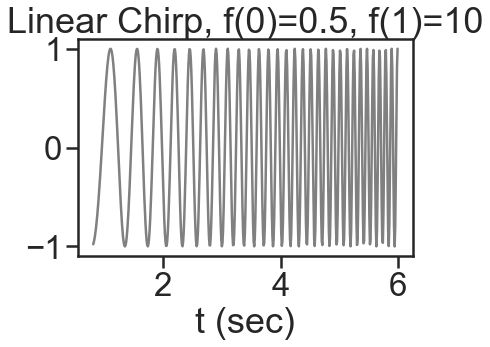

In [980]:
t = np.linspace(0.8, 6, 519)
w = ssig.chirp(t, f0=0, f1=10, t1=6, method='linear')
plt.plot(t, w)
plt.title("Linear Chirp, f(0)=0.5, f(1)=10")
plt.xlabel('t (sec)')

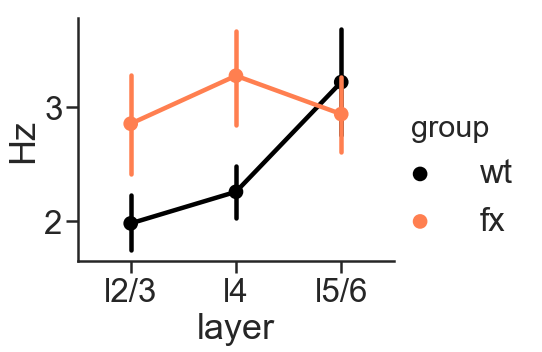

In [1654]:
cond = 'layer'
fig_inp = data[(data.times > 1) & (data.times < 6) 
#              & (data.layer == 'l5/6') 
            ]
# base = gr[(gr.times > 0) & (gr.times < 1)].groupby([ cond, 'group', 'stim1' ,'cluster_id']).mean().reset_index().Hz.values
# fig_inp = gr.groupby('cluster_id').apply(get_auc)

fig_inp = fig_inp.groupby([ cond, 'group'  ,'stim1', 'cluster_id']).mean().reset_index()

# fig_inp.loc[:,'bc_fr'] = fig_inp.Hz - base
# fig_inp = fig_inp[fig_inp.n_type != 'un']
fig_inp = fig_inp.sort_values(by = ['stim1', cond, 'group'], ascending = [False, True, False])
ax = sns.catplot( x = 'layer', y = "Hz", sharey = True,  data= fig_inp,  kind = 'point', ci = 68,  legend = True,
              palette = colors_group, sharex = False, hue = 'group', 
#                    capsize = 0.02, saturation = 1,
                   height = 5, aspect = 1.2 ,
#                   col_wrap = 2, col = cond,
                )
# plt.savefig('point_fs_odd.pdf')

	l2/3 68 63
1.9793048575003545 0.2519601737361472
2.8558806435053055 0.45592380880086
Ttest_indResult(statistic=-1.7157274979506432, pvalue=0.08861265880061317)
------------------------
	l4 99 79
2.257155767107446 0.22731190646826474
3.2779274925456687 0.39497447589379264
Ttest_indResult(statistic=-2.347154596746563, pvalue=0.02002951528955109)
------------------------
	l5/6 78 68
3.221759334319779 0.47562247660471196
2.94056983828688 0.34194361105471327
Ttest_indResult(statistic=0.46764621041142956, pvalue=0.6407445560382121)
------------------------


## SF-tuning

In [13]:
fig_inp = data[(data.times > 0.35) & (data.times < 0.5) & (data.stim1.str.contains('ctr') )]
fig_inp.cluster_id.unique().size

2471

1877


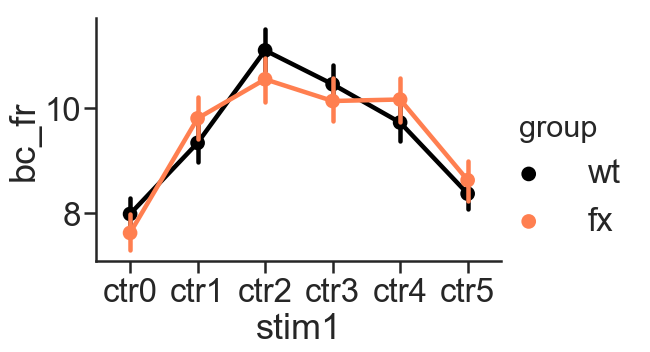

In [19]:
# f, ax = plt.subplots(figsize = (12, 8), facecolor = 'w')

# data = df_psth[~(df_psth.cluster_id.isin(high_ztc_units))]
data = df_vmmn
df_vmmn['n_type'] = df_vmmn.cluster_id.map(neuron_type)

fig_inp = data[(data.times > 0.35) & (data.times < 0.5) & (data.stim1.str.contains('ctr') )]
fig_inp = fig_inp.groupby([ 'group', 'layer' , 'cluster_id', 'stim1']).mean().reset_index()
tuning_good_units = fig_inp.pivot('cluster_id', 'stim1', 'Hz').dropna().index.values.tolist()

base = data[(data.times > 0) & (data.times < 0.3) & (data.stim1.str.contains('ctr') )].groupby([ 'group',  'layer' ,
                            'cluster_id', 'stim1']).mean().reset_index().dropna().Hz.values
fig_inp.loc[:,'bc_fr'] = fig_inp['Hz'] - base


fig_inp = fig_inp[fig_inp.cluster_id.isin(tuning_good_units)]

fig_inp['norm'] = fig_inp.groupby('cluster_id')['bc_fr'].apply(lambda x: (x-x.min())/(x.max()-x.min()))

fig_inp = fig_inp.sort_values(by = ['stim1', 'group'], ascending= [True, False])
print fig_inp.cluster_id.unique().size
ax = sns.catplot(x="stim1", y = "bc_fr", data = fig_inp,  kind = 'point', ci = 68, hue= 'group',
                    palette = ['k', 'coral'], 
#                    capsize = 0.02, saturation = 1,
                   height = 5, aspect=1.5 )
# plt.savefig('point-tuning-wt-fx-bc-fr-05-08.pdf')

In [ ]:
val = 'bc_fr'
cond = 'stim1'

# for lay in sorted(fig_inp['layer'].unique()):
#     ls = []
#     print lay
for l in sorted(fig_inp[cond].unique()):

    stat_inp = fig_inp[(fig_inp[cond] == l) 
#                        & (fig_inp.layer == lay)
                      ]
    x1 = stat_inp[(stat_inp.group == 'wt')   ][val].dropna().values
    x2 = stat_inp[(stat_inp.group == 'fx')   ][val].dropna().values

#     x3 = stat_inp[(stat_inp.group == 'wt') & (stat_inp.n_type == 'fs')][val].dropna().values
#     x4 = stat_inp[(stat_inp.group == 'fx') & (stat_inp.n_type == 'fs')][val].dropna().values

    print '\t', l, len(x1), len(x2)
    wt_mean, wt_sem = np.mean(x1), sstat.sem(x1)
    fx_mean, fx_sem = np.mean(x2), sstat.sem(x2)
#     print 'wt, fs', len(x3) ,np.mean(x3), sstat.sem(x3)
#     print 'fx, fs', len(x4) ,np.mean(x4), sstat.sem(x4)

    x1_x2 = sstat.mannwhitneyu(x1, x2)

#     data_tmp = pd.DataFrame({ 'stim1': l, 
# 'mean': [wt_mean, fx_mean], 'sem': [wt_sem, fx_sem], 'interval': '0.4-0.45',
# 'n_units': [len(x1), len(x2)], 'group': ['wt', 'fx'], 'p_val': [x1_x2[1], x1_x2[1]], 
#             'u_stat': [x1_x2[0], x1_x2[0]]
#                 })
    ls.append(x1_x2[1])
    print '------------------------'
pvals = np.array(ls)
adj = multipletests(pvals, method='fdr_bh')
print pvals
print np.round(adj[1], 5)

In [20]:
sf_df = fig_inp.sort_values('norm', ascending=False).groupby('cluster_id', as_index=False).first()
sf_list = sf_df.stim1.str.split('r', expand = True)[1].values.astype('int')
pref_d = dict(zip(sf_df.cluster_id, sf_list))

# sf_df = fig_inp[fig_inp.opto == 1].sort_values('ztc', ascending=False).groupby('cluster_id', as_index=False).first()
# pref_opto_d = dict(zip(sf_df.cluster_id, sf_df.stim1))

fig_inp['pref'] = fig_inp.cluster_id.map(pref_d)
fig_inp['n_type'] = fig_inp.cluster_id.map(neuron_type)

In [21]:
df_tuning = fig_inp

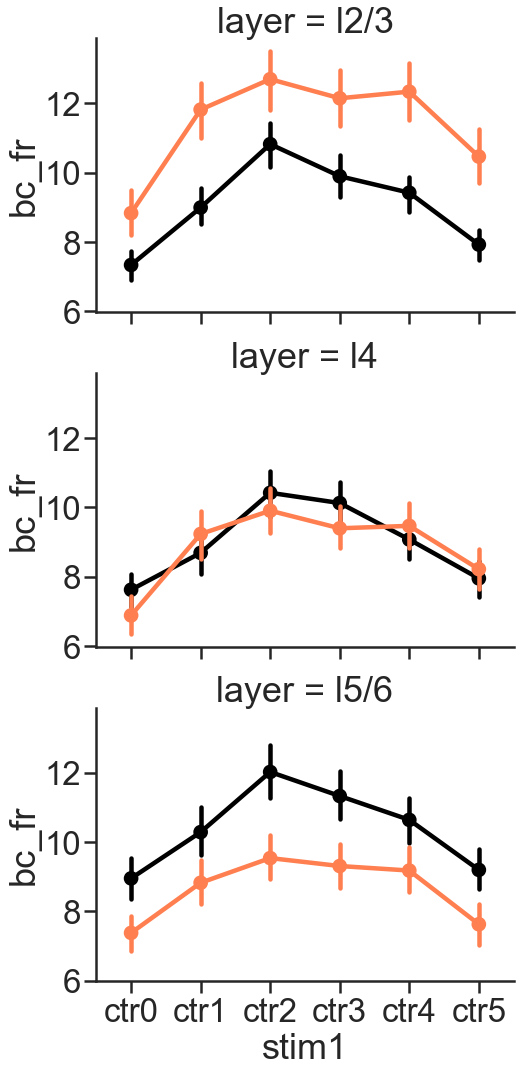

In [503]:
ax = sns.catplot(x="stim1", y = "bc_fr", data = fig_inp,  kind = 'point', 
                 ci = 68, hue= 'group', palette = colors_group, 
                 col = 'layer', col_wrap = 1, legend = False,
#                    capsize = 0.02, saturation = 1,
                   height = 5, aspect=1.5 )
# plt.savefig('point-sf-tuning_by_layer.pdf')

In [117]:
data = df_vmmn
ls = []
fig_inp = data[(data.times > 0.3) & (data.times < 0.6) 
               & (data.stim1.str.contains('ctr') ) & (data.group != 'x')]



for unit in fig_inp.cluster_id.unique()[:]:
    tmp = fig_inp[fig_inp.cluster_id == unit]
#     print unit, 
    hm = tmp.pivot('times', 'stim1', 'Hz')
    if hm.shape[1] < 6:
        continue
#     x, y = center_of_mass(hm.values)
#     tmp_df = pd.DataFrame({'x': x, 'y': y, 'unit': unit, 'group': tmp.group.unique()[0] }, index = [0])
#     ls.append(tmp_df)
#     ax = sns.heatmap(hm, cmap = 'jet') 
#     ax.invert_yaxis()
#     plt.show()
print 'done'

SyntaxError: 'break' outside loop (<ipython-input-117-f4946ed80987>, line 6)

stim1               ctr0      ctr1      ctr2      ctr3      ctr4      ctr5
cluster_id                                                                
0et013left-2    0.622802  0.666450  0.342880  1.000000  0.350701  0.000000
0et014left-2    1.000000  0.146876  0.209175  0.154614  0.614548  0.000000
0et014right-1   0.000000  0.704056  0.667528  1.000000  0.811213  0.315440
0et016left-2    0.249437  0.495626  0.110166  0.000000  0.546242  1.000000
0et016right-1   0.000000  1.000000  0.852687  0.876038  0.529667  0.627858
0et017right-1   0.881372  0.703564  1.000000  0.590178  0.222555  0.000000
0et019left-2    0.748057  0.654833  1.000000  0.777940  0.403263  0.000000
0et019right-1   0.000000  0.257658  0.905184  0.899877  0.798472  1.000000
0et020left-2    1.000000  0.626681  0.762501  0.216013  0.000000  0.237605
0et020right-1   1.000000  0.994258  0.400140  0.381363  0.000000  0.941390
0et022left-2    0.396149  0.345439  0.000000  0.358273  0.228638  1.000000
0et023left-2    0.880867  0.817908  0.977572  0.666103  1.000000  0.000000
0et023right-1   0.085216  1.000000  0.991231  0.717212  0.018017  0.000000
0et026left-1    0.359013  0.479560  0.723911  0.621983  0.000000  1.000000
0et027left-1    0.000000  0.429687  1.000000  0.512986  0.097192  0.156191
0et029left-1    0.487511  0.566599  0.709759  1.000000  0.000000  0.522434
0et030left-1    0.573205  0.420818  1.000000  0.728692  0.624386  0.000000
0et031left-1    0.509118  0.629082  0.000000  1.000000  0.740183  0.885786
0et479right     0.730752  0.570788  1.000000  0.653252  0.000000  0.361728
0et480left      0.330380  0.551980  0.000000  0.179228  0.149374  1.000000
0et481right     1.000000  0.583955  0.262551  0.282164  0.259480  0.000000
0et483left      0.431508  0.287932  0.000000  0.391118  0.750803  1.000000
0et483right     0.000000  0.685702  0.805474  0.869984  1.000000  0.035424
0et484left      0.561765  0.575510  0.000000  0.127111  0.468431  1.000000
0et485left      0.306728  1.000000  0.845023  0.314327  0.106041  0.000000
0et486left      0.000000  0.695781  0.698928  0.611687  1.000000  0.429487
0etW00left-1    0.243517  0.580159  1.000000  0.155178  0.382594  0.000000
0etW02left-1    0.931227  0.474686  1.000000  0.907480  0.000000  0.432465
0etW05left-1    0.203763  0.000000  0.625602  0.558947  1.000000  0.253749
100et014left-2  0.000000  0.561734  0.463725  0.884808  1.000000  0.736113
...                  ...       ...       ...       ...       ...       ...
99et031left-1   0.000000  0.646103  0.062123  0.052617  1.000000  0.195863
99et479right    0.000000  0.259485  0.041402  0.584320  1.000000  0.495986
99et483left     0.000000  0.184190  0.471198  1.000000  0.633946  0.054418
99et485left     0.216837  0.471735  1.000000  0.671275  0.000000  0.108416
99etW00left-1   0.104971  0.530078  0.111868  0.609517  0.000000  1.000000
9et014right-1   0.644129  1.000000  0.920701  0.135959  0.115539  0.000000
9et016right-1   0.320501  1.000000  0.000000  0.464263  0.338308  0.942849
9et017left-2    0.300521  0.000000  0.194198  0.730107  1.000000  0.917201
9et017right-1   0.000000  0.915534  0.724158  0.015388  1.000000  0.664483
9et019left-2    0.397704  0.000000  0.135863  0.795752  0.112939  1.000000
9et019right-1   0.341070  0.000000  1.000000  0.262560  0.258808  0.412306
9et020right-1   1.000000  0.848387  0.572121  0.207926  0.000000  0.279990
9et022left-2    0.004617  0.581759  1.000000  0.692986  0.714718  0.000000
9et023left-2    0.648114  0.000000  0.222126  0.682950  1.000000  0.911131
9et023right-1   0.442185  0.078695  0.796386  0.000000  1.000000  0.228168
9et024left-2    0.741256  0.870990  0.463844  1.000000  0.350925  0.000000
9et026left-1    1.000000  0.136813  0.516313  0.000000  0.342597  0.067330
9et027left-1    0.000000  0.375635  0.776319  0.995930  1.000000  0.719415
9et028left-1    0.317725  0.671655  0.713238  0.000000  0.391323  1.000000
9et030left-1    0.000000  0.228766  0.790531  0.093670  0.685162  1.000000
9et479left      0.544539 

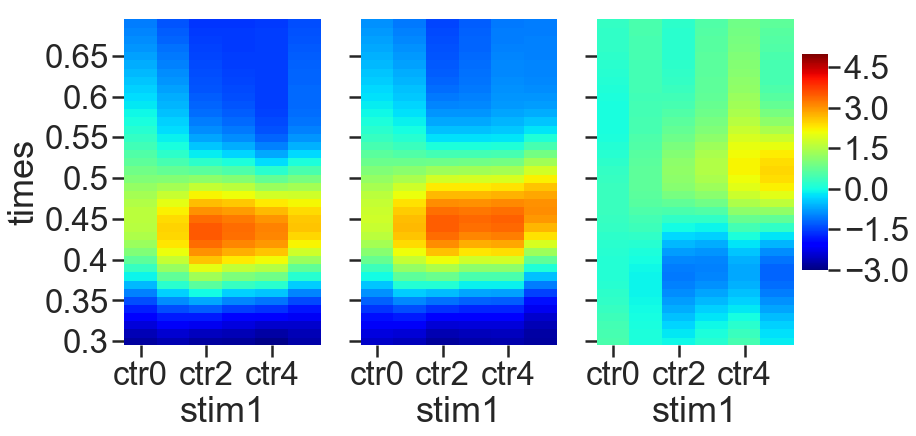

In [23]:
f, ax = plt.subplots( 1, 3, sharey = True, figsize =(12,6))
cbar_ax = f.add_axes([.91, .3, .03, .5])

data = df_vmmn
fig_inp = data[(data.times >= 0.3) & (data.times < 0.7) 
               & (data.stim1.str.contains('ctr') ) & (data.group != 't')]

vmin, vmax = 5, 20
tmp = fig_inp[fig_inp.layer != 'l']
tmp = tmp.groupby(['group', 'stim1', 'times']).Hz.mean().reset_index()
tmp2 = tmp[tmp.group == 'wt'].pivot('times', 'stim1', 'Hz')
tmp3 = tmp[tmp.group == 'fx'].pivot('times', 'stim1', 'Hz')

sns.heatmap(tmp2, cmap = 'jet', ax = ax[0], cbar = False, vmin = vmin, vmax = vmax)
sns.heatmap(tmp3, cmap = 'jet', ax = ax[1], cbar = False, vmin = vmin, vmax = vmax)
sns.heatmap(tmp3.sub(tmp2), cmap = 'jet', ax = ax[2], cbar_ax = cbar_ax, vmin = -3, vmax = 5)

ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[0].invert_yaxis()
# plt.savefig('hm-all-sf-tuning_by_time.png')

## Fit DOG to SF tuning curve

In [24]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [33]:
def diff_of_gaus(x, base, k_exc, mu_exc, sigma_exc, k_inh, mu_inh, sigma_inh):
#     y_hat = []
#     for idx in range(x.size):

#         y_hat.append( base + k_exc * np.exp( - ((x[idx] - mu_exc)**2)/(2*(sigma_exc**2))) - 
#                      k_inh * np.exp( -((x[idx] - mu_inh)**2)/(2*(sigma_inh**2))  ))
        
#     return np.array(y_hat)
    return  base + k_exc * np.exp( - ((x - mu_exc)**2)/(2*(sigma_exc**2))) - \
k_inh * np.exp( -((x - mu_inh)**2)/(2*(sigma_inh**2))  )

def exc_comp(x, base, k_exc, mu_exc, sigma_exc):
    return base + k_exc * np.exp( - ((x - mu_exc)**2)/(2*(sigma_exc**2)))

    
def inh_comp(x, base, k_inh, mu_inh, sigma_inh):
    return k_inh * np.exp( -((x[idx] - mu_inh)**2)/(2*(sigma_inh**2))  )

def lsfs(data):
    lsf_fr = data[data.stim1 == 'ctr0'].Hz
    pref_fr = data.Hz.max()
    data['lsfs'] = lsf_fr/pref_fr
    return data

In [168]:
import time


0


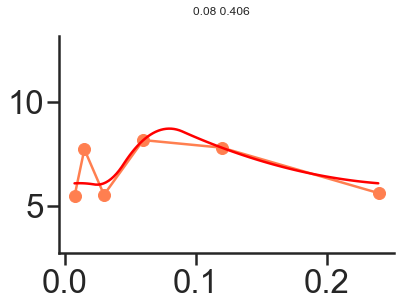

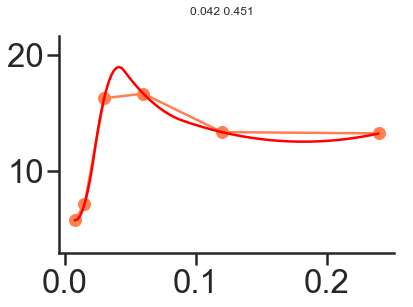

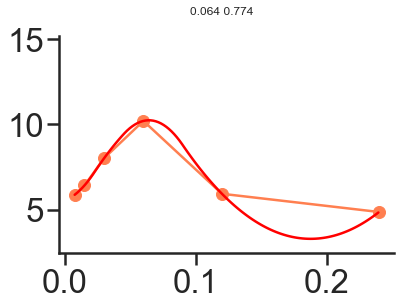

In [174]:
x = np.array([0.625, 0.125, 0.25, 0.5, 1])
d_k_exc = {}
d_mu_exc = {}
d_sigma_exc = {}
d_k_inh = {}
d_mu_inh = {}
d_sigma_inh = {}
d_fit_error = {}
d_fit_pref_sf = {}
d_qfactor = {}

x = np.array([7.5e-3, 0.015, 0.03, 0.06, 0.12, 0.24])
x_new = np.arange(7.5e-3, 0.24, 0.002)

untun_units = df_odd[~(df_odd.tun_group == 'untun') & (df_odd.layer != 'l')].cluster_id.unique()
data_fit = df_tuning[df_tuning.cluster_id.isin(untun_units)]
untun_counter = 0
for unit in data_fit[data_fit.group == 'fx'].cluster_id.unique()[20:30]:
    tmp = df_tuning[df_tuning.cluster_id == unit]
#     x  = tmp.stim1.values.astype('float')
    y = tmp.Hz.values.round(5)
    m = y.max()
    base = y.min()
    try:
        # (_, base, k_exc, mu_exc, sigma_exc, k_inh, mu_inh, sigma_inh)
        init_params = [0.01, 0.01, 0.01, .01, .01, .01, .01 ]
        bound_params = ([0, 0, 0, 0, 0, 0, 0], [m*2, m*2, 1, 1, m*2, 1, 1])
        popt, pcov = curve_fit(diff_of_gaus, x, y, bounds = bound_params , p0 = init_params)
    #     perr = np.sqrt(np.diag(pcov_double))

        fit = diff_of_gaus(x, *popt)
#         fit_exc = exc_comp(x, *popt[:4] )
#         fit_inh = inh_comp(x, popt[0], *popt[4:])
        fit_error = sum((y-fit)**2)  /  sum((y-y.mean())**2)
        
        f2 = interp1d(x, fit, kind = 'quadratic')
#         f3 = interp1d(x, fit_exc, kind = 'quadratic')
#         f4 = interp1d(x, fit_inh, kind = 'quadratic')
#         perr = np.sqrt(np.diag(pcov))

        d_k_exc[unit] = popt[1]
        d_mu_exc[unit] = popt[2]
        d_sigma_exc[unit] = popt[3]
        d_k_inh[unit] = popt[4]
        d_mu_inh[unit] = popt[5]
        d_sigma_inh[unit] = popt[6]
        d_fit_error[unit] =  round(fit_error, 3)
#         if fit_error < 0.9:
        d_fit_pref_sf[unit] = x_new[f2(x_new).argmax()]
        
    except:
        print unit
        untun_counter +=1
#         f, ax = plt.subplots()
#         sns.despine(ax = ax)
#         ax.plot(x, y, 'ko-')
#         ax.set_ylim(base/2, m + 5)
#         plt.show()
        continue
    
    pref_idx = f2(x_new).argmax()
    pref = x_new[pref_idx]
    low_x = x_new[:pref_idx]
    high_x = x_new[pref_idx:]
    thd = f2(x_new).max()/(2**(1/2))
    
    if low_x.size == 0 or high_x.size == 0:
        continue
    
    low_idx = np.argmax(f2(low_x[::-1]) <= thd)
    high_idx = np.argmax(f2(high_x) <= thd)
    
    if low_idx == 0 or high_idx == 0:
        continue
    low_cut, high_cut = x_new[pref_idx - low_idx], x_new[pref_idx + high_idx]
    q_factor = pref/(high_cut - low_cut)
    d_qfactor[unit] = round(q_factor, 3)
#     print low_idx, high_idx, pref, low_cut, high_cut, q_factor
    
    f, ax = plt.subplots()
    sns.despine(ax = ax)
    ax.plot(x, y, 'o-', color = 'coral')
    ax.plot(x_new, f2(x_new), 'r-')
    ax.set_ylim(base/2, m + 5)
#     ax.plot(x_new, f3(x_new), 'r--')
#     ax.plot(x_new, f4(x_new), 'b--')

    plt.suptitle(str(round(pref, 3)) +" " + str(round(q_factor, 3)) )
#     print 'pref sf', x_new[f2(x_new).argmax()]
#     print 'fit_err', round(fit_error, 3)
#     print 'base', round(popt[0], 3)
#     plt.show()
    time.sleep(10)
    plt.savefig(str(unit) + 'wt_sf_tun_example.pdf', transparent=True)
    

print untun_counter
# df_tuning['k_exc'] = df_tuning.cluster_id.map(d_k_exc)
# df_tuning['mu_exc'] = df_tuning.cluster_id.map(d_mu_exc)
# df_tuning['s_exc'] = df_tuning.cluster_id.map(d_sigma_exc)
# df_tuning['k_inh'] = df_tuning.cluster_id.map(d_k_inh)
# df_tuning['mu_inh'] = df_tuning.cluster_id.map(d_mu_inh)
# df_tuning['s_inh'] = df_tuning.cluster_id.map(d_sigma_inh)
# df_tuning['fit_err'] = df_tuning.cluster_id.map(d_fit_error)
# df_tuning['fit_pref'] = df_tuning.cluster_id.map(d_fit_pref_sf)



In [135]:
len(d_qfactor.keys())

374

In [113]:
def q_factor(x_new, f2):    
    pref_idx = f2(x_new).argmax()
    pref = x_new[pref_idx]
    low_x = x_new[:pref_idx]
    high_x = x_new[pref_idx:]
    thd = f2(x_new).max()/(2**(1/2))
    
    if low_x.size == 0 or high_x.size == 0:
        return "nan"
    
    low_idx = np.argmax(f2(low_x[::-1]) <= thd)
    high_idx = np.argmax(f2(high_x) <= thd)
    
    if low_idx == 0 or high_idx == 0:
        return 'nan'
    low_cut, high_cut = x_new[pref_idx - low_idx], x_new[pref_idx + high_idx]
    q_factor = pref/(high_cut - low_cut)
    return q_factor

array([12.25425351, 12.08021795, 11.75808066, 11.28784163, 10.66950088,
        9.90305838])

In [1307]:
df_tuning = df_tuning.groupby('cluster_id').apply(lsfs)

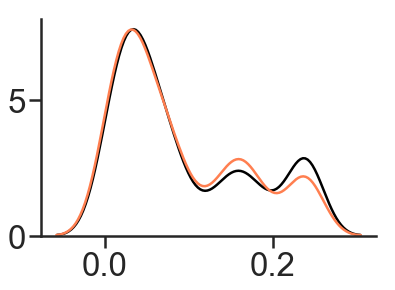

In [37]:
val = 'fit_pref'
tmp = df_tuning[(df_tuning.fit_err > -1) ].groupby(['group',
                                            'cluster_id']).mean().reset_index()

x = tmp[tmp.group == 'wt'][val].dropna().values
x2 = tmp[tmp.group == 'fx'][val].dropna().values

sns.distplot(x, hist=False,  color = colors_group[0])
sns.distplot(x2, hist = False,  color = colors_group[1])
# plt.axvline(0.03, color='blue')
# plt.axvspan(0.02, 0.04, alpha=0.5, color='gray')
# plt.axvspan(0, 0.02, alpha=0.5, color='gray')
# plt.axvspan(0.04, 0.24, alpha=0.5, color='gray')
# plt.xlim(0,1)
# plt.ylim(-1,1)
sns.despine()
# plt.savefig('fit_pref_odd.pdf')

In [38]:
print len(x), len(x2)
print np.mean(x)
print np.mean(x2)
print sstat.ks_2samp(x, x2)

949 705
0.09367070600632246
0.08903758865248226
Ks_2sampResult(statistic=0.045762243197393304, pvalue=0.3576882375362563)


	ctr0 1057 820
------------------------
	ctr1 1057 820
------------------------
	ctr2 1057 820
------------------------
	ctr3 1057 820
------------------------
	ctr4 1057 820
------------------------
	ctr5 1057 820
------------------------
[1.11666667 1.01       0.28666667 ... 0.41383073 0.11875381 0.25872963]
[1. 1. 1. ... 1. 1. 1.]


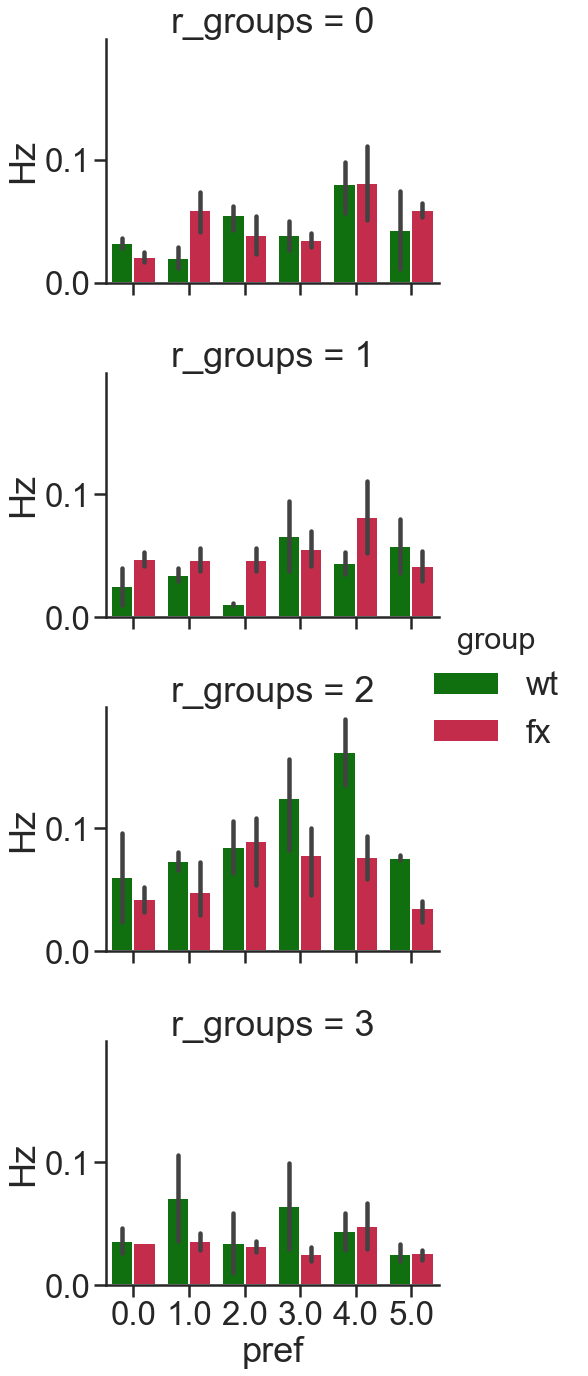

In [1340]:
# x = _inp[(_inp.r_groups == 0) & (_inp.group == 'wt') & (_inp.abs_times == 0.5)].dropna().pref.values
# y = _inp[(_inp.r_groups == 0) & (_inp.group == 'fx') & (_inp.abs_times == 0.5)].dropna().pref.values

tmp = _inp[_inp.abs_times == 0.5].groupby(['group', 'et', 'r_groups', 'pref']).agg({'Hz': 'count'}).groupby(level=1).apply(lambda x:
                                                  x / float(x.sum())).reset_index()
tmp = tmp.sort_values(by = ['pref', 'group'], ascending= [False, False])

ax = sns.catplot(x = "pref", y = "Hz",   data = tmp,  kind = 'bar', ci = 68, 
                  palette = colors, hue = 'group', 
                 col = 'r_groups', col_wrap = 1,
                    size = 5, aspect=1.5
                    )
# plt.savefig('bar-pref-dist-proportion-by-et.pdf')

0et483left


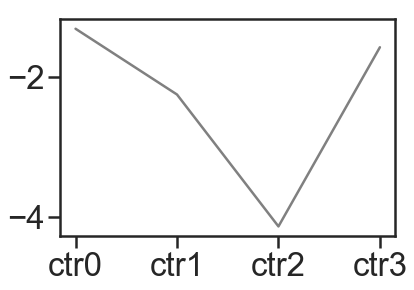

100et019right-1


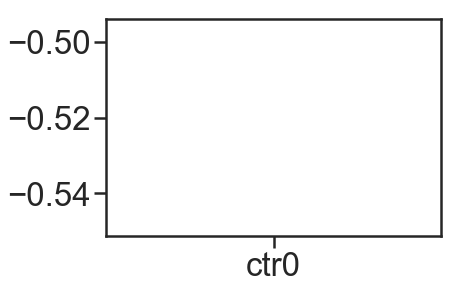

105et019left-2


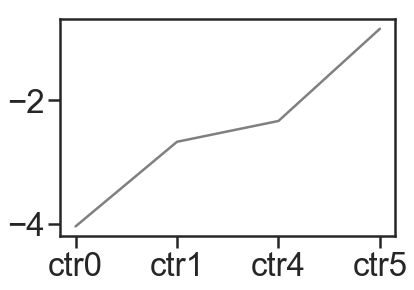

107et029left-1


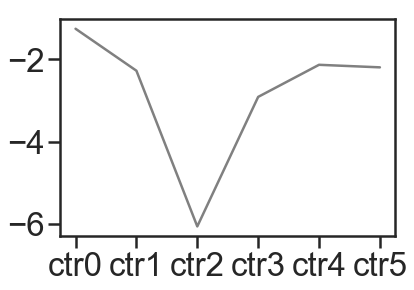

108et483right


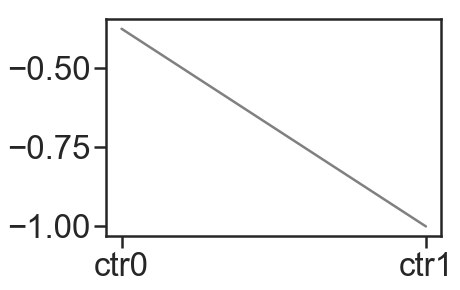

109et020right-1


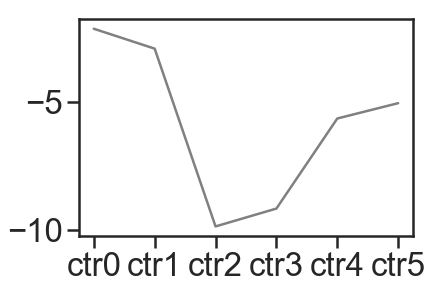

10et020left-2


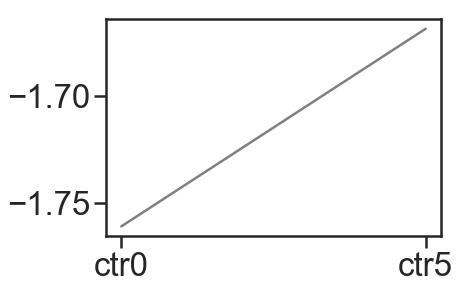

110et019right-1


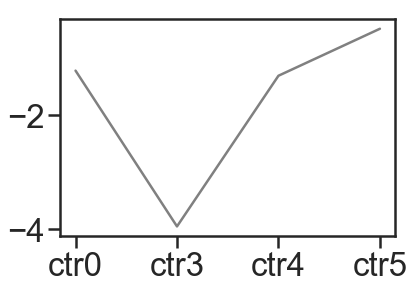

112et029left-1


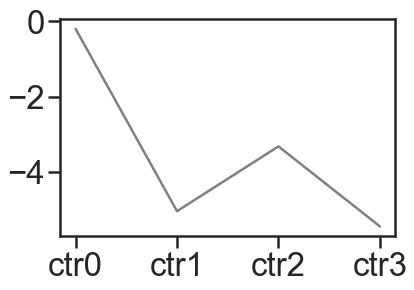

115et019left-2


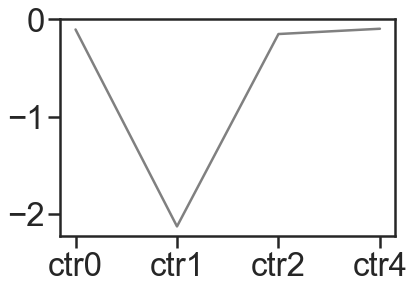

11et019right-1


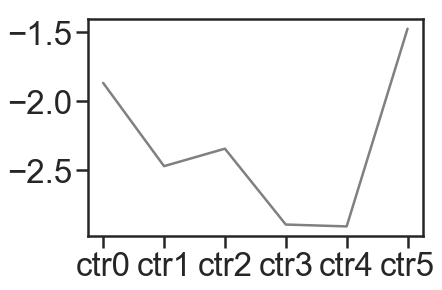

120et483left


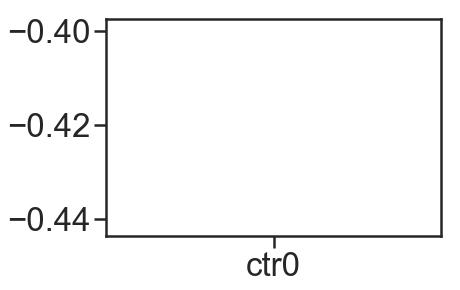

122et017right-1


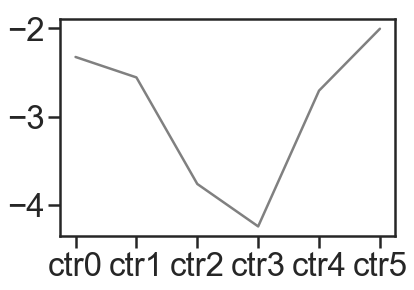

127et019right-1


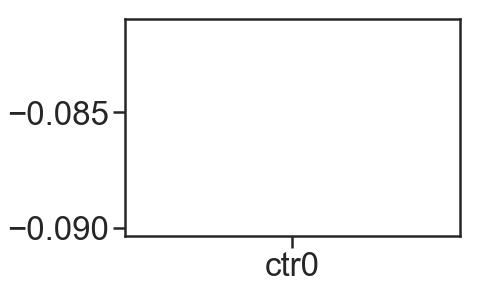

128et019left-2


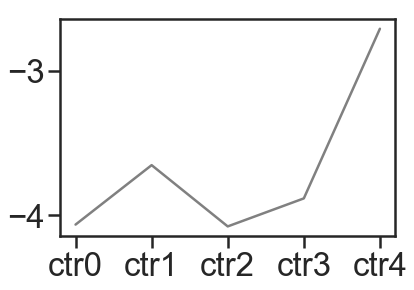

12et020right-1


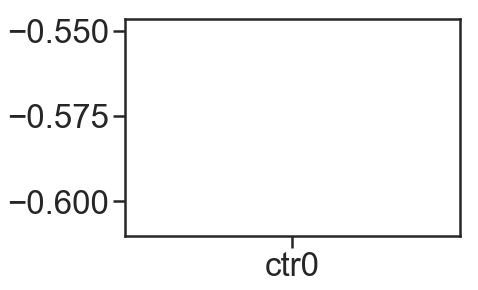

12et029left-1


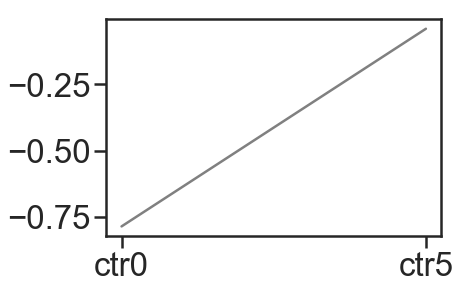

12et483right


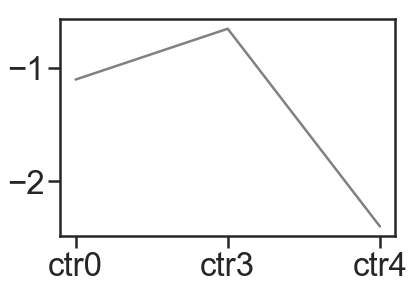

13et019left-2


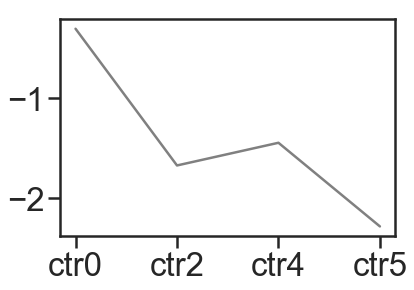

13et019right-1


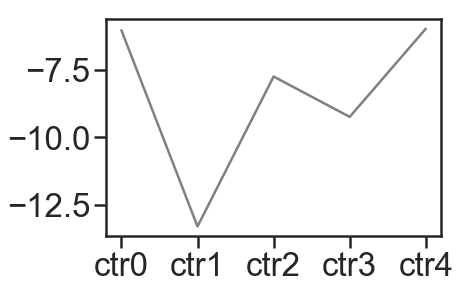

13et020right-1


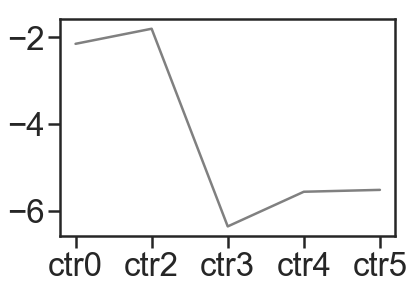

140et020right-1


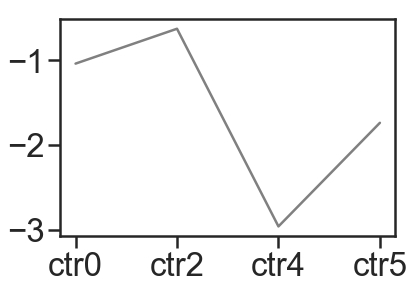

141et017right-1


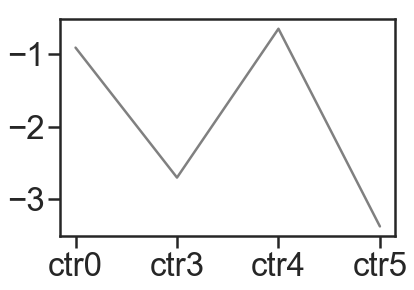

143et019right-1


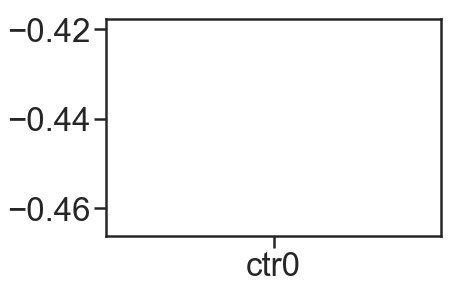

147etW00left-1


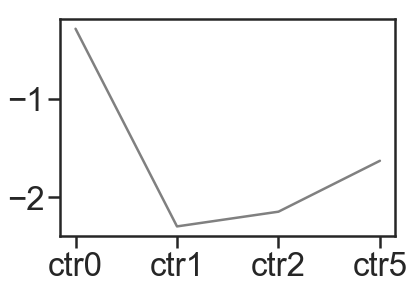

14et019right-1


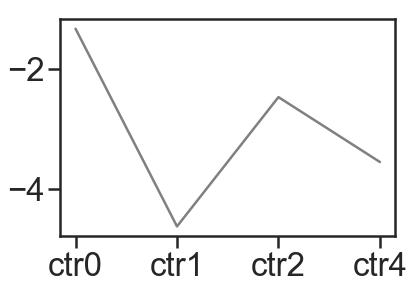

14et035left-1


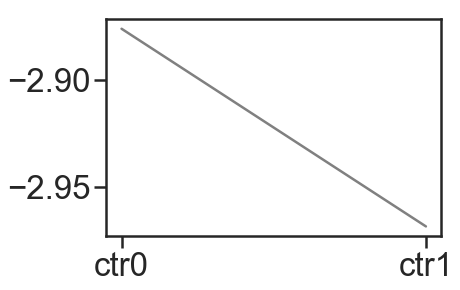

150et483right


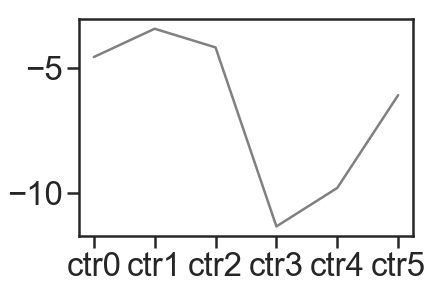

154et484left


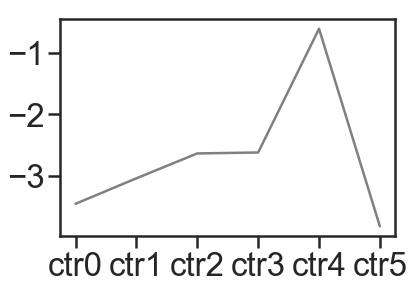

156et019left-2


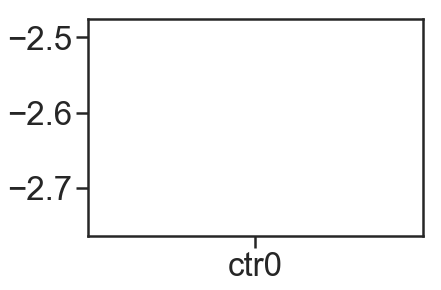

158etW02left-1


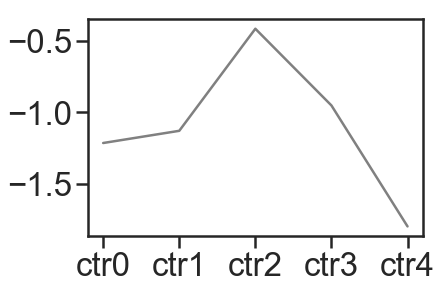

159et013left-2


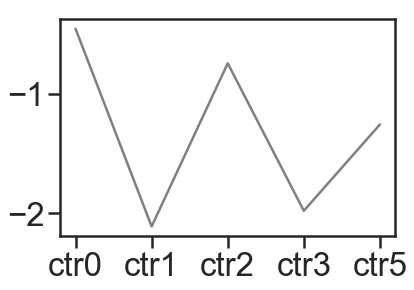

159et483right


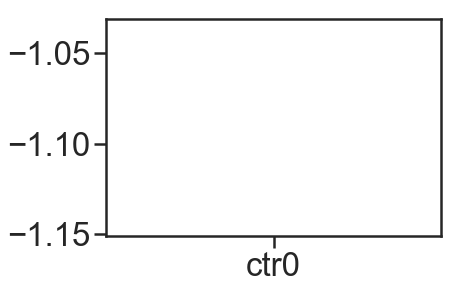

15et483right


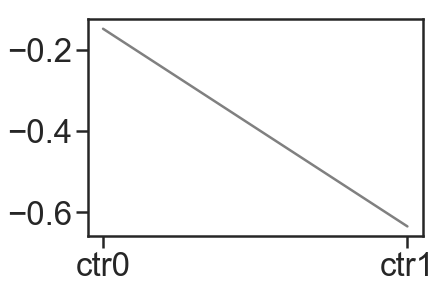

15etW02left-1


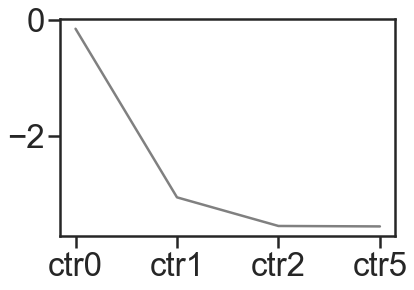

160etW01left-1


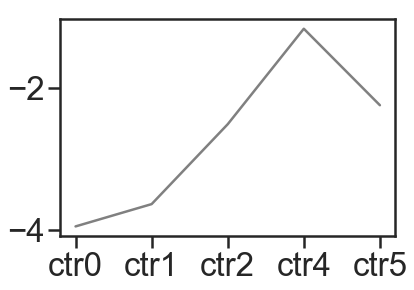

161etW02left-1


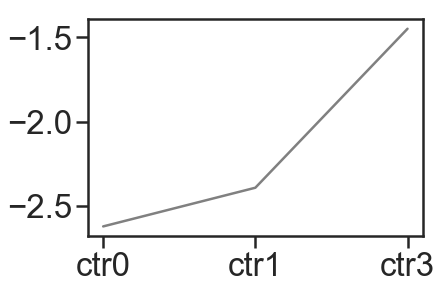

163et020left-2


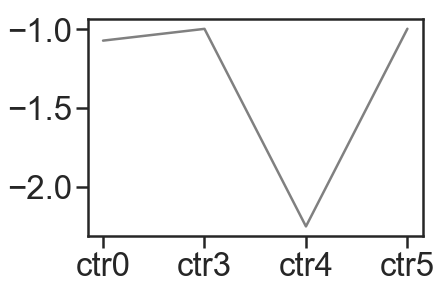

163et483right


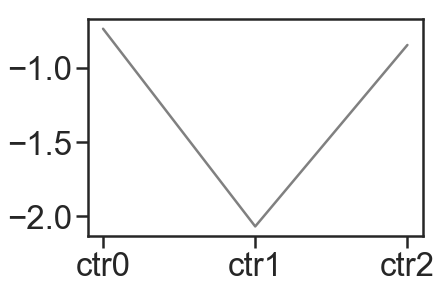

164et013left-2


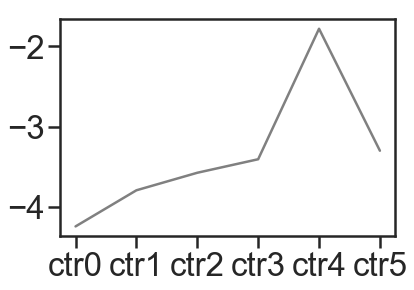

16et029left-1


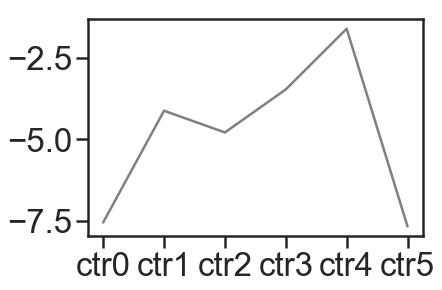

173et023left-2


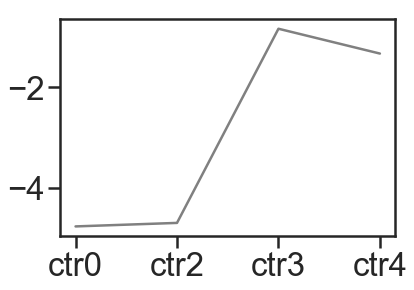

173et485left


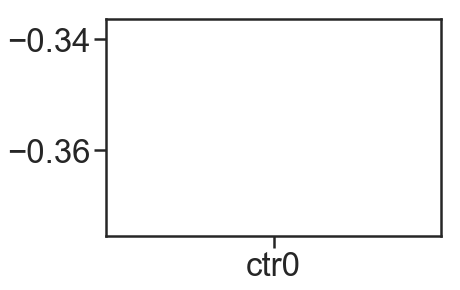

177et020right-1


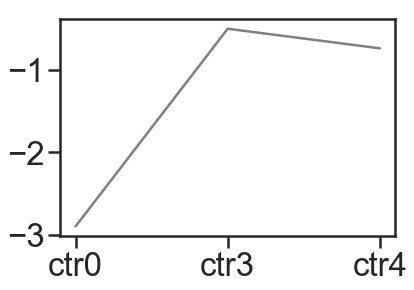

17et013left-2


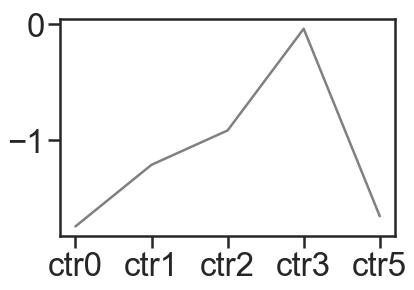

186et484left


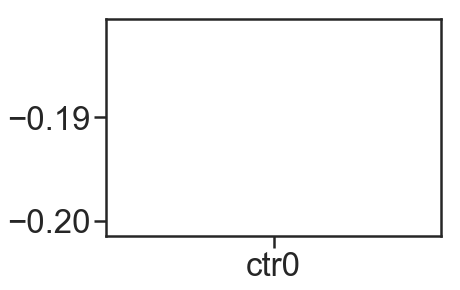

189et484left


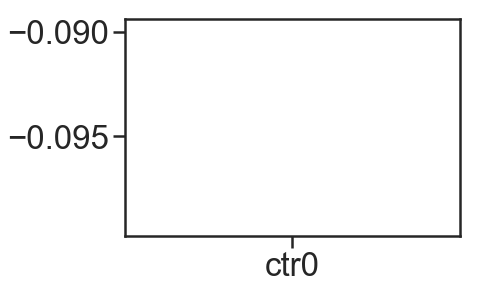

1et029left-1


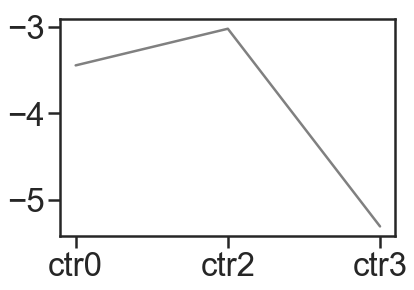

20etW02left-1


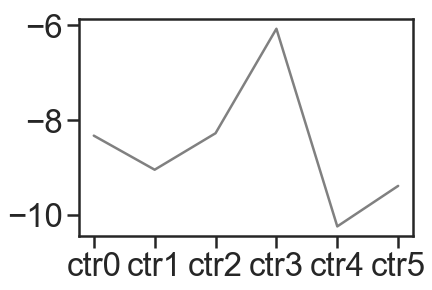

21et019left-2


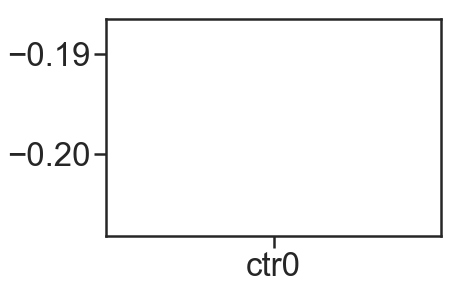

21et019right-1


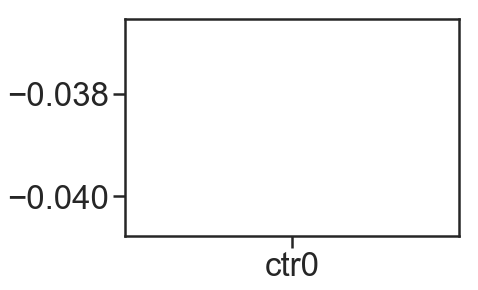

21et020left-2


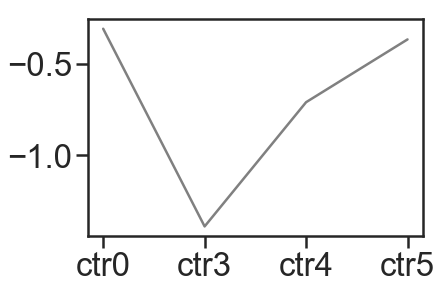

24et019right-1


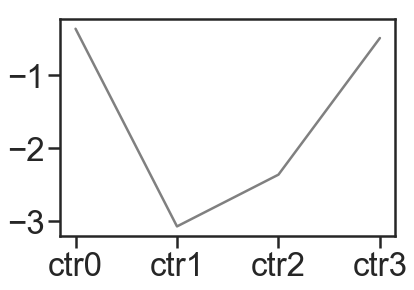

24et023right-1


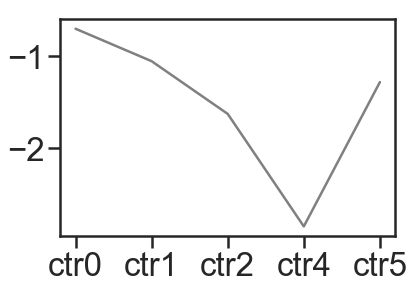

24et483left


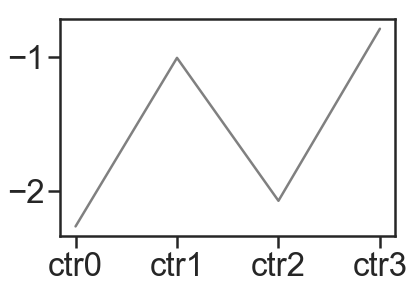

25et479left


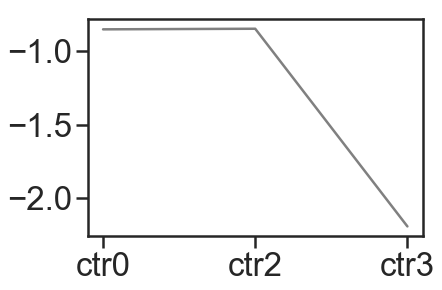

26et483right


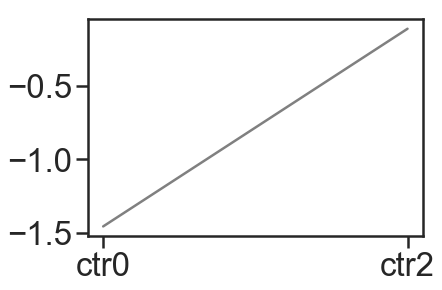

27et017right-1


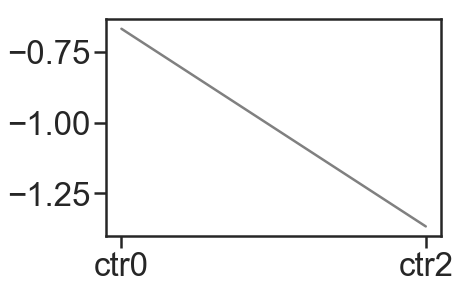

27et484left


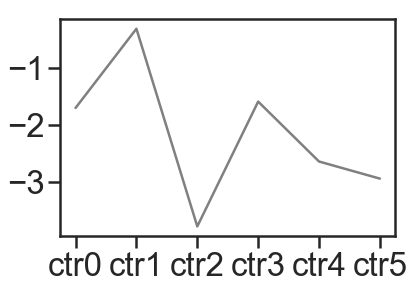

28et017left-2


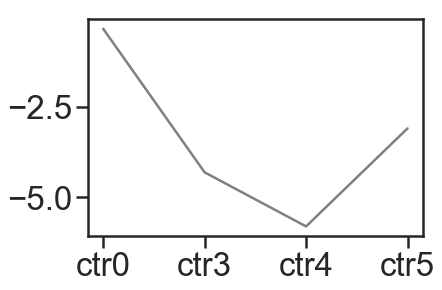

28et484left


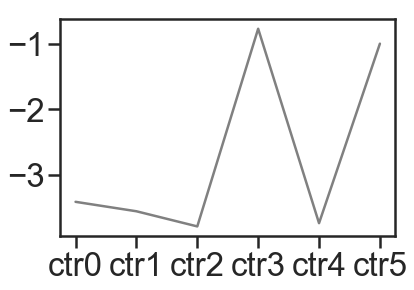

2et483right


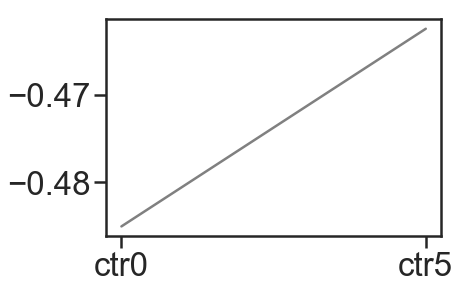

30et020left-2


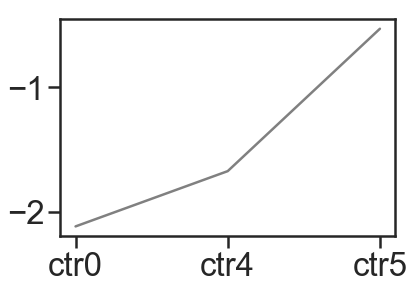

30et479left


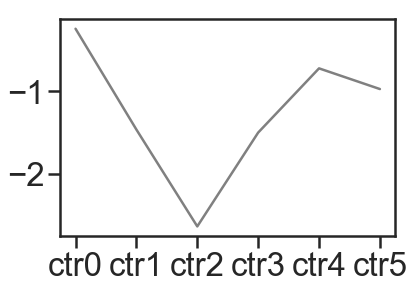

31et017left-2


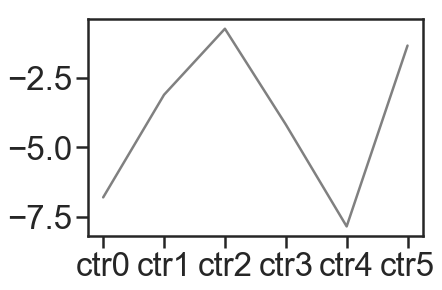

31et020left-2


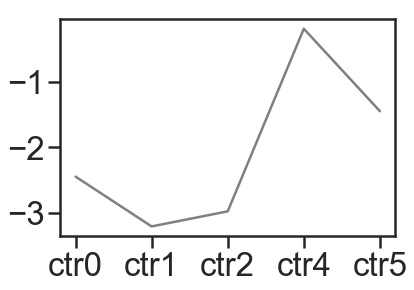

32et023right-1


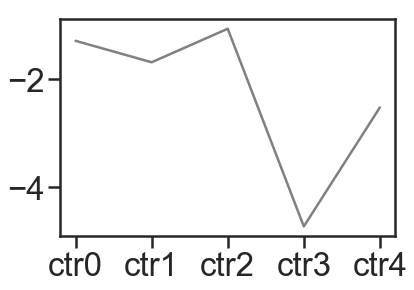

33et483left


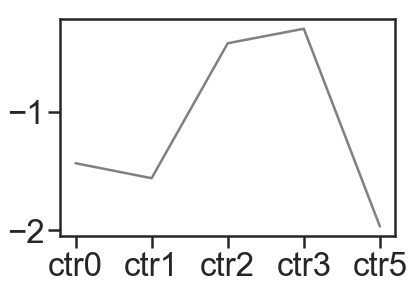

33et483right


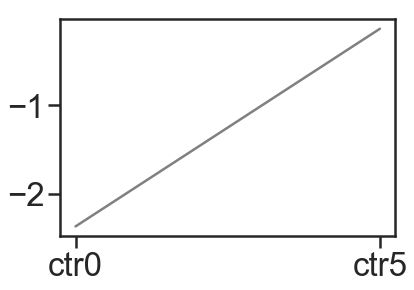

33etW00left-1


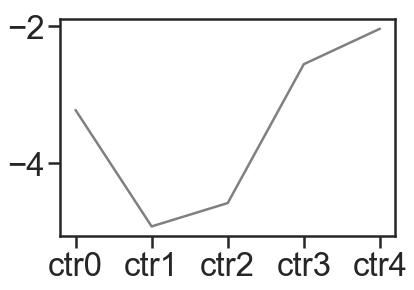

35et484left


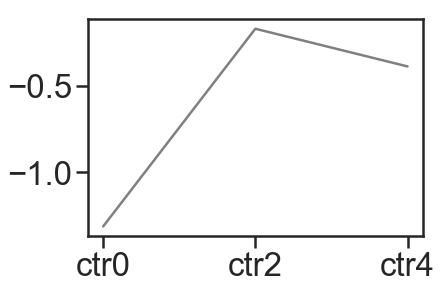

37et020right-1


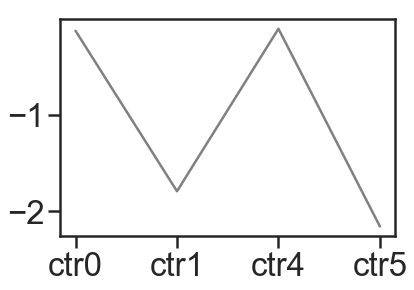

39et017right-1


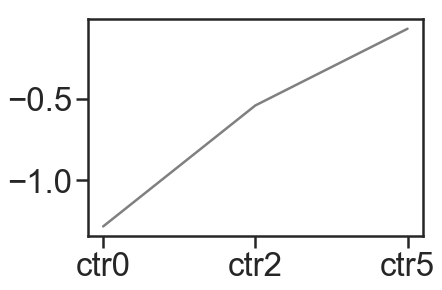

39et483right


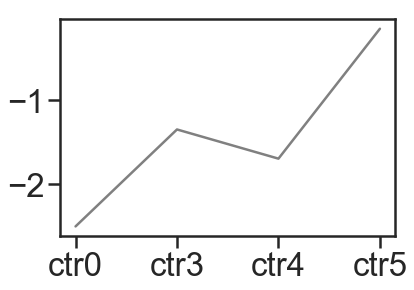

3et023left-2


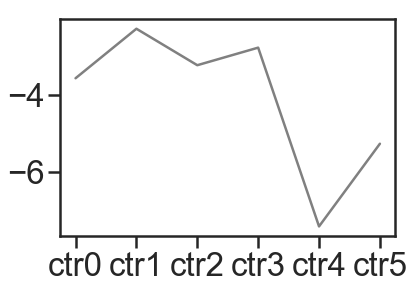

40et483right


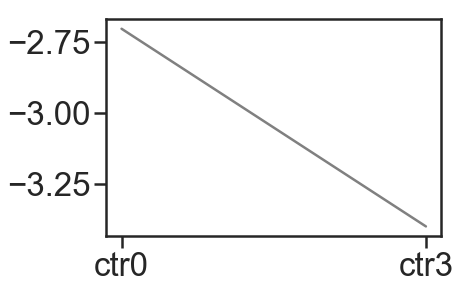

42et017right-1


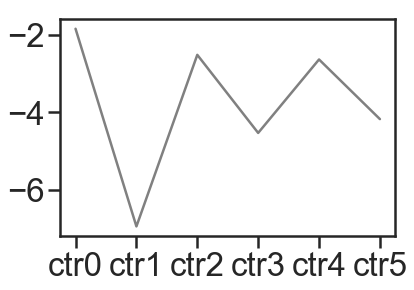

42et029left-1


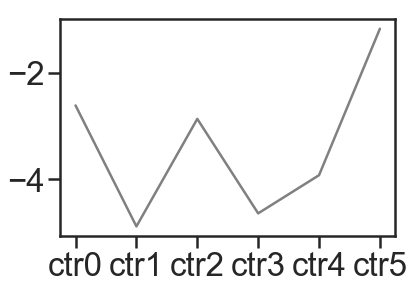

43et483right


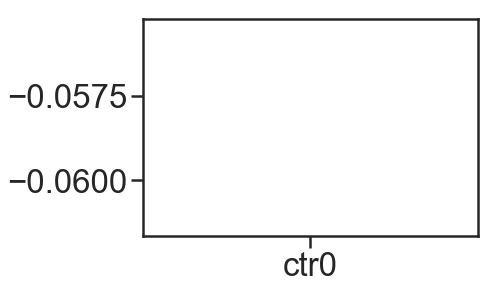

45et017left-2


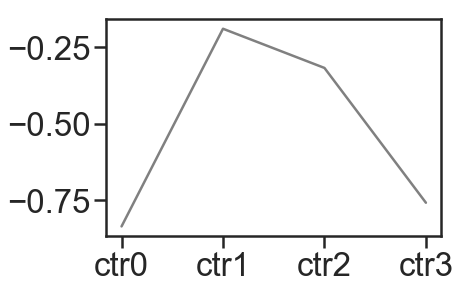

45et483right


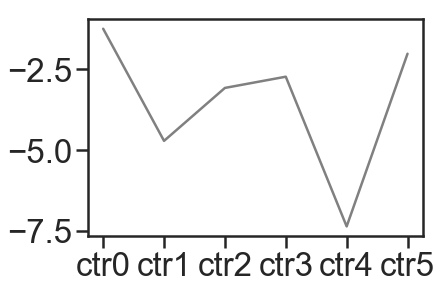

46et029left-1


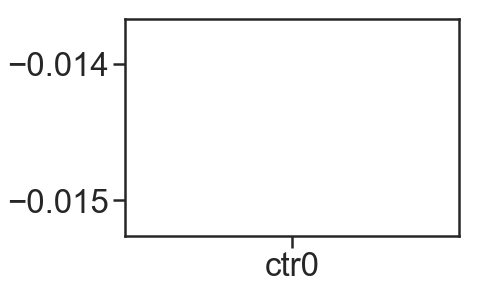

49et023left-2


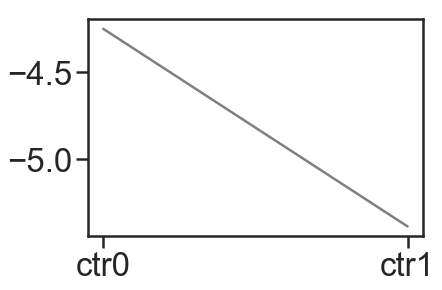

4et020left-2


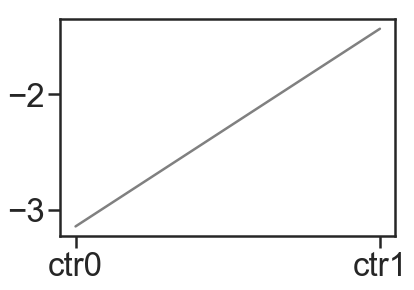

4etW01left-1


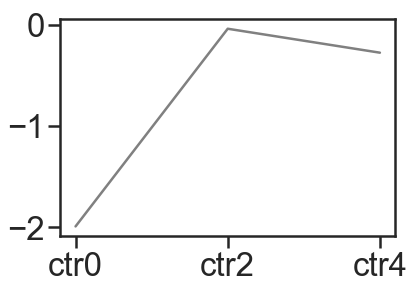

50et020right-1


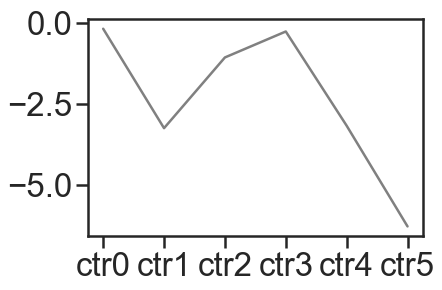

51et479right


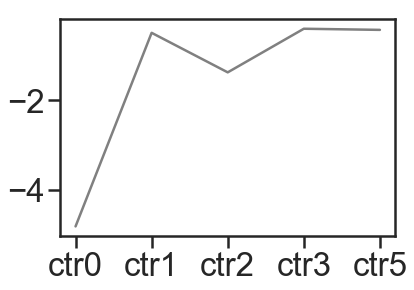

52et483right


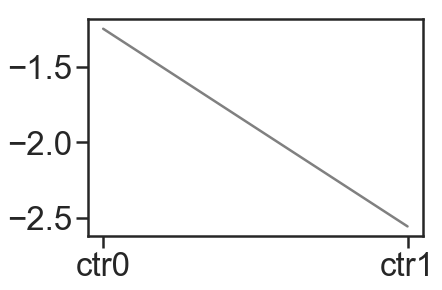

54et013left-2


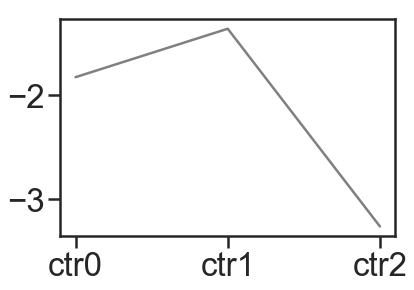

55et483left


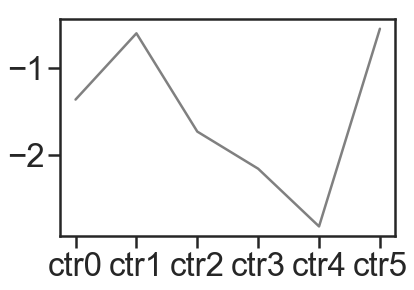

56et035left-1


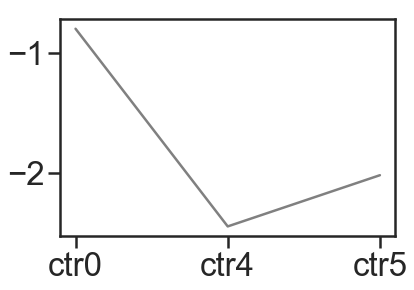

57etW00left-1


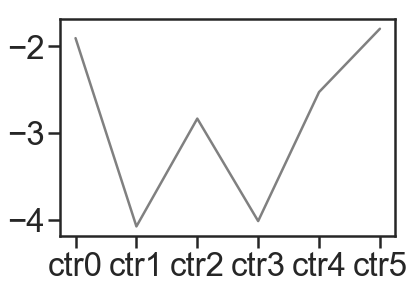

58et019left-2


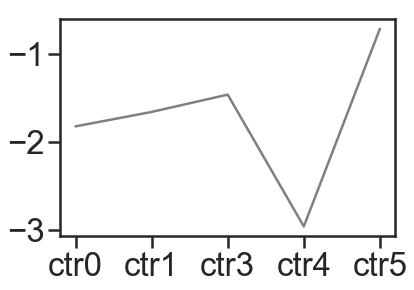

5et479left


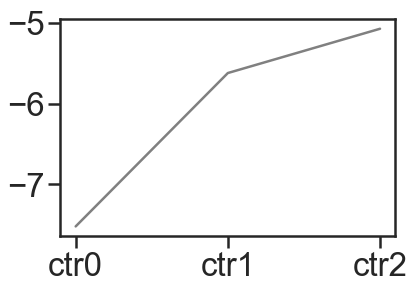

60et013left-2


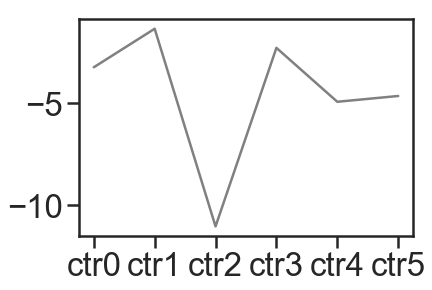

60etW00left-1


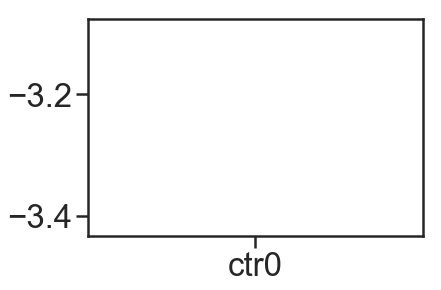

61et483right


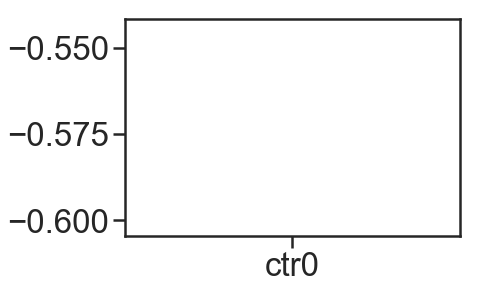

63et017right-1


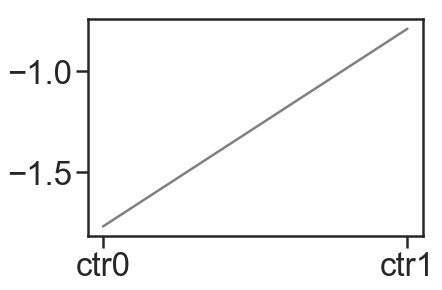

63et019right-1


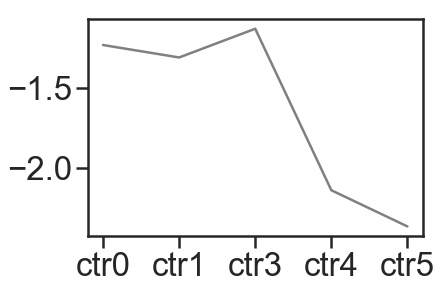

64et017left-2


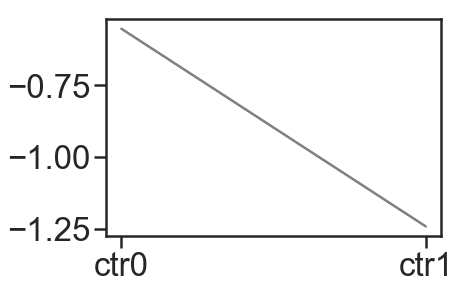

65et483right


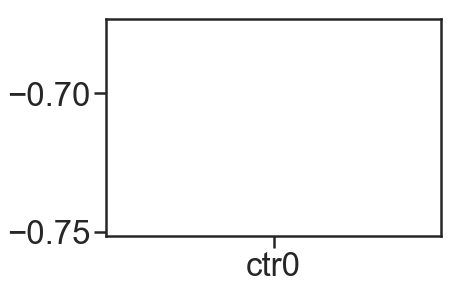

65et485left


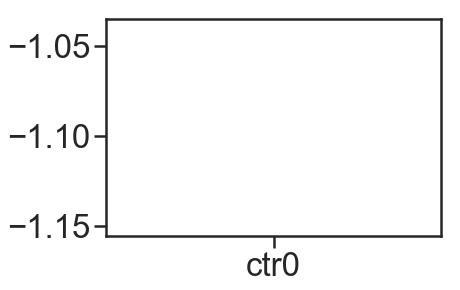

66et484left


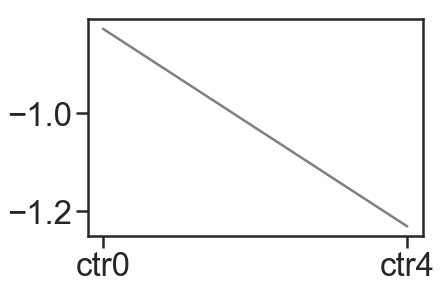

68et484left


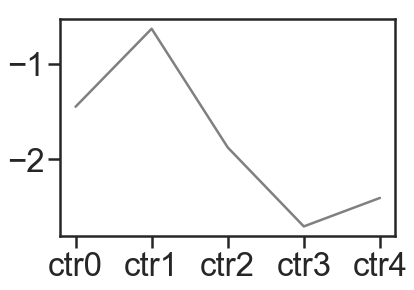

68etW03left-1


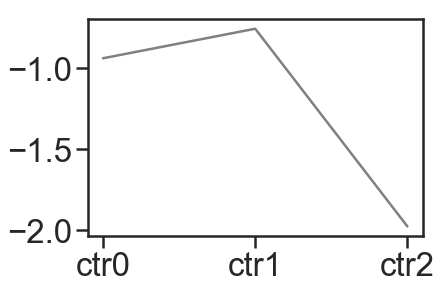

70et483right


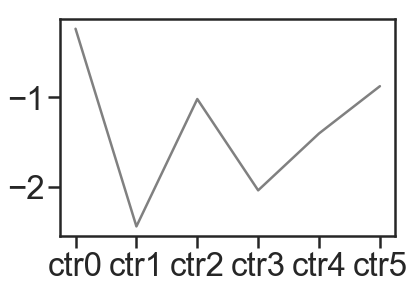

71etW02left-1


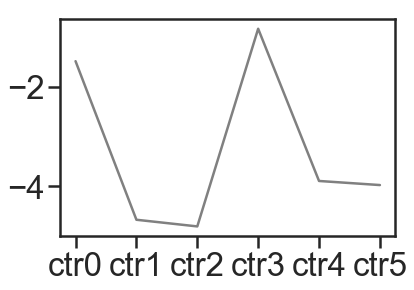

72et483left


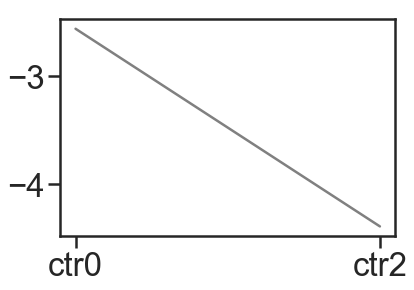

73et019right-1


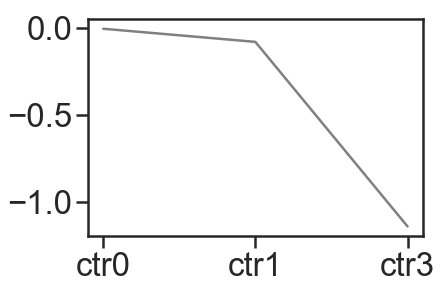

73et484left


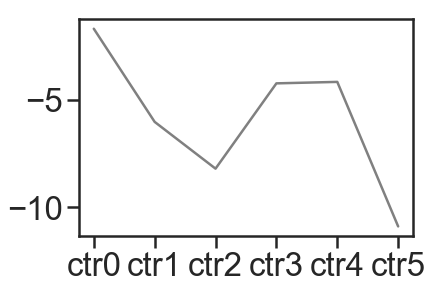

73etW02left-1


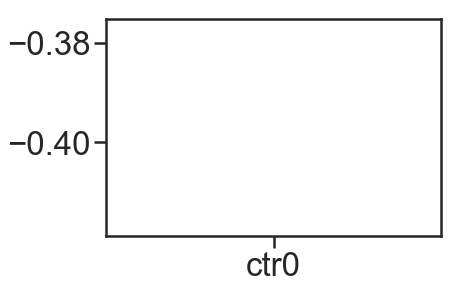

74et029left-1


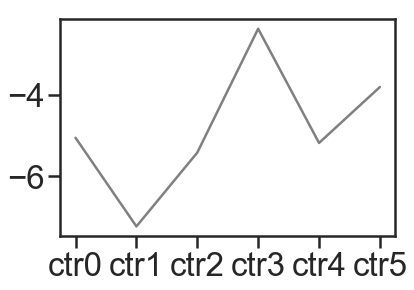

74etW00left-1


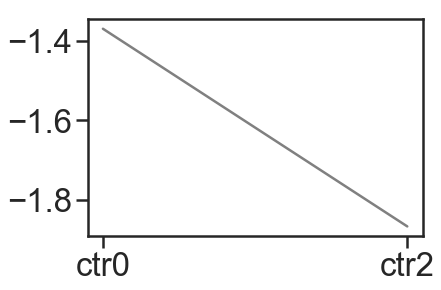

75etW00left-1


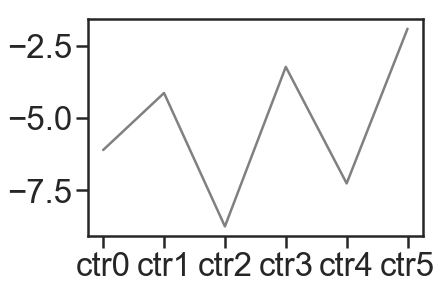

77et013left-2


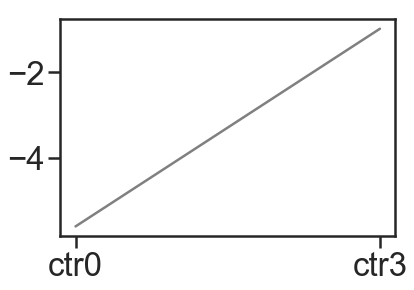

79etW02left-1


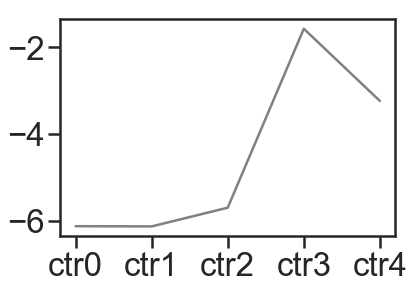

7et017right-1


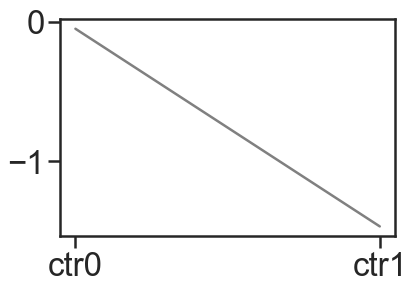

7et483right


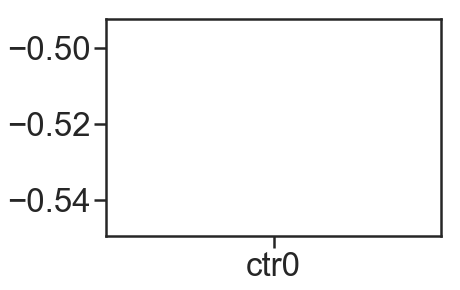

80et479left


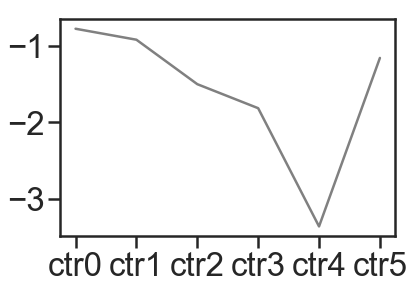

81et484left


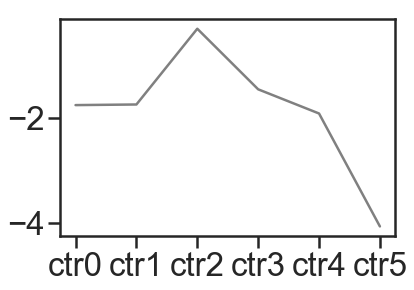

83etW03left-1


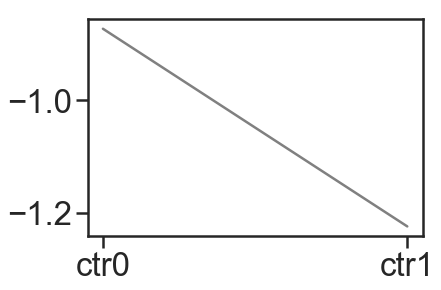

8et029left-1


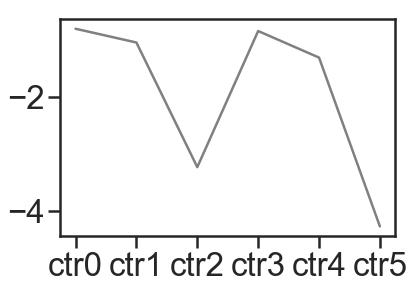

91et479right


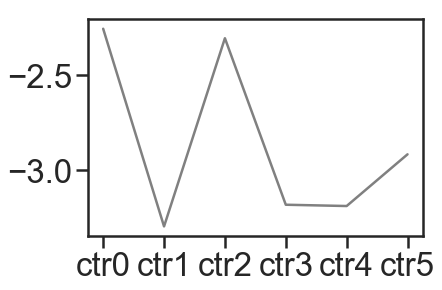

91etW01left-1


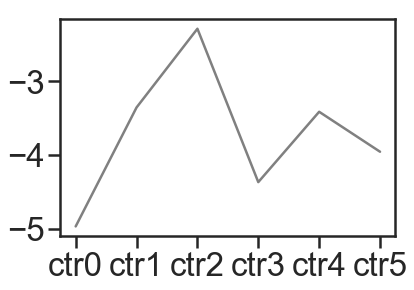

91etW03left-1


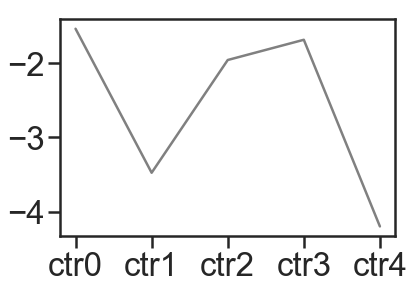

93et020right-1


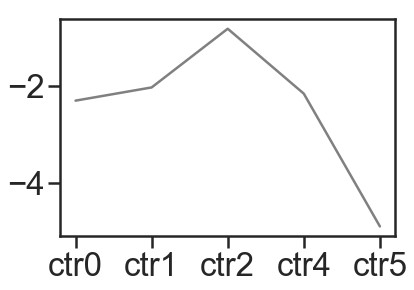

94et013left-2


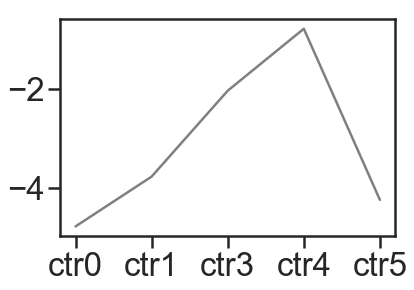

9et019left-2


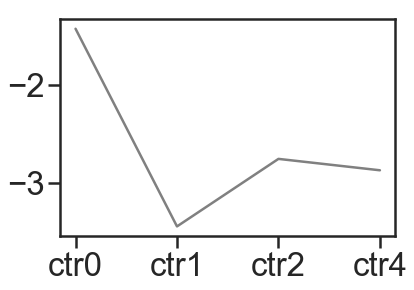

9et479left


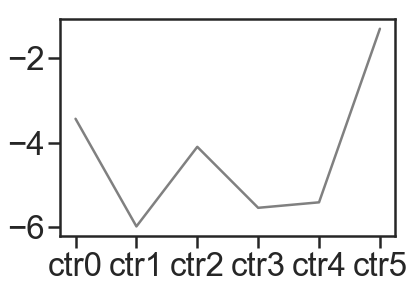

9et483left


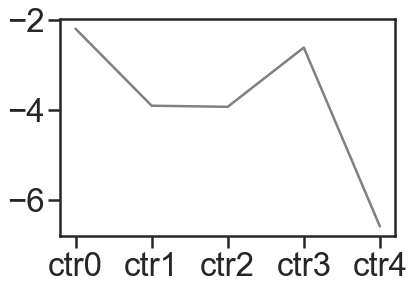

9et483right


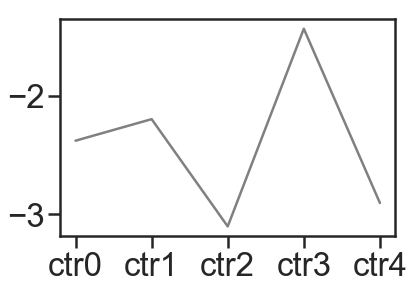

9et484left


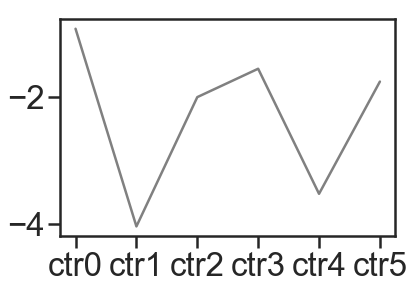

9etW01left-1


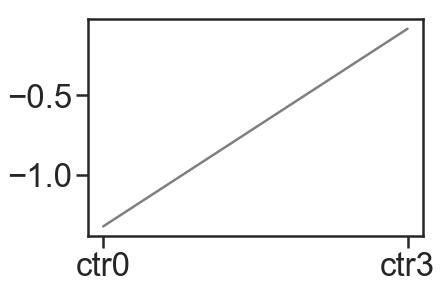

100et019left-2


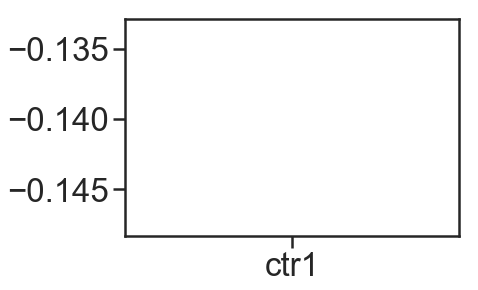

10et485left


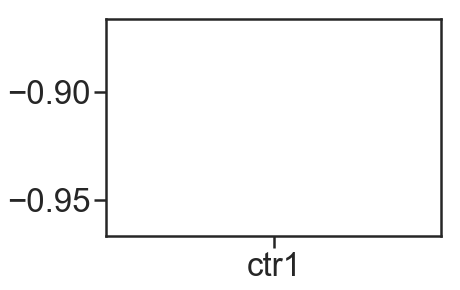

110et479left


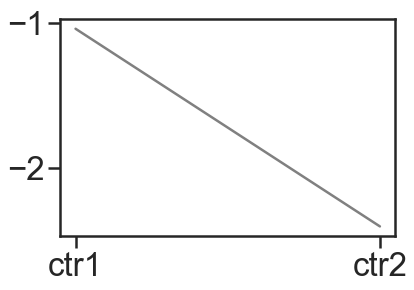

111et017right-1


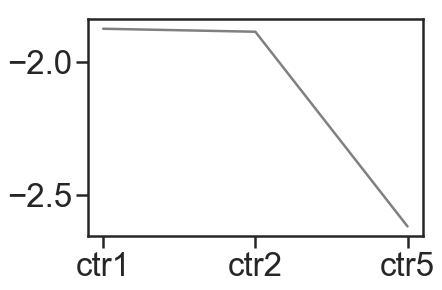

113et479right


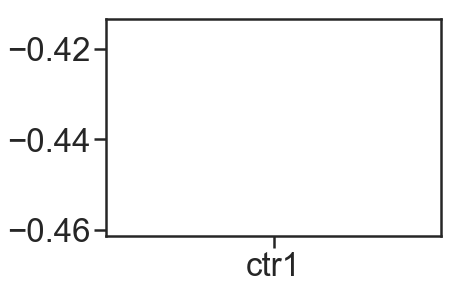

113et483right


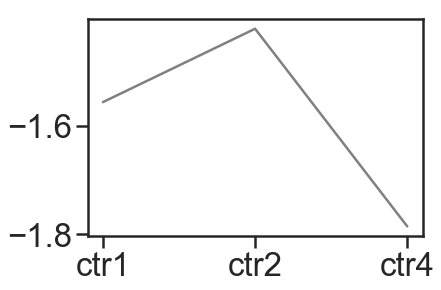

127et484left


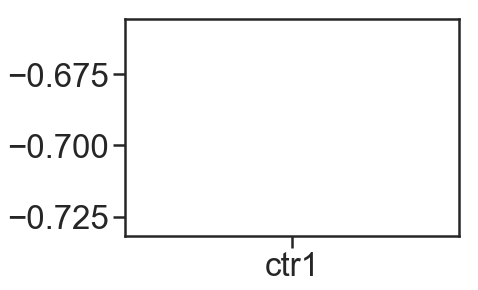

128et479left


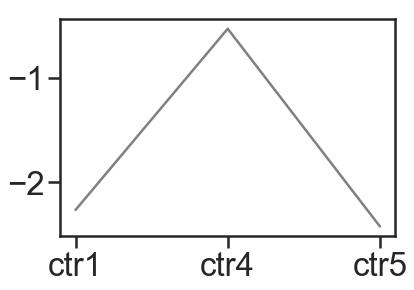

130et020left-2


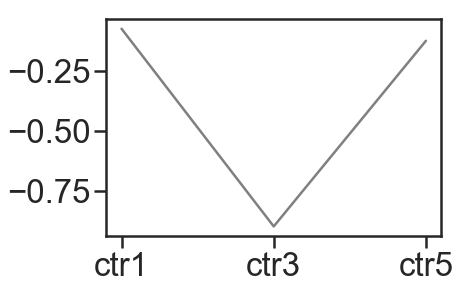

137et483right


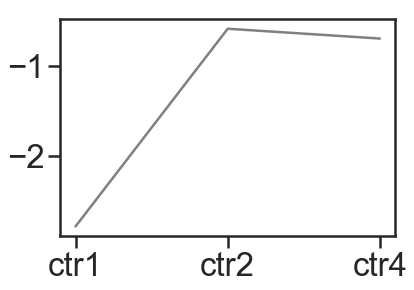

139etW01left-1


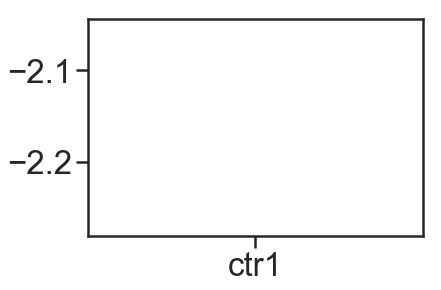

142et029left-1


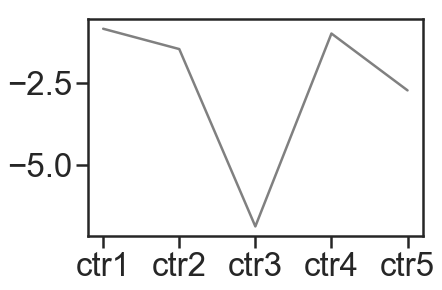

143et479left


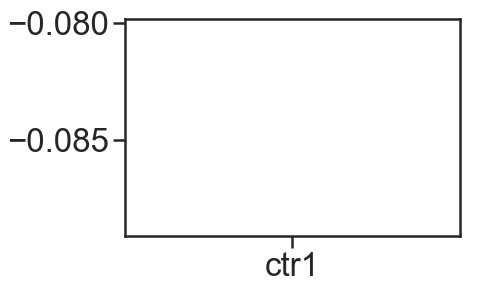

14etW00left-1


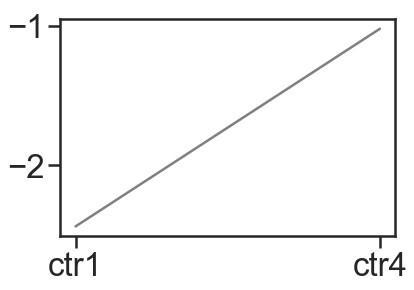

152et479left


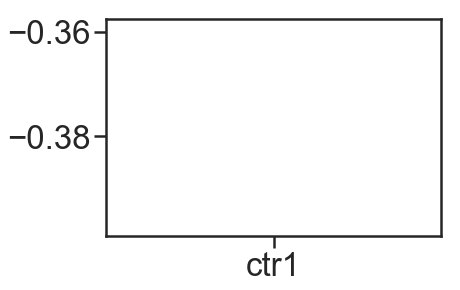

166et479right


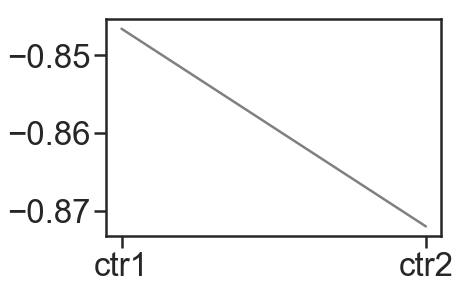

175et013left-2


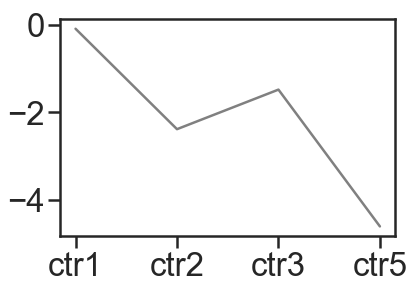

18et484left


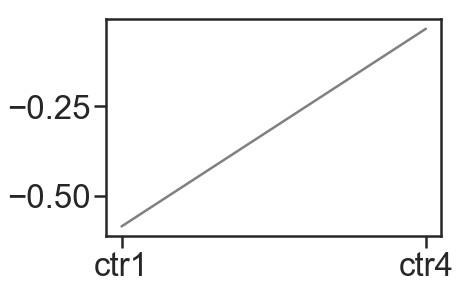

18etW01left-1


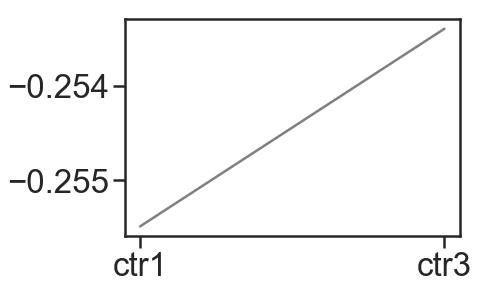

19et479left


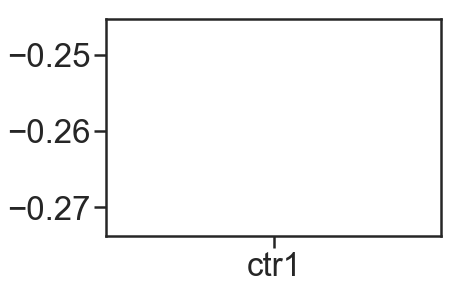

1etW01left-1


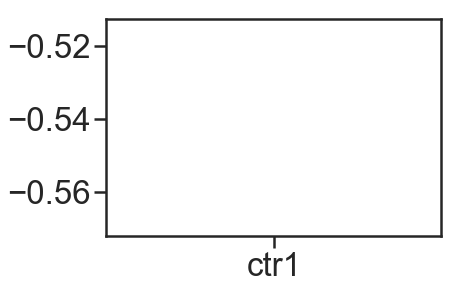

20et019right-1


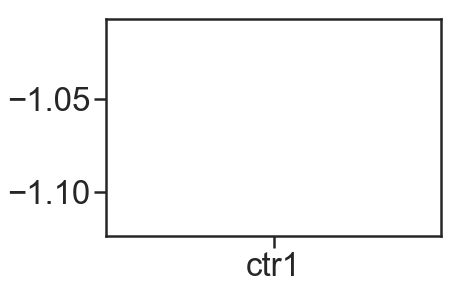

22et029left-1


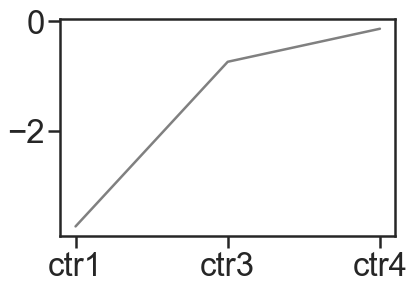

23et029left-1


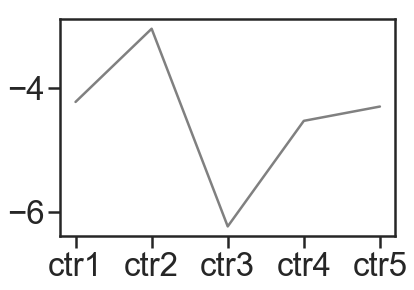

25etW01left-1


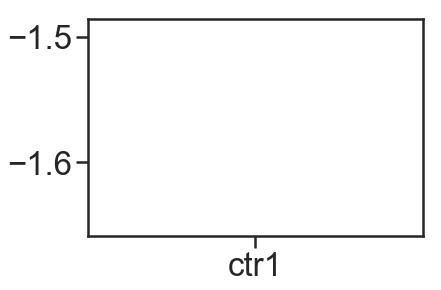

27etW02left-1


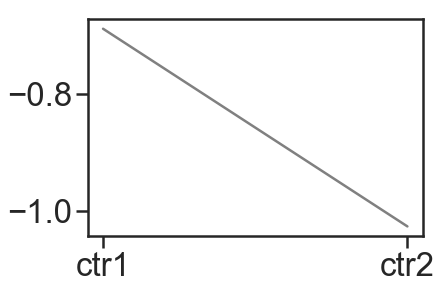

30et484left


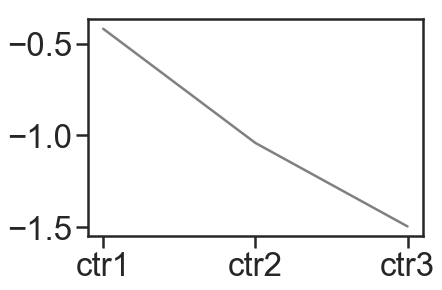

43etW00left-1


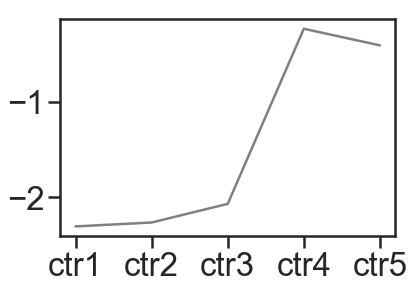

44et023right-1


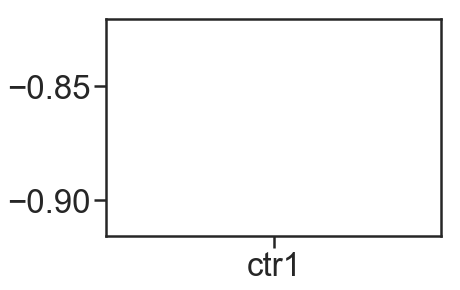

45etW02left-1


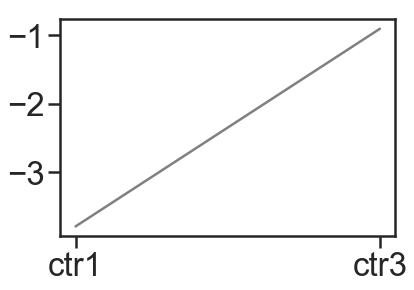

45etW03left-1


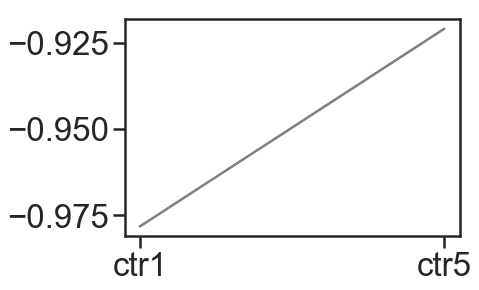

49et013left-2


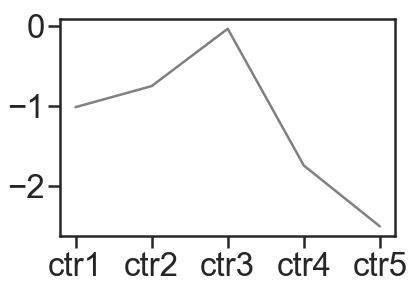

52et035left-1


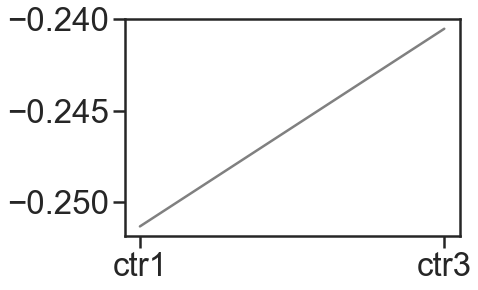

58et483right


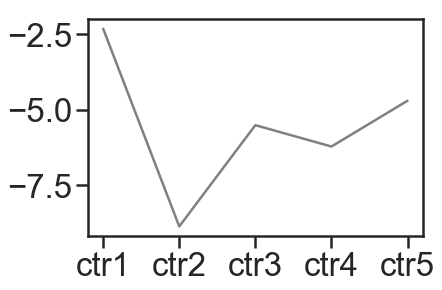

5et017right-1


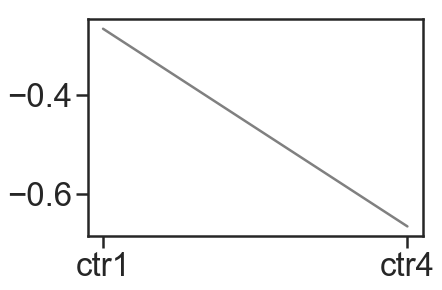

5et479right


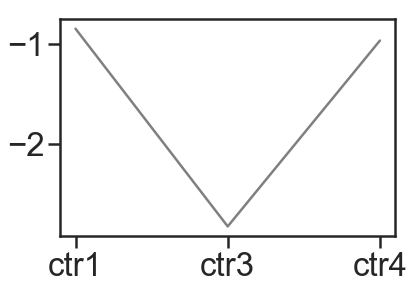

61et483left


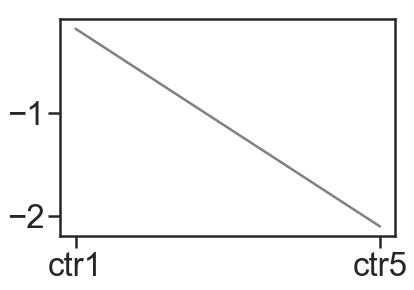

65et020left-2


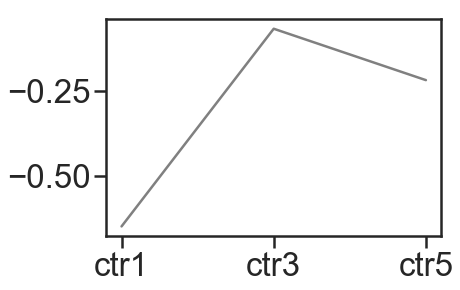

69et023right-1


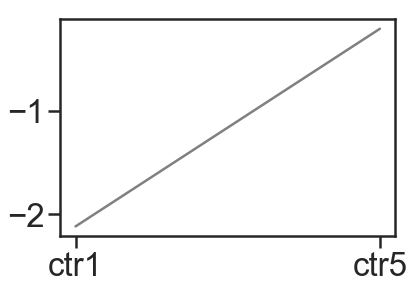

72et019left-2


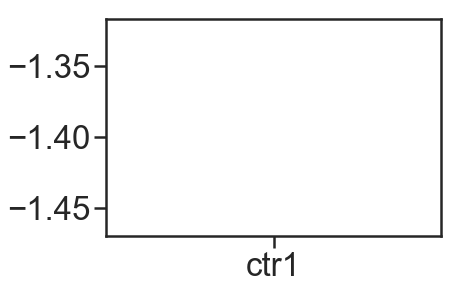

72et484left


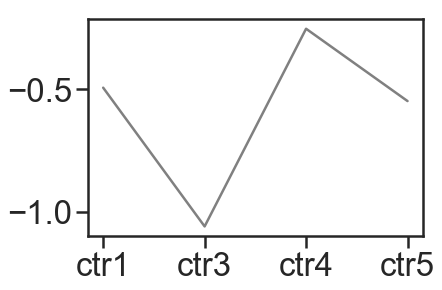

75et019right-1


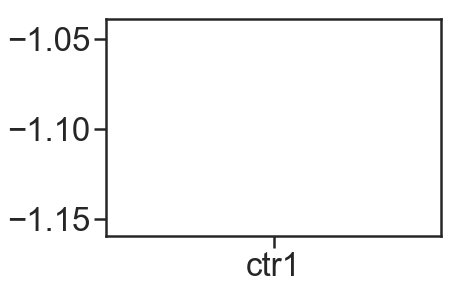

80etW01left-1


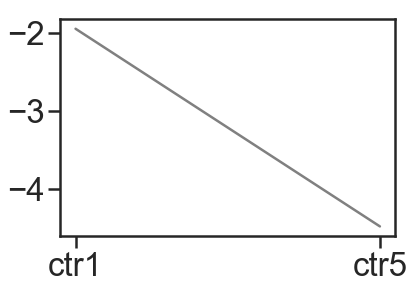

82et485left


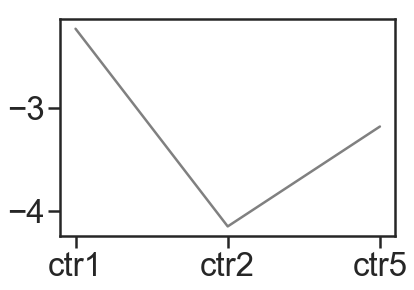

85et484left


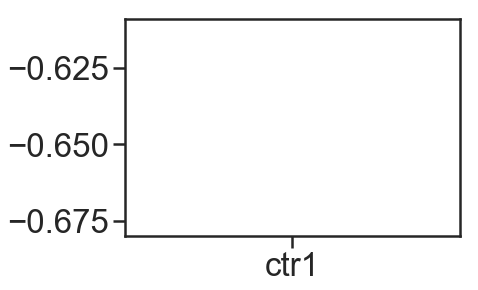

87et483right


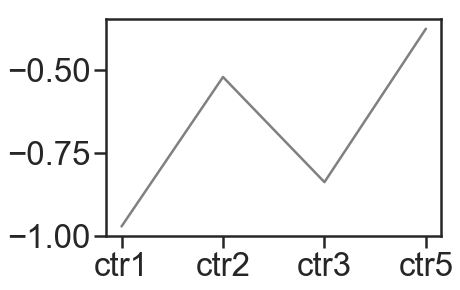

89et019right-1


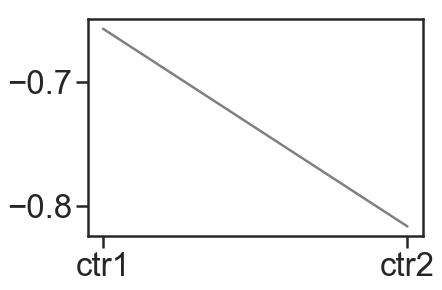

8et479left


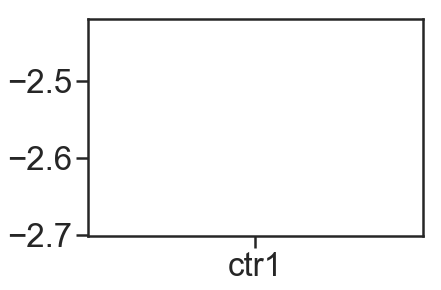

92et029left-1


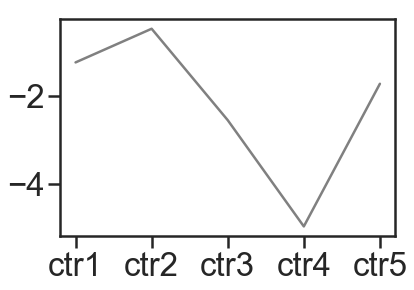

94et479left


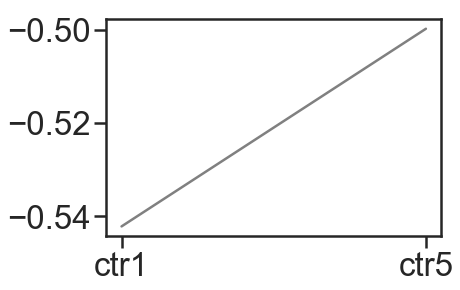

94et483right


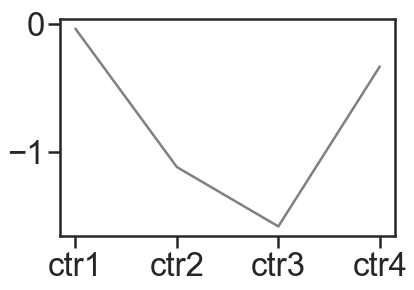

9et019right-1


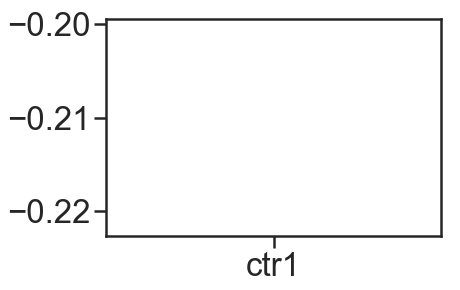

106et023left-2


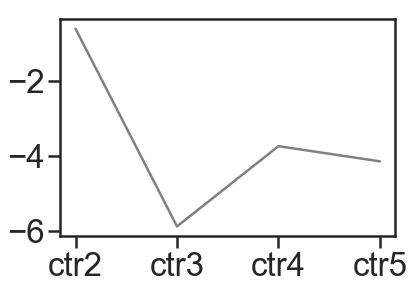

141et484left


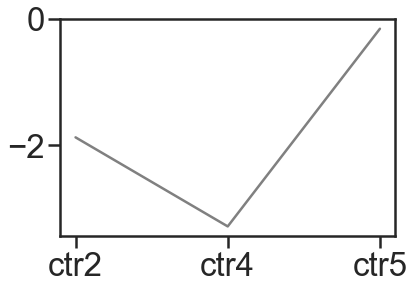

14etW03left-1


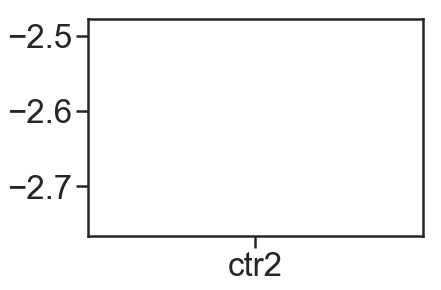

154et013left-2


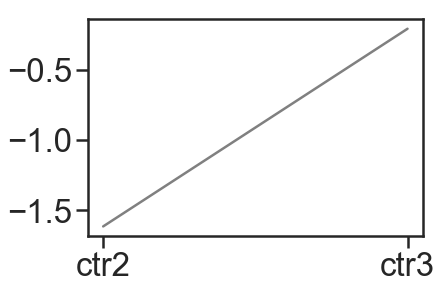

155et019right-1


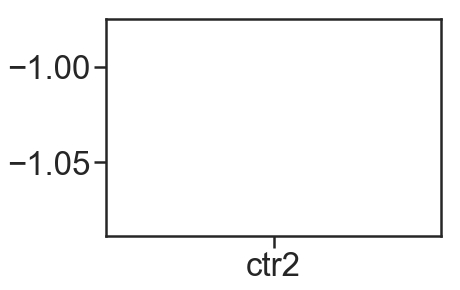

16etW02left-1


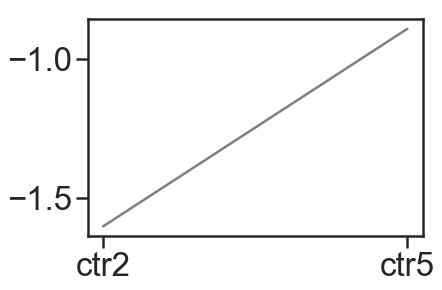

180etW00left-1


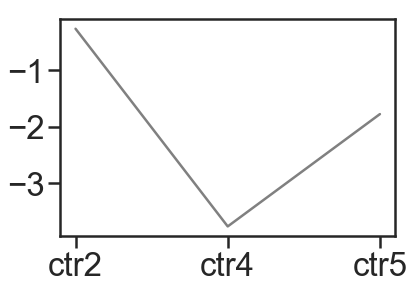

185et029left-1


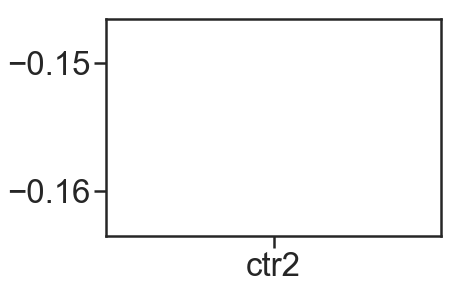

19etW03left-1


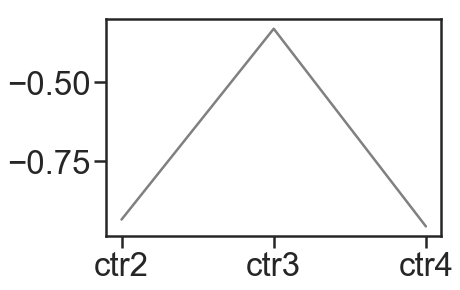

1et483left


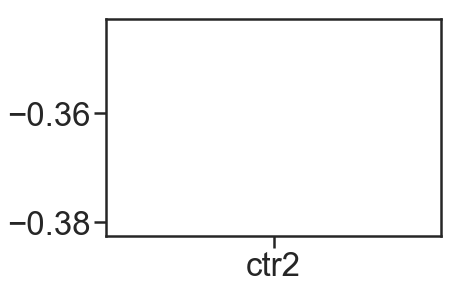

22et020right-1


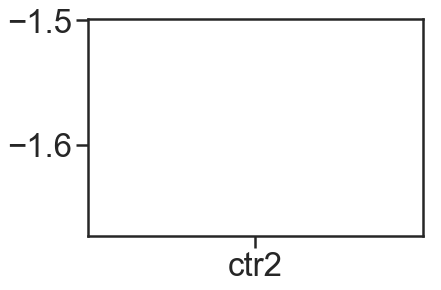

26et479right


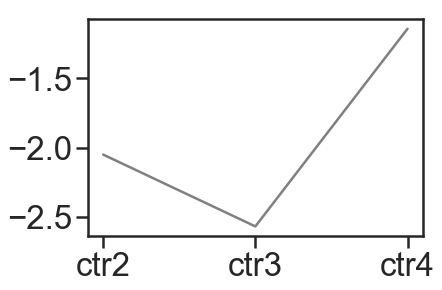

3et020left-2


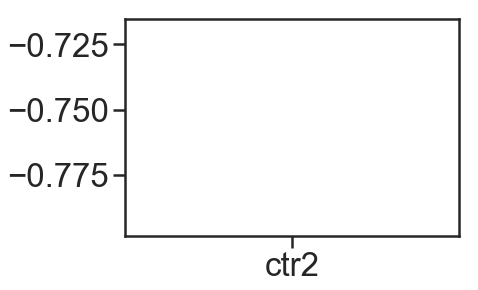

3etW00left-1


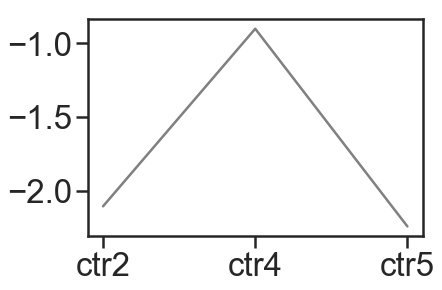

43et020left-2


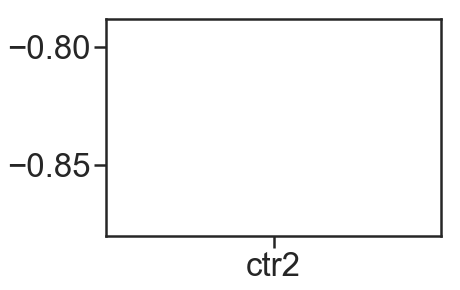

46etW00left-1


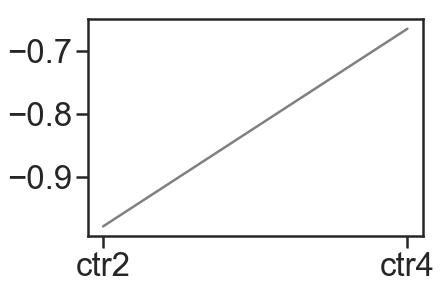

49et029left-1


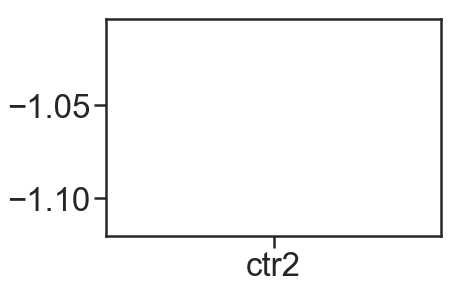

54et017right-1


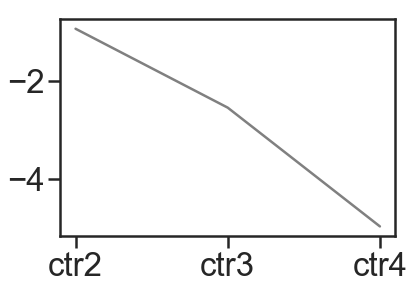

54etW00left-1


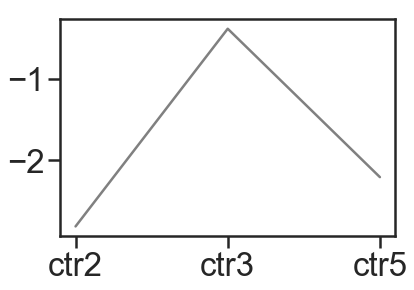

56et017left-2


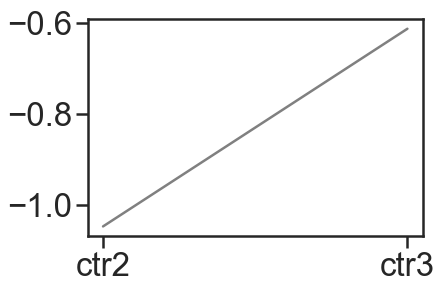

66et023left-2


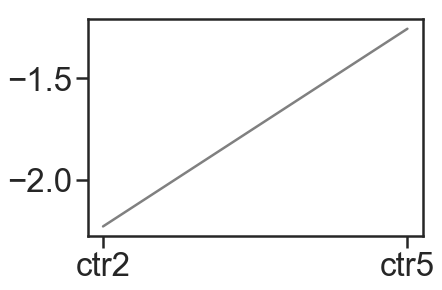

67et484left


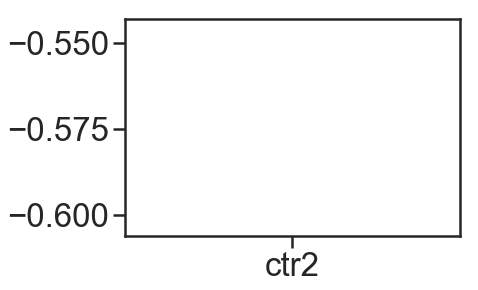

68et483right


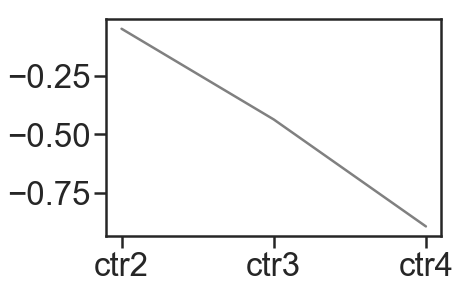

69et017right-1


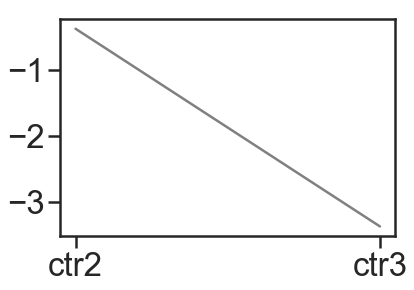

6et017right-1


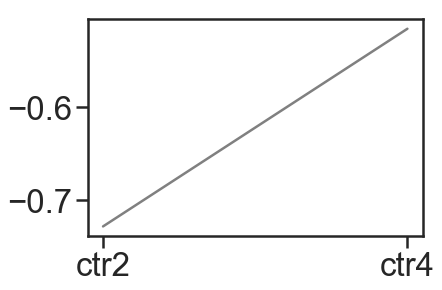

6et479right


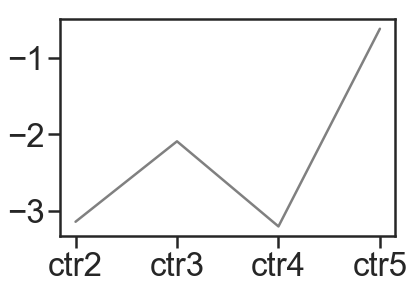

70etW01left-1


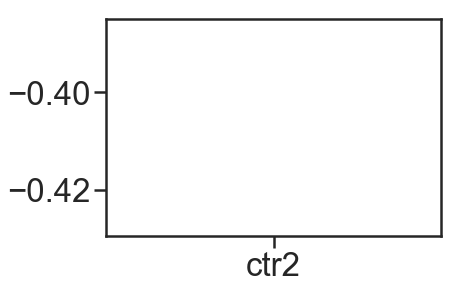

81et479right


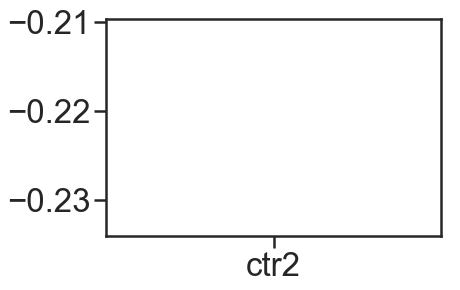

86et479left


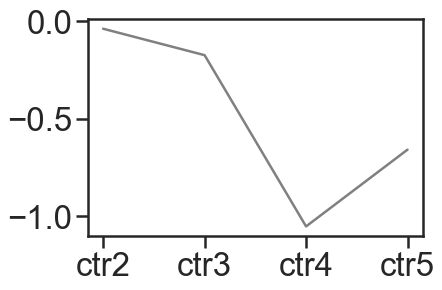

8etW01left-1


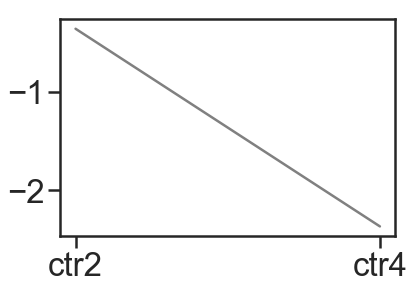

93et019left-2


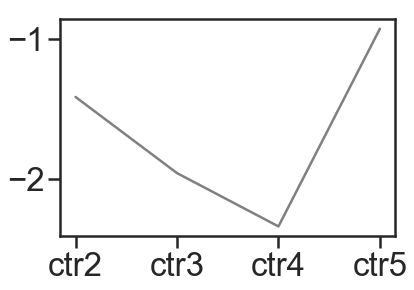

99et019left-2


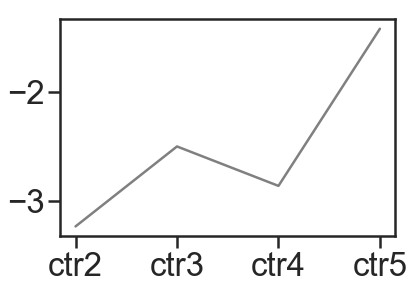

106et029left-1


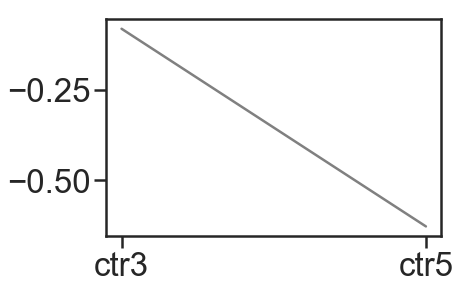

10et023right-1


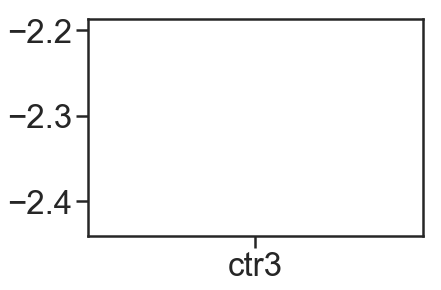

126et020right-1


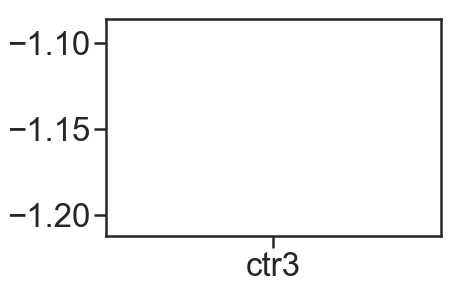

12et035left-1


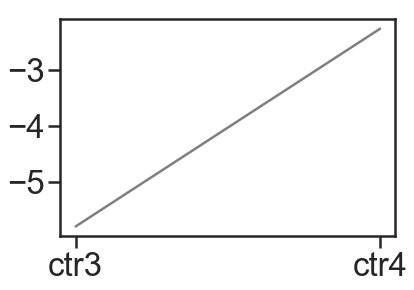

146et479left


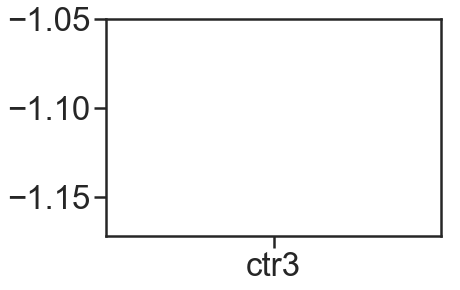

16et017left-2


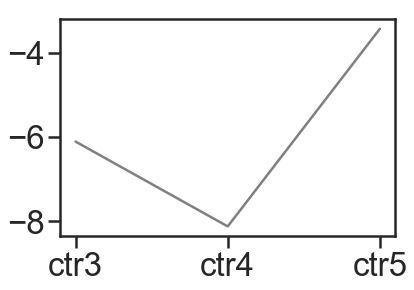

180et483left


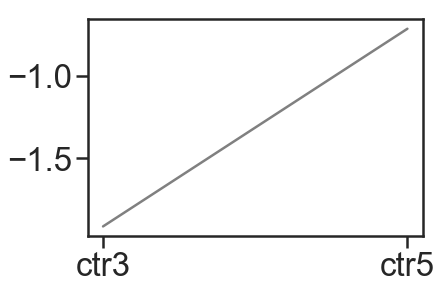

190et023left-2


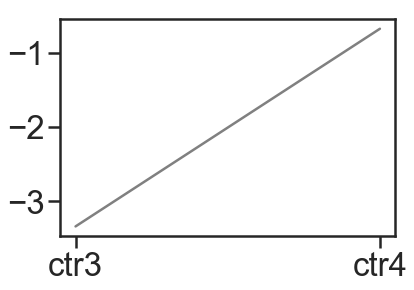

193et023left-2


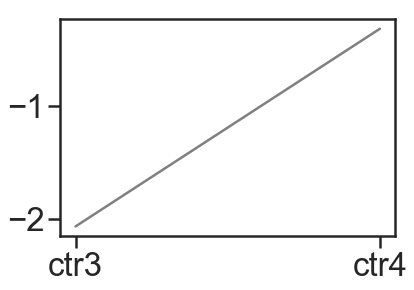

25et029left-1


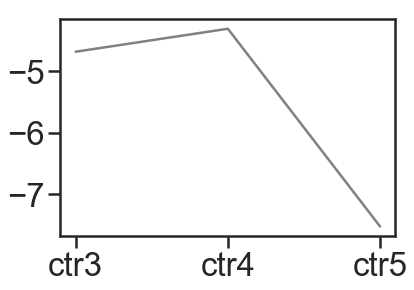

28et035left-1


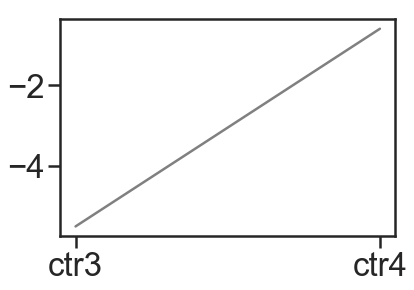

2et017right-1


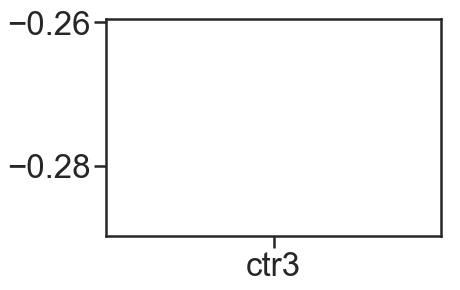

31et479right


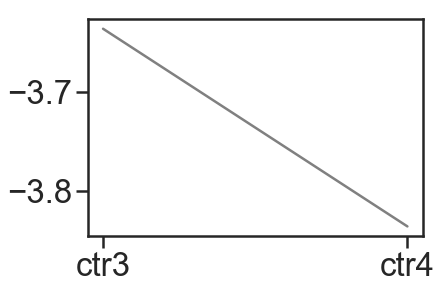

36et020right-1


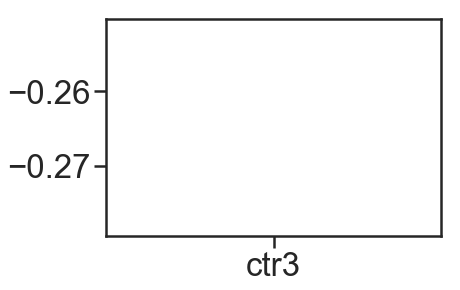

41et479right


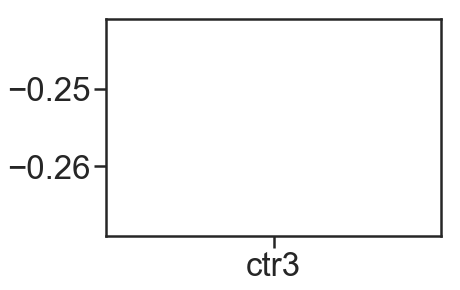

53et019left-2


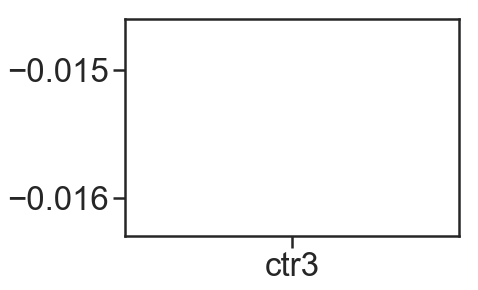

56et020left-2


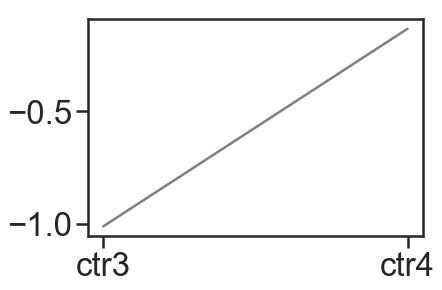

78et029left-1


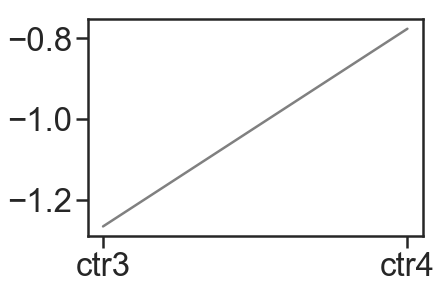

79et017left-2


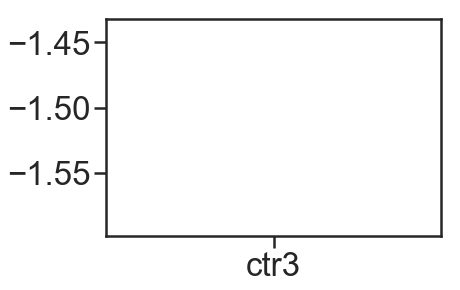

85et023left-2


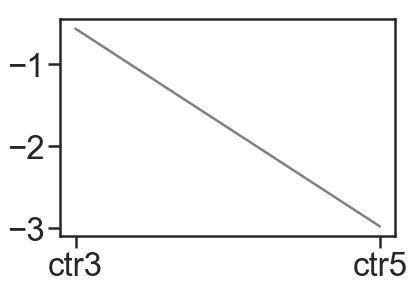

99et020left-2


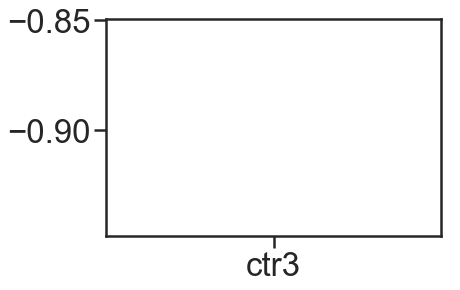

113et019left-2


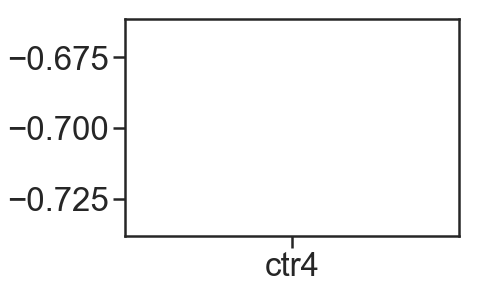

114etW01left-1


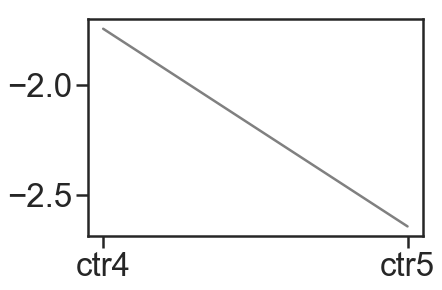

115et017right-1


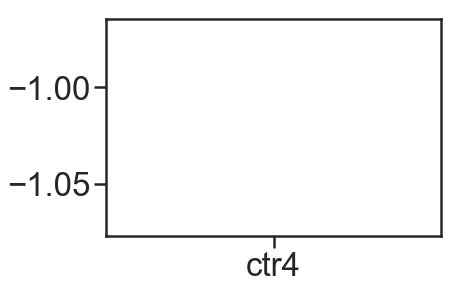

119et019left-2


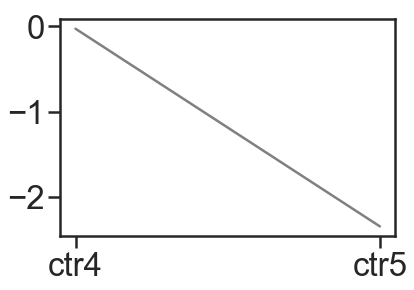

11et484left


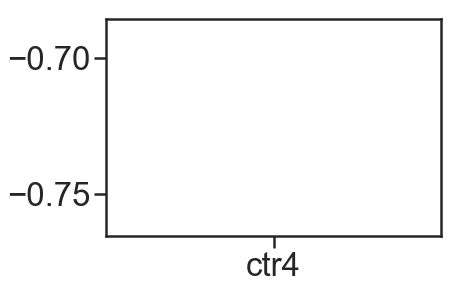

136et017right-1


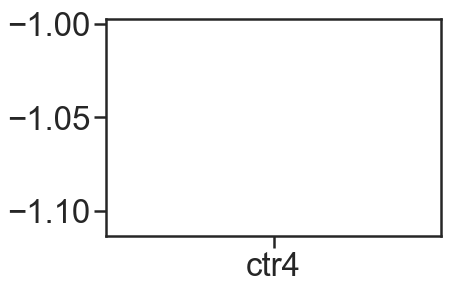

149et017right-1


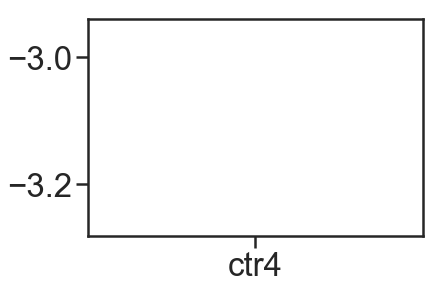

14et029left-1


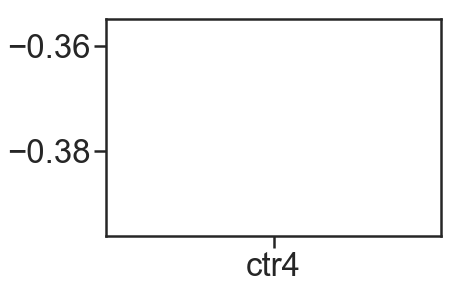

15et035left-1


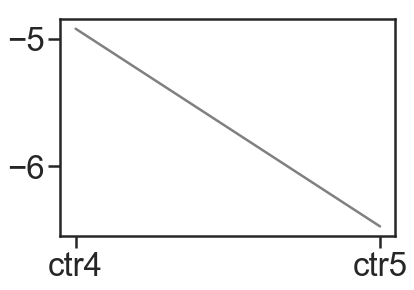

194et023left-2


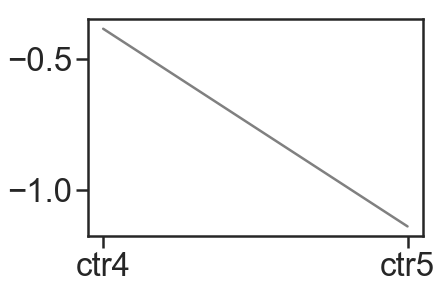

23et483right


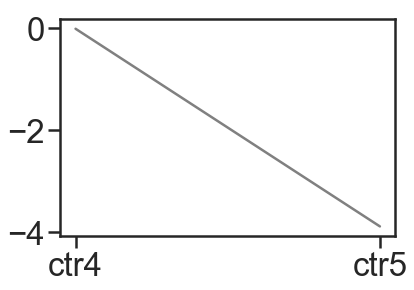

23etW01left-1


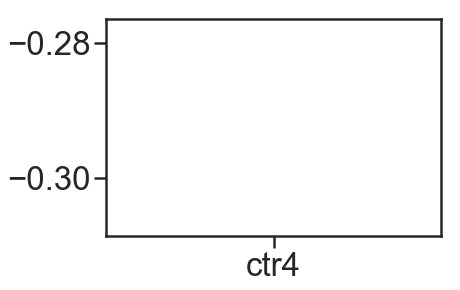

2et035left-1


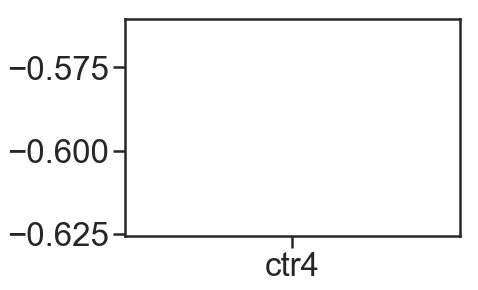

32et017right-1


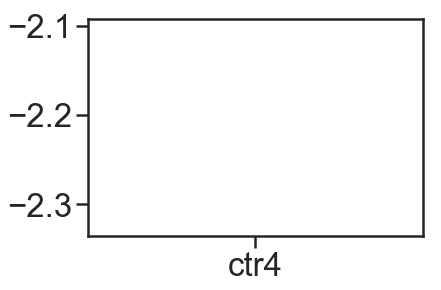

39et019left-2


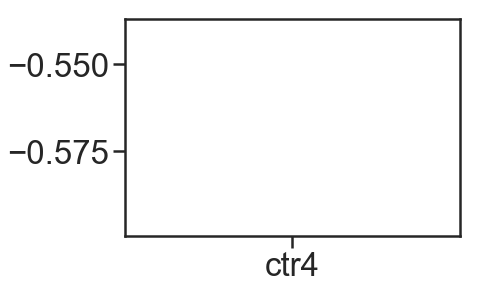

3et017right-1


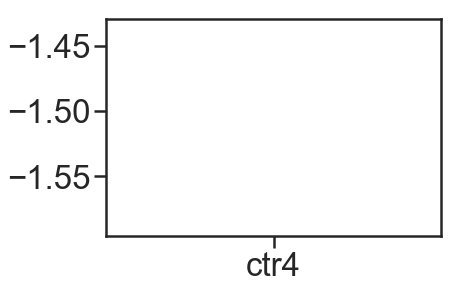

4et479right


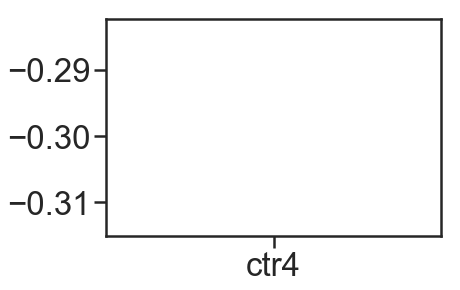

61et029left-1


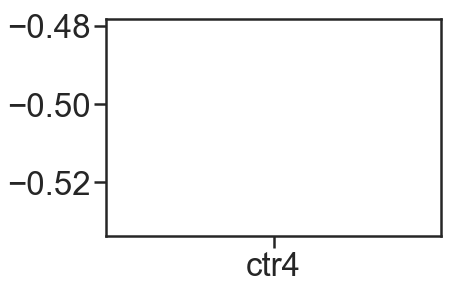

6et020left-2


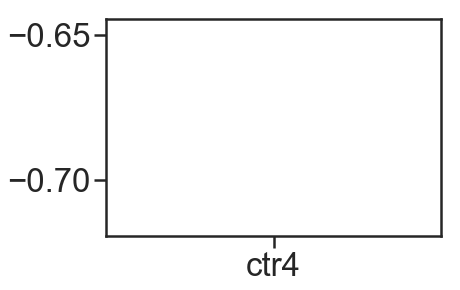

77etW03left-1


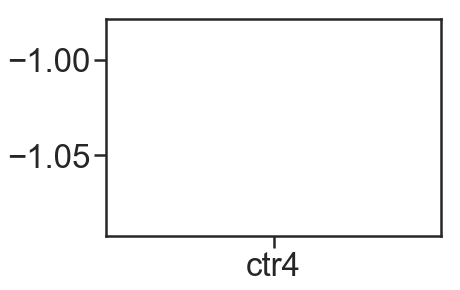

88et013left-2


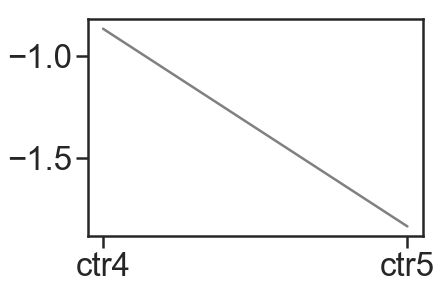

88et479right


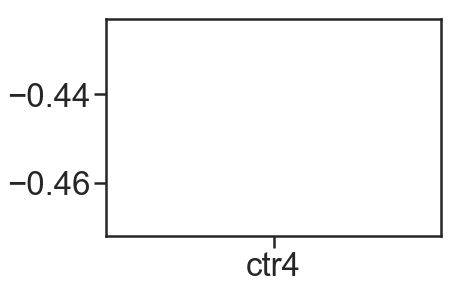

93et029left-1


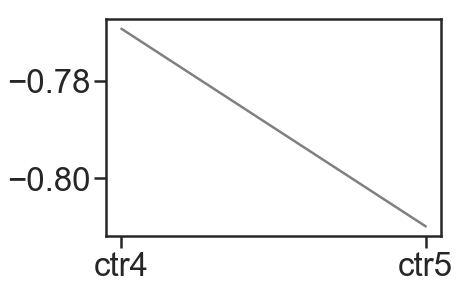

98etW02left-1


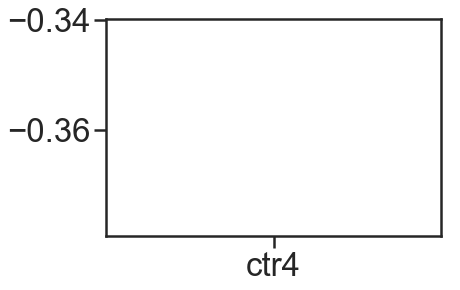

0et019left-2


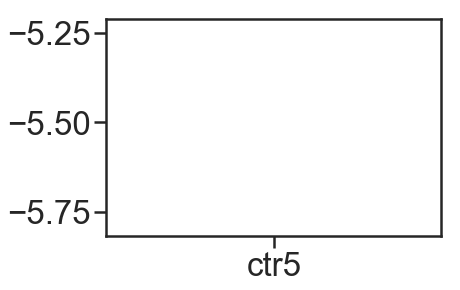

11et035left-1


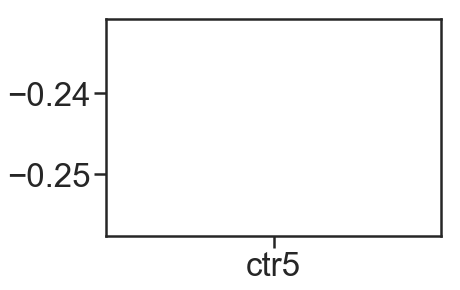

15et029left-1


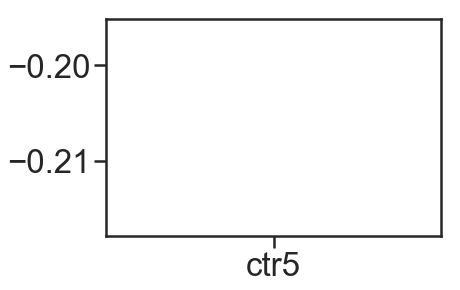

1et020right-1


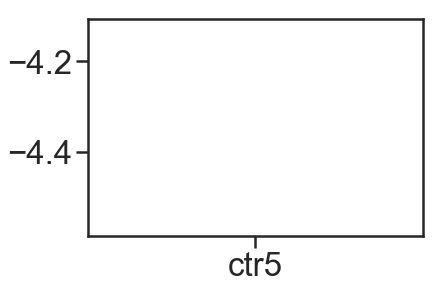

21et013left-2


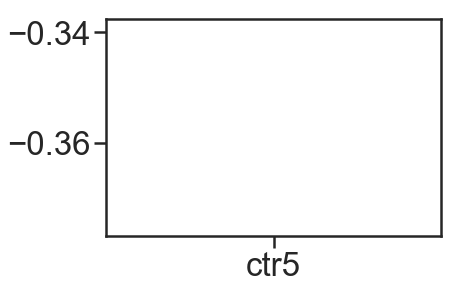

29et017left-2


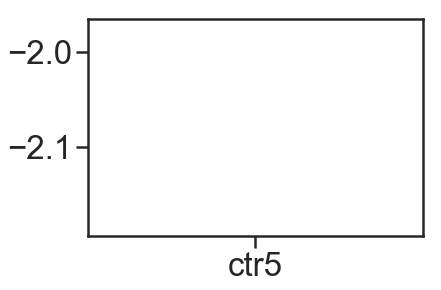

32et483right


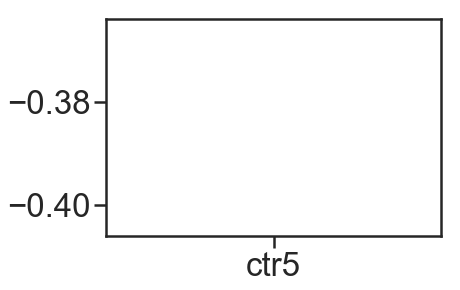

38et029left-1


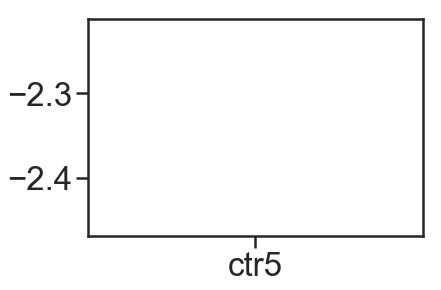

43et020right-1


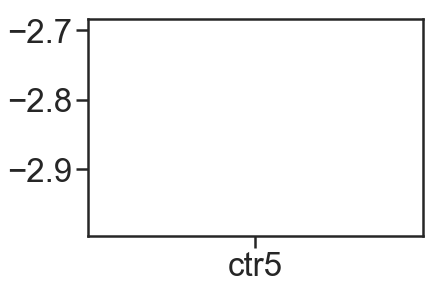

45et020right-1


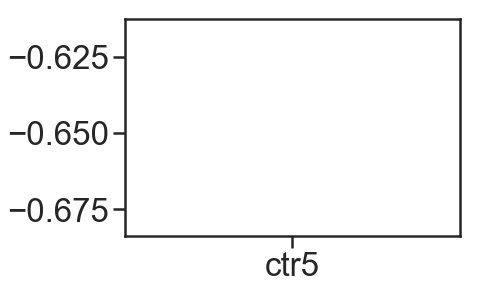

4et483left


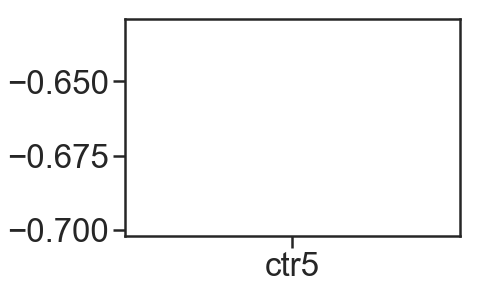

61etW00left-1


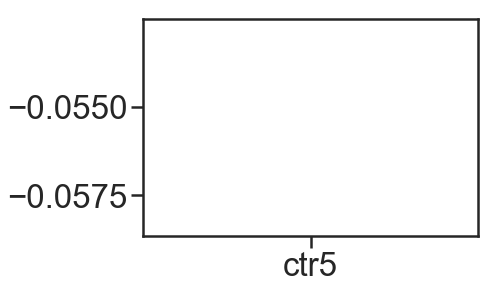

6et485left


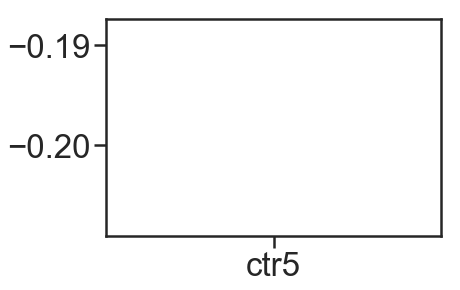

7et029left-1


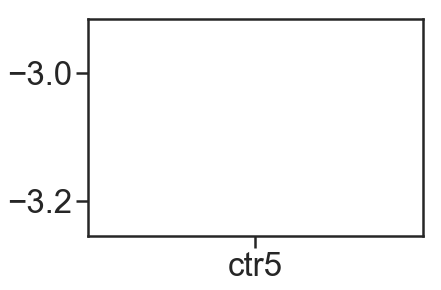

91et020right-1


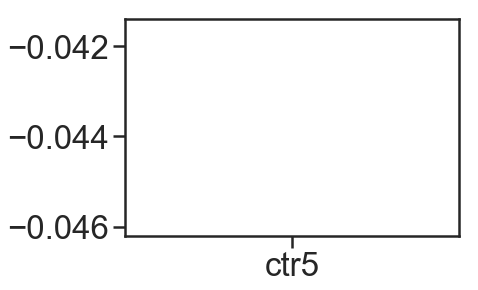

In [574]:
tmp = fig_inp[(fig_inp.group == 'wt') & (fig_inp.bc_fr < 0)].dropna()
for unit in tmp.cluster_id.unique()[0:]:
    print unit
    tmp2 = tmp[tmp.cluster_id == unit]
    plt.plot(tmp2.stim1, tmp2.bc_fr, c = 'gray')
#     plt.title(tmp2.pref.unique()) 
#     plt.ylim(0, 30)
    plt.show()
#     break

In [23]:
opto_df.head()

Hz  abs_times     cluster_id  \
2064500  2.226960       0.00  160et482right   
2064501  2.459360       0.01  160et482right   
2064502  2.720907       0.02  160et482right   
2064503  2.964181       0.03  160et482right   
2064504  3.121891       0.04  160et482right   

                                      cuid  depth   et    paradigm  \
2064500  160et482rightet482chirpopto_chirp    800  482  opto_chirp   
2064501  160et482rightet482chirpopto_chirp    800  482  opto_chirp   
2064502  160et482rightet482chirpopto_chirp    800  482  opto_chirp   
2064503  160et482rightet482chirpopto_chirp    800  482  opto_chirp   
2064504  160et482rightet482chirpopto_chirp    800  482  opto_chirp   

                                                      path   side  stim1  \
2064500  U:\Data\pak6\OpenEphys\probe_64DB\Thy1_FX\sf-v...  right  chirp   
2064501  U:\Data\pak6\OpenEphys\probe_64DB\Thy1_FX\sf-v...  right  chirp   
2064502  U:\Data\pak6\OpenEphys\probe_64DB\Thy1_FX\sf-v...  right  chirp   
2064503  U:\Data\pak6\OpenEphys\probe_64DB\Thy1_FX\sf-v...  right  chirp   
2064504  U:\Data\pak6\OpenEphys\probe_64DB\Thy1_FX\sf-v...  right  chirp   

         times    zscore       ztc group  r_groups n_type  
2064500   0.00 -1.014482 -2.823472    fx         2     fs  
2064501   0.01 -0.941255 -2.369883    fx         2     fs  
2064502   0.02 -0.858843 -1.859405    fx         2     fs  
2064503   0.03 -0.782190 -1.384593    fx         2     fs  
2064504   0.04 -0.732496 -1.076780    fx         2     fs

### K-means clustering

In [43]:
opto_df = data
time_idx = np.arange(100,600)
key_pca = 'r_groups'
opto_df, _ = ena.unit_kmeans(opto_df, 4, 'abs_times', 'cluster_id', key_pca, time_idx)
opto_df = opto_df[(opto_df.r_groups < 5)]
opto_df['n_type'] = opto_df.cluster_id.map(neuron_type)
# opto_df['pref'] = opto_df.cluster_id.map(pref_d)


[0.3124301  0.09931446 0.06431444 0.04728225]


In [130]:
time_idx = np.arange(6)
key_pca = 'r_groups'
tmp = fig_inp
tmp, kmeans_groups = ena.unit_kmeans(tmp, 6, 'stim1', 'cluster_id', 'norm', key_pca, time_idx)
tmp.head()

[0.31061445 0.21495332 0.15088739 0.13745108 0.11825506 0.0678387 ]


group layer       cluster_id stim1         Hz  abs_times  depth  times  \
6272    wt  l2/3   100et017left-2  ctr0  14.656420      0.425    650  0.425   
6278    wt  l2/3   100et019left-2  ctr0   4.215580      0.425    650  0.425   
6284    wt  l2/3  100et019right-1  ctr0   1.526862      0.425    650  0.425   
6290    wt  l2/3  100et020right-1  ctr0   2.245629      0.425    650  0.425   
6306    wt  l2/3   101etW00left-1  ctr0   7.819721      0.425    850  0.425   

        zscore        ztc      bc_fr      norm  r_groups  
6272  1.815648  16.266376  12.002093  0.080985         2  
6278 -0.424900   0.247803   0.105421  0.028935         5  
6284 -0.661734  -0.957307  -0.522623  0.000000         5  
6290 -0.616835   1.602695   0.550053  0.082295         1  
6306  2.027182  16.564640   6.829668  0.000000         3

### Elbow method

In [143]:
from sklearn import metrics
from scipy.spatial.distance import cdist

C:\Users\Chub_lab\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Text(0.5,1,u'The Elbow Method showing the optimal k')

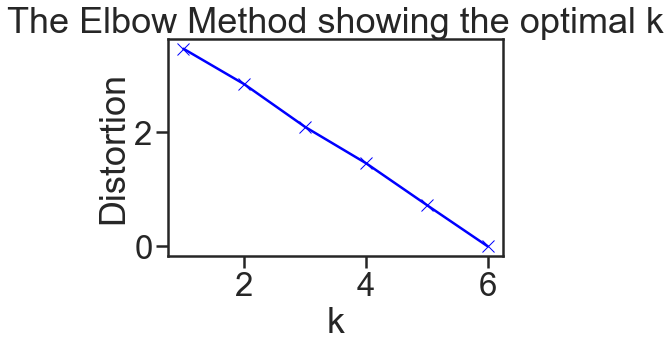

In [178]:
tmp = fig_inp
df_new = tmp.pivot(index= 'cluster_id', columns= 'stim1', values= 'norm')
time_idx = np.arange(0, 100)
df_new = df_new.reset_index().drop( 'cluster_id',1)
# df_new = df_new.dropna()
df_new = df_new.T
df_new = df_new.dropna()
X = df_new.ix[:,time_idx].values #0.5-2 second interval
y = df_new.index.values.tolist() # corresponding cuid

distortions = []
K = range(1,7)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
# plt.savefig('elbow_method_kmeans.pdf', transparent = True)

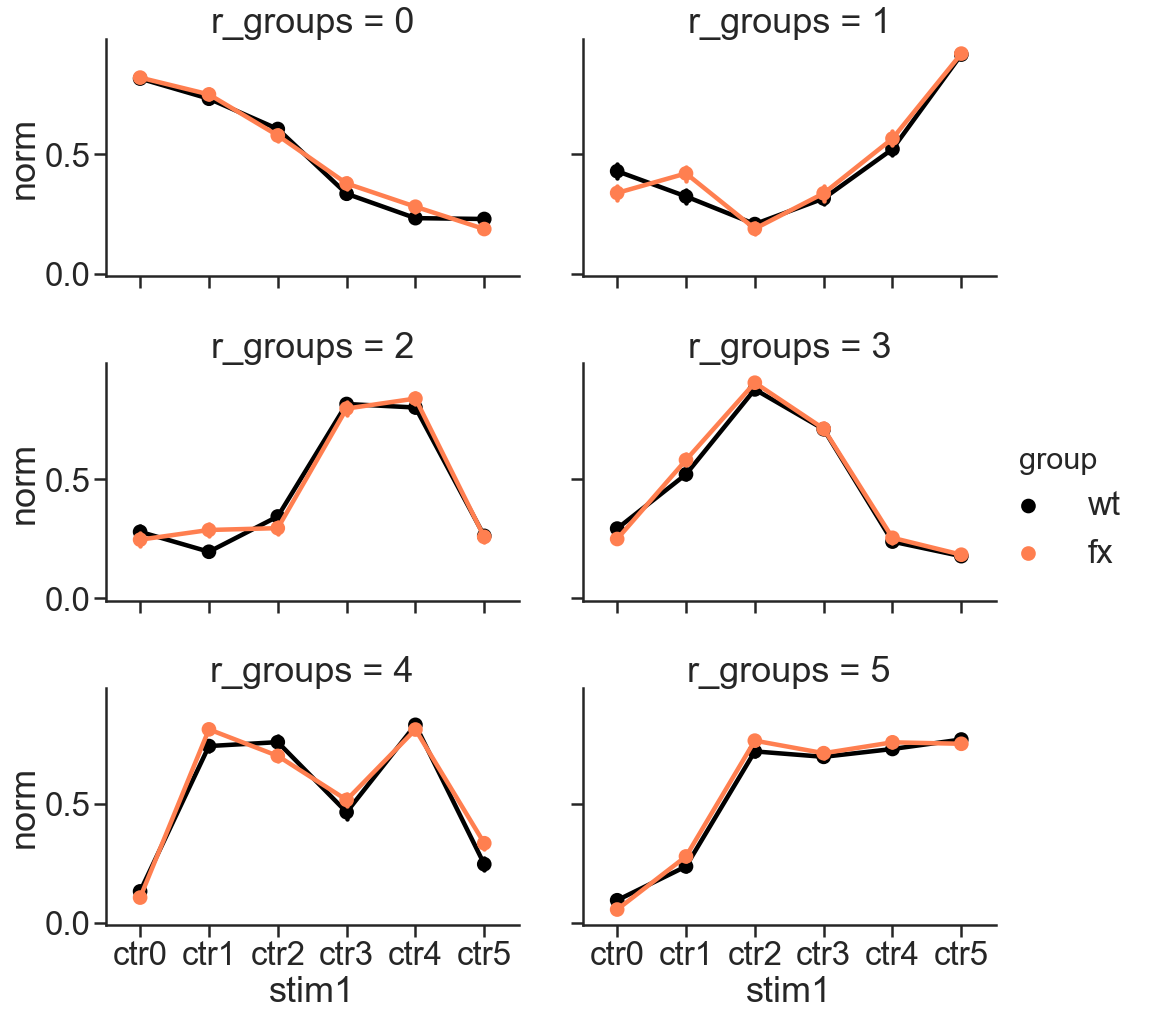

In [177]:
ax = sns.catplot(x="stim1", y = "norm", data = tmp, kind = 'point', ci = 68, hue= 'group',
                    palette = ['k', 'coral'], 
#                    capsize = 0.02, saturation = 1,
                   height = 5, aspect=1.5,
                col = 'r_groups', col_wrap = 2,
                )

In [303]:
df_odd['sf_groups'] = df_odd.cluster_id.map(kmeans_groups)

In [304]:
df_odd.sf_groups.unique()

array([ 0.,  3.,  4., nan,  2.,  5.,  1.])

(0, 40)

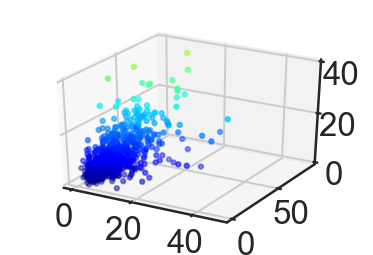

In [465]:
ax = plt.axes(projection='3d')
tmp = df_odd[(df_odd.times > 0.35) & (df_odd.times < 0.8) & (df_odd.group == 'fx')].groupby(['cluster_id', 'stim1']).mean().reset_index()
# Data for a three-dimensional line
zline = tmp[tmp.stim1 == 'ctr2'].groupby('cluster_id').Hz.mean().values
xline = tmp[tmp.stim1 == 'std3'].groupby('cluster_id').Hz.mean().values
yline = tmp[tmp.stim1 == 'dev9'].groupby('cluster_id').Hz.mean().values
# ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points

ax.scatter3D(xline, yline, zline, c = zline, cmap='jet');
ax.set_zlim(0, 40)


In [306]:
cond = 'r_groups'
gr = df_odd[
              (df_odd.resp_sig == 'exc') 
            & (df_odd.pref > -1) 
#             & (df_odd.pref == 2) 
             & (df_odd.group == 'wt') 
            ]

# gr = gr.dropna()
exc_units = gr.cluster_id.unique()
gr = df_tuning[df_tuning.cluster_id.isin(exc_units)]
# gr = opto_df
n = int(gr[cond].unique().size)
# gr = gr[(gr.stim1.str.contains('0'))]


f, ax = plt.subplots(n, sharex=True,figsize = (3,12))

# cbar_ax = f.add_axes([.91, .3, .03, .5])
sns.set_style("ticks")
for idx, val in enumerate(sorted(gr[cond].unique())):
    tmp = gr[gr[cond] == val]
#     tmp = df_psth[(df_psth.paradigm == 'opto_chirp')  & (df_psth.cluster_id.isin(tmp.cluster_id.unique()))]
    tmp = tmp.pivot('cluster_id', 'stim1', 'bc_fr').dropna()
    tmp2 = tmp.values[ np.argsort(tmp['ctr' + str(int(val))].values )]
    g = sns.heatmap(tmp2, cmap = 'jet',  
                 ax = ax[idx], xticklabels=200, yticklabels=False, vmax = 30,  vmin = 0, robust = True,
#                 cbar=idx == 0, cbar_ax=None if idx else cbar_ax,
                   cbar = False)
    ax[idx].set(xlabel='', ylabel=tmp.index.size )
    
#     ax[i].set_title('Cluster group ' + str (i+1), loc = 'left') 
f.subplots_adjust(hspace=0.2) 
# ax[0].set_title(str(gr.stim1.unique()[0])  )
# plt.savefig('hm-sf-tuning-fx.png')

KeyError: 'r_groups'

### Computed SSA, DD, and MM

In [44]:
df_odd = 0
# good_units -> neurons that have responses to all stimuli
data = df_vmmn[(df_vmmn.cluster_id.isin(good_units))]
data = data[ (data.paradigm.str.contains('odd')) | (data.stim1.str.contains('ctr2'))]

data['pref'] = data.cluster_id.map(pref_d)
data['n_type'] = data.cluster_id.map(neuron_type)
df_odd = data.reset_index().groupby('cluster_id').apply(get_mmn_idx)
df_odd.stim1.unique()

array(['ctr2', 'std3', 'dev9'], dtype=object)

### Add fit_pref column

In [45]:
tmp = df_tuning[df_tuning.fit_err < 0.9]
d_tmp = dict(zip(tmp.cluster_id, tmp.fit_pref.round(4)))
df_odd['fit_pref'] = df_odd.cluster_id.map(d_tmp)
df_odd['q_factor'] = df_odd.cluster_id.map(d_qfactor)
df_odd['n_type'] = df_odd.cluster_id.map(neuron_type)
conditions = [
    (df_odd['fit_pref'] >= 0.015) & (df_odd['fit_pref'] <= 0.06),
    (df_odd['fit_pref'] < 0.015) | (df_odd['fit_pref'] > 0.06),
    (df_odd['fit_pref'].isnull())]
choices = ['in_odd', 'out_odd', 'untun']
df_odd['tun_group'] = np.select(conditions, choices)

In [46]:
df_odd[(df_odd.abs_times == 0.5) & (df_odd.resp_sig == 'exc')].groupby([ 'tun_group', 'group' , 'layer']).cluster_id.count()

tun_group  group  layer
in_odd     fx     l2/3      60
                  l4        64
                  l5/6      62
           wt     l2/3      95
                  l4        76
                  l5/6      81
out_odd    fx     l2/3      74
                  l4        99
                  l5/6     107
           wt     l2/3     116
                  l4       103
                  l5/6     131
untun      fx     l2/3      54
                  l4        52
                  l5/6      71
           wt     l2/3      79
                  l4        93
                  l5/6      89
Name: cluster_id, dtype: int64

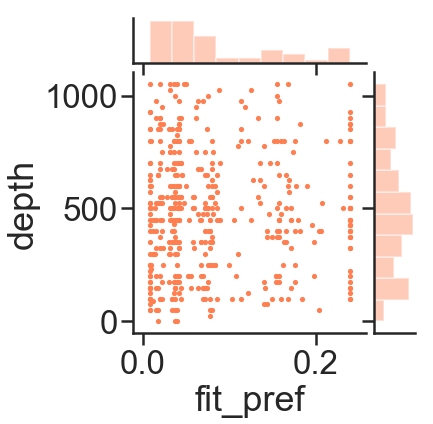

In [72]:
tmp = df_odd[(df_odd.tun_group != 'untun') 
             & (df_odd.resp_sig == 'exc')
            & (df_odd.group == 'fx')
            ].groupby(['group','cluster_id']).mean().reset_index()

g = sns.jointplot(data = tmp, x = 'fit_pref', y= 'depth',  
                    color = 'coral', height = 6, s = 10
              )
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# g.set_axis_labels('ssa', 'dd')
# plt.xlim(-0.01, 0.25)
# plt.ylim(-1,1)
# plt.axvline(x= 0.03, linestyle = '--')
# plt.axhline(y= 0, linestyle = '--')
sns.despine()
# plt.savefig('scatter_fitpref_depth_fx.png')

In [136]:
df_odd['q_factor'] = df_odd.cluster_id.map(d_qfactor)

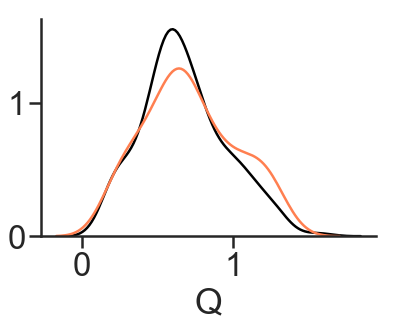

In [140]:
val = 'q_factor'
tmp = df_odd[(df_odd.abs_times == 0.5) 
             & (df_odd.resp_sig == 'exc' )
#              & (df_odd.tun_group == 'out_odd')
            ].groupby(['group','cluster_id']).mean().reset_index()

x = tmp[tmp.group == 'wt'][val].dropna().values
x2 = tmp[tmp.group == 'fx'][val].dropna().values

sns.kdeplot(x, cumulative=False,  color = colors_group[0])
sns.kdeplot(x2, cumulative=False,  color = colors_group[1])

# ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
# plt.axvline(400, linestyle = '--' , color='gray')
# plt.axvline(600, linestyle = '--', color='gray')
# plt.axvline(0.03, color = 'crimson')
plt.xlabel('Q')
# plt.xlim(-300, 1300)
sns.despine()
plt.savefig('dist_qfactor.pdf')

In [141]:
print len(x), len(x2)
print sstat.ks_2samp(x, x2)

192 126
Ks_2sampResult(statistic=0.10069444444444442, pvalue=0.4044005963838752)


In [1688]:
# df_opto = df_vmmn[ (df_vmmn.paradigm.str.contains('chirp')) ]
# df_opto = df_opto.groupby('cluster_id').apply(get_opto_resp)

high_ztc_units = df_opto[df_opto.ztc > 400].cluster_id.unique()
df_opto = df_opto[~(df_opto.cluster_id.isin(high_ztc_units))]

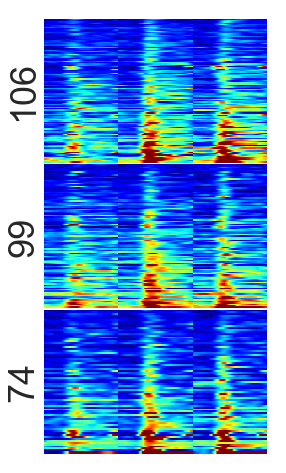

In [51]:
cond = 'layer'

gr = df_odd[ (df_odd.resp_sig == 'exc') 
            & (df_odd.tun_group == 'out_odd') 
            & (df_odd.group == 'fx')
#             & (df_odd.n_type == 'fs')
            ]
# gr = gr[ (gr.fit_pref < 0.015) 
#             | (gr.fit_pref > 0.06) 
#             ]
# gr = gr[gr.fit_pref.isnull()]


# gr = gr.dropna()
gr = gr[(gr.times > 0.1) & (gr.times < 0.9)]
# gr = opto_df[(opto_df.group == 'wt') & (opto_df.r_groups == 1)]
n = int(gr[cond].unique().size)
# gr = gr[(gr.stim1.str.contains('0'))]

plt.figure(figsize = (4,8))
gs1 = mpl.gridspec.GridSpec(3, 1)
gs1.update(wspace=0.025, hspace=0.01) # set the spacing between axes. 

# f, ax = plt.subplots( n, sharex=True,figsize = (6,8))

# cbar_ax = f.add_axes([.91, .3, .03, .5])
sns.set_style("ticks")
for idx, val in enumerate(sorted(gr[cond].unique(), reverse=True)):
    
    ax = plt.subplot(gs1[idx])
    tmp = gr[gr[cond] == val]
#     tmp = df_psth[(df_psth.paradigm == 'opto_chirp')  & (df_psth.cluster_id.isin(tmp.cluster_id.unique()))]
    tmp = tmp.pivot('cluster_id', 'abs_times', 'Hz').dropna()
    tmp2 = tmp.values[ np.argsort(np.mean(tmp.values[:,100:200], axis = 1) )]
    g = sns.heatmap(tmp2, cmap = 'jet',  cbar = False,
                 ax = ax, xticklabels = False, yticklabels=False, vmax = 30,  vmin = 0, robust = True,
#                 cbar=idx == 0, cbar_ax=None if idx else cbar_ax,
                   )
    ax.set(xlabel='', ylabel=tmp.index.size )
    
#     ax[i].set_title('Cluster group ' + str (i+1), loc = 'left') 
f.subplots_adjust(hspace=0.2) 
# ax[0].set_title(str(gr.stim1.unique()[0])  )
# plt.savefig('hm_opto_exc_fx.png')

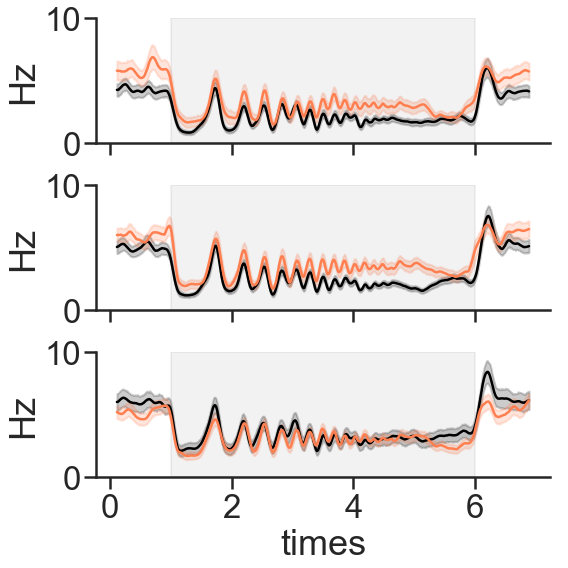

In [1731]:
zsc = 'Hz'
cond = 'layer'
# gr = df_out
# gr = df_out
f, ax = plt.subplots(3, sharex=True, sharey=False, figsize = (8,8))
# ts_input = data
ts_input = gr[(gr.times > 0.1) & (gr.times < 6.9)]
# y_limits = [(-1, 30), (-1, 25), (-1, 25), (-1, 30), (-1, 25), (-1, 20) ]
for idx, val in enumerate(sorted(gr[cond].unique(), reverse=False)):
    tmp = ts_input[ts_input[cond] == val]
#     tmp = tmp[tmp.n_type == 'rs']
    tmp = tmp.sort_values(by = ['group'], ascending=False)
    sns.lineplot(data = tmp, x = 'times', y = zsc,  ci = None, hue= 'group',
        estimator=np.nanmean, ax = ax[idx],  legend = False, palette = colors_group,
              )
    ax[idx].set_ylim(0, 10)
#     ax[idx].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax[idx].axvspan(1, 6, alpha = 0.05, color='k')
# plt.axhline(y=0.002,xmin=0,xmax=3,c="black",linewidth=1,zorder=0, ls='dashed')

# plt.xlabel('Time (s)')
# plt.axvspan(0.4, 1.2,ymin = 0.95, ymax = 1, alpha=0.5, color='green')

plt.ylabel(zsc)
sns.despine()
plt.tight_layout()
# sns.despine(offset=5, trim=True);
# plt.savefig('line_opto_inh.pdf')

In [384]:
y_limits[2]

(0, 40)

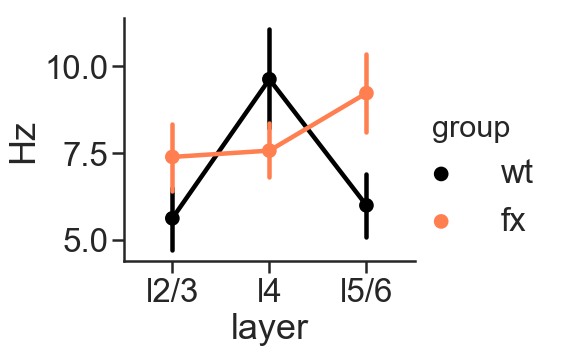

In [1817]:
fig_inp = gr[(gr.times > 1) & (gr.times < 6) 
#              & (gr.layer == 'l5/6') 
            ]
# base = gr[(gr.times > 0) & (gr.times < 1)].groupby([ cond, 'group', 'stim1' ,'cluster_id']).mean().reset_index().Hz.values
# fig_inp = gr.groupby('cluster_id').apply(get_auc)

fig_inp = fig_inp.groupby([ cond, 'group'  ,'stim1', 'cluster_id']).mean().reset_index()

# fig_inp.loc[:,'bc_fr'] = fig_inp.Hz - base
# fig_inp = fig_inp[fig_inp.n_type != 'un']
fig_inp = fig_inp.sort_values(by = ['stim1', cond, 'group'], ascending = [False, True, False])
ax = sns.catplot( x = 'layer', y = "Hz", sharey = True,  data= fig_inp,  kind = 'point', ci = 68,  legend = True,
              palette = colors_group, sharex = False, hue = 'group', 
#                    capsize = 0.02, saturation = 1,
                   height = 5, aspect = 1.2 ,
#                   col_wrap = 2, col = cond,
                )
# plt.savefig('point_opto_inh.pdf')

In [1705]:
val = 'Hz'
cond = 'layer'
ls = []
# for lay in sorted(fig_inp['layer'].unique()):
#     ls = []
#     print lay
for l in sorted(fig_inp[cond].unique()):

    stat_inp = fig_inp[(fig_inp[cond] == l) 
#                        & (fig_inp.layer == lay)
                      ]
    x1 = stat_inp[(stat_inp.group == 'wt')][val].dropna().values
    x2 = stat_inp[(stat_inp.group == 'fx')][val].dropna().values


    print '\t', l, len(x1), len(x2)
    wt_mean, wt_sem = np.mean(x1), sstat.sem(x1)
    fx_mean, fx_sem = np.mean(x2), sstat.sem(x2)
    print wt_mean, wt_sem
    print fx_mean, fx_sem

    x1_x2 = sstat.ttest_ind(x1, x2)
    print x1_x2
#     ls.append(x1_x2[1])
    print '------------------------'
# pvals = np.array(ls)
# adj = multipletests(pvals, method='fdr_bh')

# print np.round(adj[1], 5)

	l2/3 69 65
1.9550011149312483 0.24946840914960297
2.8082934320587216 0.44333132014874843
Ttest_indResult(statistic=-1.7026530445944739, pvalue=0.09098668763767609)
------------------------
	l4 100 81
2.2454370971017323 0.22533223469467303
3.256785320228549 0.3873700812145958
Ttest_indResult(statistic=-2.356840514064671, pvalue=0.019512026716306287)
------------------------
	l5/6 78 68
3.221759334319779 0.47562247660471196
2.94056983828688 0.34194361105471327
Ttest_indResult(statistic=0.46764621041142956, pvalue=0.6407445560382121)
------------------------


In [254]:
from statsmodels.stats.multitest import multipletests

In [1085]:
wt_std = fig_inp[(fig_inp.stim1 == 'std3') & (fig_inp.group == 'wt')].ztc.dropna().values
wt_dev = fig_inp[(fig_inp.stim1 == 'dev9') & (fig_inp.group == 'wt')].ztc.dropna().values
wt_ctr = fig_inp[(fig_inp.stim1 == 'ctr2') & (fig_inp.group == 'wt')].ztc.dropna().values

fx_std = fig_inp[(fig_inp.stim1 == 'std3') & (fig_inp.group == 'fx')].ztc.dropna().values
fx_dev = fig_inp[(fig_inp.stim1 == 'dev9') & (fig_inp.group == 'fx')].ztc.dropna().values
fx_ctr = fig_inp[(fig_inp.stim1 == 'ctr2') & (fig_inp.group == 'fx')].ztc.dropna().values

print "WT std/dev/ctr mean and sem" 
print np.mean(wt_std), sstat.sem(wt_std) 
print np.mean(wt_dev), sstat.sem(wt_dev) 
print np.mean(wt_ctr), sstat.sem(wt_ctr)

print "FX std/dev/ctr mean and sem"
print np.mean(fx_std), sstat.sem(fx_std) 
print np.mean(fx_dev), sstat.sem(fx_dev) 
print np.mean(fx_ctr), sstat.sem(fx_ctr)

print (len(wt_std), len(fx_std))

# print sstat.kruskal(x1, x2, x3)

p1 =  sstat.mannwhitneyu(wt_std, wt_dev)[1]
p2 = sstat.mannwhitneyu(wt_std, wt_ctr)[1]
p3 =  sstat.mannwhitneyu(wt_dev, wt_ctr)[1]

p4 =  sstat.mannwhitneyu(fx_std, fx_dev)[1]
p5 =  sstat.mannwhitneyu(fx_std, fx_ctr)[1]
p6 =  sstat.mannwhitneyu(fx_dev, fx_ctr)[1]

p7 =  sstat.mannwhitneyu(wt_std, fx_std)[1]
p8 =  sstat.mannwhitneyu(wt_dev, fx_dev)[1]
p9 =  sstat.mannwhitneyu(wt_ctr, fx_ctr)[1]

pvals = np.array((p1, p2, p3, p4, p5, p6, p7, p8, p9))
adj = multipletests(pvals, method='fdr_bh')
print pvals
print np.round(adj[1], 5)

WT std/dev/ctr mean and sem
6.302906491405097 1.1351391991829285
10.626453969748512 1.9574190697646103
9.310122243329557 1.7649085061651315
FX std/dev/ctr mean and sem
5.864063963490148 1.0827096777431116
10.460214731280796 1.9006659455958794
7.4885222235279745 1.2660315725501432
(31, 40)
[0.06073377 0.15203704 0.2586172  0.01500817 0.17161139 0.1046057
 0.30701965 0.41961216 0.22729674]
[0.2733  0.3089  0.33251 0.13507 0.3089  0.3089  0.3454  0.41961 0.33251]


In [148]:
def get_auc(data, val = 'ztc'):
    tmp = data[(data.times < 1) & (data.times < 6)]
    auc = np.trapz(data[val])
    data.loc[:, 'auc'] = auc
    return data

Ks_2sampResult(statistic=0.10915428361768481, pvalue=0.7482593406113601)
Ks_2sampResult(statistic=0.1819849568886443, pvalue=0.15579405582638436)
Ks_2sampResult(statistic=0.15153182902219775, pvalue=0.3392193522113017)
79 69


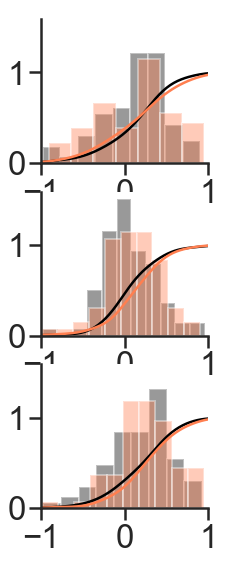

In [984]:
_inp = df_odd[(df_odd.resp_sig == 'exc')
              & (df_odd.tun_group == 'untun')
              & (df_odd.abs_times == 0.5)
              & (df_odd.layer == 'l5/6' )
              ]

f, ax = plt.subplots(3, 1, figsize = (3,9), sharey = True)
# _inp = _inp[~(_inp.cluster_id.isin(ctr2_units))]

val = ['ssa_hz', 'dd_hz', 'pe_hz' ]

for i in range(3):
    x = _inp[_inp.group == 'wt'].groupby('cluster_id')[val[i]].mean().dropna().values
    y = _inp[_inp.group == 'fx'].groupby('cluster_id')[val[i]].mean().dropna().values
    sns.distplot(x, 
                 kde_kws=dict(cumulative = True), 
    #              hist = False,
                 color = 'k', 
                 ax = ax[i])
    sns.distplot(y, kde_kws=dict(cumulative = True), 
    #              hist = False,
                 color = 'coral', 
                 ax = ax[i])
    # ax[0].axvline(x= 0, linestyle = '--')
    ax[i].set_xlim(-1, 1)
    sns.despine()

    print sstat.ks_2samp(x, y)
print len(x), len(y)
# plt.savefig('dist_l56_untun_odd.pdf')

In [ ]:
print len(x), len(y), len(x2), len(y2)
print sstat.ks_2samp(x, y)
print sstat.ks_2samp(x2, y2)

In [304]:
val = 'Hz'
for l in sorted(fig_inp[cond].unique()):
    
    stat_inp = fig_inp[fig_inp[cond] == l]
    x1 = stat_inp[(stat_inp.group == 'wt') ][val].dropna().values
    x2 = stat_inp[(stat_inp.group == 'fx') ][val].dropna().values
    
#     x3 = stat_inp[(stat_inp.group == 'wt') & (stat_inp.n_type == 'fs')][val].dropna().values
#     x4 = stat_inp[(stat_inp.group == 'fx') & (stat_inp.n_type == 'fs')][val].dropna().values
    
    print l
    print 'wt, rs', len(x1) , np.mean(x1), sstat.sem(x1)
    print 'fx, rs', len(x2) , np.mean(x2), sstat.sem(x2)
#     print 'wt, fs', len(x3) ,np.mean(x3), sstat.sem(x3)
#     print 'fx, fs', len(x4) ,np.mean(x4), sstat.sem(x4)

    print 'rs', sstat.mannwhitneyu(x1, x2)
#     print 'fs', sstat.mannwhitneyu(x3, x4)
    print '------------------------'


l2/3
wt, rs 282 11.645234857825663 0.4228293286385281
fx, rs 171 11.052526833190884 0.4936592845379126
rs MannwhitneyuResult(statistic=23160.0, pvalue=0.24080745984177027)
------------------------
l4
wt, rs 231 13.370139466771873 0.5893777560170312
fx, rs 186 13.1687298679643 0.5671646880268583
rs MannwhitneyuResult(statistic=21019.0, pvalue=0.3523923502430868)
------------------------
l5/6
wt, rs 252 13.508207252684038 0.6023776300550806
fx, rs 210 12.484179739067855 0.5468812170989965
rs MannwhitneyuResult(statistic=25593.0, pvalue=0.27212477696091353)
------------------------


In [305]:
ls_layer = []
val = 'Hz'
for l in sorted(fig_inp[cond].unique()):
    
    srat_inp = fig_inp[fig_inp[cond] == l]
    x1 = srat_inp[srat_inp.stim1 == 'std3'][val].dropna().values
    x2 = srat_inp[srat_inp.stim1 == 'dev9'][val].dropna().values
    x3 = srat_inp[srat_inp.stim1 == 'ctr2'][val].dropna().values
    
    print l
    std_mean, std_sem = np.mean(x1), sstat.sem(x1)
    dev_mean, dev_sem = np.mean(x2), sstat.sem(x2)
    ctr_mean, ctr_sem = np.mean(x3), sstat.sem(x3)

#     n = min(len(x1), len(x2), len(x3))

#     print sstat.kruskal(x1, x2, x3)

    std_dev = sstat.mannwhitneyu(x1, x2)
    std_ctr = sstat.mannwhitneyu(x1, x3)
    dev_ctr = sstat.mannwhitneyu(x2, x3)
    
    data_tmp = pd.DataFrame({cond: l, 'stim1': ['std', 'dev', 'ctr'], 
    'mean': [std_mean, dev_mean, ctr_mean ], 'sem': [std_sem, dev_sem, ctr_sem ], 
    'n_units': [len(x1), len(x2), len(x3)], 'group': 'wt', 'comparison': ['std_dev', 'std_ctr', 'dev_ctr'],
    'p_val': [std_dev[1], std_ctr[1], dev_ctr[1]], 'u_stat': [std_dev[0], std_ctr[0], dev_ctr[0]],
                         'test': 'MWU' })
    ls_layer.append(data_tmp)
    print '------------------------'
stat_table = pd.concat(ls_layer)
stat_table.head()

l2/3
------------------------
l4
------------------------
l5/6
------------------------


comparison group layer       mean  n_units         p_val       sem stim1  \
0    std_dev    wt  l2/3   8.446884      151  1.907299e-07  0.370329   std   
1    std_ctr    wt  l2/3  11.945729      151  1.313539e-11  0.528411   dev   
2    dev_ctr    wt  l2/3  13.871879      151  2.532163e-02  0.650153   ctr   
0    std_dev    wt    l4  10.567842      139  3.186449e-04  0.537190   std   
1    std_ctr    wt    l4  13.929689      139  2.931714e-06  0.719611   dev   

  test  u_stat  
0  MWU  7547.0  
1  MWU  6342.0  
2  MWU  9917.0  
0  MWU  7371.0  
1  MWU  6623.0

In [306]:
cols = ['group', cond, 'comparison', 'test', 'u_stat', 'p_val', 'stim1', 'n_units', 'mean', 'sem' ]
stat_table[cols]

group layer comparison test   u_stat         p_val stim1  n_units  \
0    wt  l2/3    std_dev  MWU   7547.0  1.907299e-07   std      151   
1    wt  l2/3    std_ctr  MWU   6342.0  1.313539e-11   dev      151   
2    wt  l2/3    dev_ctr  MWU   9917.0  2.532163e-02   ctr      151   
0    wt    l4    std_dev  MWU   7371.0  3.186449e-04   std      139   
1    wt    l4    std_ctr  MWU   6623.0  2.931714e-06   dev      139   
2    wt    l4    dev_ctr  MWU   8826.0  1.066869e-01   ctr      139   
0    wt  l5/6    std_dev  MWU   8697.0  2.623662e-05   std      154   
1    wt  l5/6    std_ctr  MWU   7710.0  5.561774e-08   dev      154   
2    wt  l5/6    dev_ctr  MWU  10878.0  1.050272e-01   ctr      154   

        mean       sem  
0   8.446884  0.370329  
1  11.945729  0.528411  
2  13.871879  0.650153  
0  10.567842  0.537190  
1  13.929689  0.719611  
2  15.343376  0.803595  
0  10.508790  0.626345  
1  13.829816  0.735550  
2  14.789614  0.732799

In [1408]:
df_odd[(df_odd.abs_times == 0.5) 
       & (df_odd.group == 'wt')].groupby([ 'resp_sig', 'n_type']).cluster_id.count()

resp_sig  n_type
exc       fs        156
          rs        636
          un         59
inh       fs         24
          rs         97
          un         11
ns        fs         18
          rs         67
          un          7
Name: cluster_id, dtype: int64

In [1522]:
values/total

array([0.16581633, 0.60586735, 0.04719388, 0.01913265, 0.09821429,
       0.00510204, 0.00765306, 0.04464286, 0.00637755])

In [1550]:
total

643

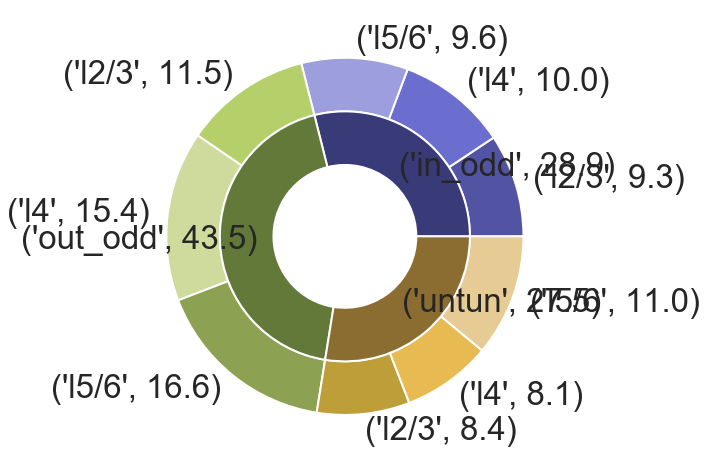

In [1549]:
tmp = df_odd[(df_odd.abs_times == 0.5) & (df_odd.group == 'fx') & (df_odd.resp_sig == 'exc')]
tmp2 = tmp.groupby([ 'tun_group', 'layer']).cluster_id.count().reset_index()
total = tmp2.cluster_id.values.sum()

fig, ax = plt.subplots(figsize = (8, 8))
ax.axis('equal')
width = 0.3

cm = plt.get_cmap("tab20b")
labels = tmp2['layer'].values
values = tmp2.cluster_id.values
cin = cm(np.array([1,2,3, 6,7,5, 9, 10, 11]))

wedges, texts = ax.pie(values, radius=1,  colors = cin, labels = zip(labels, np.round(values/total*100, 1)),
                      wedgeprops=dict(width=width, edgecolor='w'))


cout = cm(np.arange(3)*4)
labels = tmp2.groupby('tun_group').sum().index.values
values = tmp2.groupby('tun_group').sum().cluster_id.values
wedges, texts = ax.pie(values, radius = 1-width,  labels = zip(labels, np.round(values/total*100, 1)),
                       wedgeprops=dict(width=width, edgecolor='w'),
                                      labeldistance=0.7, colors = cout)

# plt.savefig('pie_wt_tun_layer.pdf')

In [1466]:
texts

[Text(0.439955,0.215731,u'fs'),
 Text(-0.456637,0.177715,u'rs'),
 Text(0.0436176,-0.488055,u'un'),
 Text(0.159566,-0.463291,u'fs'),
 Text(0.310126,-0.379371,u'rs'),
 Text(0.412566,-0.264366,u'un'),
 Text(0.433463,-0.228494,u'fs'),
 Text(0.476336,-0.11491,u'rs'),
 Text(0.489897,-0.0100232,u'un')]

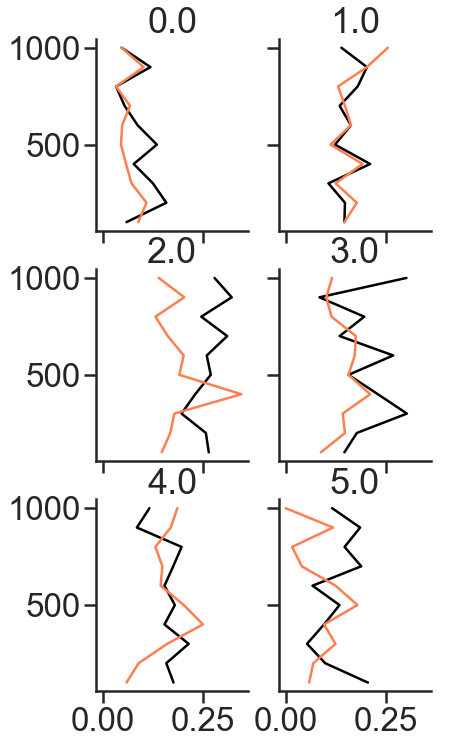

In [567]:
f, ax = plt.subplots(3, 2, sharex=True,sharey=True, figsize = (6,12))
bins = np.arange(0, 1001, 100)
wt_total = gr[(gr.abs_times == 0.5) & (gr.group == 'wt')].depth.values
a_wt = np.histogram(wt_total, bins= bins)

fx_total = gr[(gr.abs_times == 0.5) & (gr.group == 'wt')].depth.values
a_fx = np.histogram(fx_total, bins= bins)
axs = ax.ravel()
for idx, val in enumerate(sorted(gr[cond].unique())):
    tmp_wt = gr[ (gr.abs_times == 0.5) & (gr[cond] == val) & (gr.group == 'wt')].depth.values
    tmp_fx = gr[ (gr.abs_times == 0.5) & (gr[cond] == val) & (gr.group == 'fx')].depth.values
    
    b_wt = np.histogram(tmp_wt, bins= bins)
    b_fx = np.histogram(tmp_fx, bins= bins)
#     print tmp_depth.size
    axs[idx].plot( b_wt[0]/a_wt[0], bins[1:],   color = 'k')
    axs[idx].plot( b_fx[0]/a_fx[0], bins[1:],  color = 'coral')
    axs[idx].set_title(val)
#     print _depth.size
sns.despine()
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.xlim(-200, 1200)
# plt.savefig('dist_depth-bysf.pdf')

## SSA and DD indices

In [82]:
good_units.size

1879

array(['ctr2', 'std3', 'dev9'], dtype=object)

In [444]:
df_vmmn_opto = pd.concat([tmp0, tmp1])

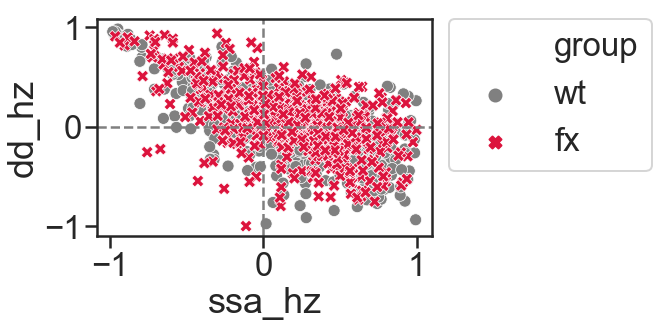

In [87]:
_inp = df_odd[(df_odd.resp_sig == 'exc')
              & (df_odd.abs_times == 0.5)
#               & (df_odd.group == 'fx')
              ]
# _inp = _inp[~(_inp.cluster_id.isin(ctr2_units))]
_inp = _inp.sort_values(by = 'group', ascending=False)
g = sns.scatterplot(data = _inp, x = 'ssa_hz', y= 'dd_hz',  
                    style = 'group',  hue = 'group', sizes = (20, 200)
              )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# g.set_axis_labels('ssa', 'dd')
# plt.xlim(-1,1)
# plt.ylim(-1,1)
plt.axvline(x= 0, linestyle = '--')
plt.axhline(y= 0, linestyle = '--')

In [544]:
_inp[_inp.group == 'wt'].groupby('cluster_id')[val].mean().dropna().values

array([ 0.69037197,  0.05372736, -0.36066027, -0.34502156,  0.19738886,
        0.5726429 ,  0.14205393,  0.37166653,  0.25104789,  0.53962834,
        0.2776016 , -0.45375349,  0.26559259,  0.25290369,  0.16910274,
        0.29487298, -0.31623433,  0.29135882,  0.44639633,  0.46767709,
        0.45008248,  0.64164792, -0.0752987 ,  0.77961883,  0.53474397,
        0.42709881,  0.22514922,  0.25576065,  0.75462174,  0.14758515,
       -0.20838575,  0.57698727,  0.70772755,  0.50434359,  0.59339636,
       -0.33010073, -0.24547169,  0.49462918,  0.08814282,  0.31175618,
        0.71982988,  0.54010641, -0.12087   ,  0.07017046,  0.3753323 ,
        0.00752686,  0.82134353, -0.04696056,  0.1238138 ,  0.22308502,
        0.50488419,  0.19712757,  0.54904609,  0.32759624,  0.47182767,
        0.45941776, -0.12169526,  0.50562133, -0.97306481,  0.35032547,
       -0.00430972,  0.34449588,  0.23560091, -0.02604805,  0.1343839 ,
        0.16072267, -0.33070046, -0.24723288,  0.9492363 , -0.36

In [ ]:
_inp[_inp.group == 'wt'].groupby('cluster_id')[val].mean().dropna().values

77 59 77 59
Ks_2sampResult(statistic=0.13515298261060973, pvalue=0.544259176233888)
Ks_2sampResult(statistic=0.1928241250275149, pvalue=0.14775033875668542)


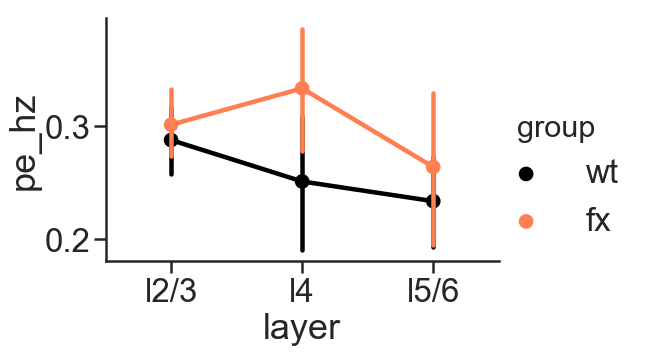

In [1810]:
# f, ax = plt.subplots(figsize = (12, 8), facecolor = 'w')

# tmp_odd = df_odd[(df_odd.times > 0.35) & (df_odd.times < 0.8)].groupby([ 'group', 'layer', 'n_type' ,'resp_sig', 
#                             'cluster_id', 'stim1']).mean().reset_index().dropna()
# base = df_odd[(df_odd.times > 0) & (df_odd.times < 0.3)].groupby([ 'group', 'layer', 'n_type' ,'resp_sig', 
#                             'cluster_id', 'stim1']).mean().reset_index().dropna().Hz.values
# tmp_odd.loc[:,'bc_fr'] = tmp_odd['Hz'] - base

# fig_inp = tmp_odd[(tmp_odd.resp_sig == 'exc') 
# #                  & (tmp_odd.group == 'fx')
# #                  & (tmp_odd.n_type == 'fs')
#                    &(tmp_odd.stim1 == 'ctr2')
#                  ]
fig_inp = df_odd[
    (df_odd.resp_sig == 'exc') 
#        & (tmp_odd.group == 'wt')
        &(df_odd.abs_times == 0.5)
    & (df_odd.n_type == 'fs')
                  ]

fig_inp = fig_inp.sort_values(by = ['layer' ,'group'], ascending= [ True, False])
ax = sns.catplot(x = "layer", y = "pe_hz",   data= fig_inp,  kind = 'point', ci = 68, 
                  palette = colors_group, hue = 'group', 
#                  col = 'layer', col_wrap = 1,
#                    capsize = 0.02, saturation = 1,
                   height = 5, aspect=1.5 )
plt.savefig('point_fs_mm_layer.pdf')

In [1813]:
val = 'ssa_hz'
cond = 'layer'
wt_in = fig_inp[(fig_inp[cond] == 'l2/3') & (fig_inp.group == 'wt')][val].dropna().values
wt_out = fig_inp[(fig_inp[cond] == 'l4') & (fig_inp.group == 'wt')][val].dropna().values
wt_untun = fig_inp[(fig_inp[cond] == 'l5/6') & (fig_inp.group == 'wt')][val].dropna().values

fx_in_odd = fig_inp[(fig_inp[cond] == 'l2/3') & (fig_inp.group == 'fx')][val].dropna().values
fx_out_odd = fig_inp[(fig_inp[cond] == 'l4') & (fig_inp.group == 'fx')][val].dropna().values
fx_untun = fig_inp[(fig_inp[cond] == 'l5/6') & (fig_inp.group == 'fx')][val].dropna().values

print "WT L2/3 4 5/6 mean and sem" 
print np.mean(wt_in), sstat.sem(wt_in) 
print np.mean(wt_out), sstat.sem(wt_out) 
print np.mean(wt_untun), sstat.sem(wt_untun)

print "FX L2/3 4 5/6 mean and sem"
print np.mean(fx_in_odd), sstat.sem(fx_in_odd) 
print np.mean(fx_out_odd), sstat.sem(fx_out_odd) 
print np.mean(fx_untun), sstat.sem(fx_untun)

print (len(wt_in), len(wt_out), len(wt_untun), len(fx_in_odd), len(fx_out_odd), len(fx_untun))

# print sstat.kruskal(x1, x2, x3)

p1 =  sstat.mannwhitneyu(wt_in, wt_out)[1]
p2 = sstat.mannwhitneyu(wt_in, wt_untun)[1]
p3 =  sstat.mannwhitneyu(wt_out, wt_untun)[1]

p4 =  sstat.mannwhitneyu(fx_in_odd, fx_out_odd)[1]
p5 =  sstat.mannwhitneyu(fx_in_odd, fx_untun)[1]
p6 =  sstat.mannwhitneyu(fx_out_odd, fx_untun)[1]

p7 =  sstat.mannwhitneyu(wt_in, fx_in_odd)[1]
p8 =  sstat.mannwhitneyu(wt_out, fx_out_odd)[1]
p9 =  sstat.mannwhitneyu(wt_untun, fx_untun)[1]

pvals = np.array((p1, p2, p3, p4, p5, p6, p7, p8, p9))
adj = multipletests(pvals, method='fdr_bh')
print pvals
print np.round(adj[1], 5)

WT L2/3 4 5/6 mean and sem
0.24912278170320504 0.04137725089063467
0.22692850458517624 0.06916143583367079
0.13092172327169538 0.07657926174083245
FX L2/3 4 5/6 mean and sem
0.1914127718563228 0.04976905146556738
0.3332206980722664 0.056929435522459666
0.17388321339491547 0.07269339665921361
(67, 34, 26, 52, 27, 33)
[0.33447371 0.12478458 0.30862897 0.08067301 0.35077063 0.06865402
 0.35282575 0.13022722 0.39466399]
[0.39466 0.29301 0.39466 0.29301 0.39466 0.29301 0.39466 0.29301 0.39466]


In [382]:
ls_layer = []
val = 'ssa_hz'
for l in sorted(fig_inp['tun_group'].unique()):
    
    stat_inp = fig_inp[fig_inp['tun_group'] == l]
    x1 = stat_inp[stat_inp.group == 'wt'][val].dropna().values
    x2 = stat_inp[stat_inp.group == 'fx'][val].dropna().values
 
    print len(x1), len(x2)
#     x1_mean, x1_sem = np.mean(x1), sstat.sem(x1)
#     x2_mean, x2_sem = np.mean(x2), sstat.sem(x2)

    x1_x2 = sstat.mannwhitneyu(x1, x2)
    ls_layer.append(x1_x2[1])
#     data_tmp = pd.DataFrame({ 'group': ['wt', 'fx'], 
#     'mean': [x1_mean, x2_mean ], 'sem': [x1_sem, x2_sem ], 'pref':l,
#     'n_units': [len(x1), len(x2)], 'tuning': 'pe',
#     'p_val': x1_x2[1], 'stat': x1_x2[0]  })
#     ls_layer.append(data_tmp)
    print '------------------------'
pvals = np.array(ls_layer)
adj = multipletests(pvals, method='fdr_bh')
print pvals
print adj[1]
# stat_table = pd.concat(ls_layer)
# stat_table.head()



223 167
------------------------
302 240
------------------------
210 157
------------------------
[0.20982264 0.0327118  0.48076507]
[0.31473396 0.09813539 0.48076507]


In [60]:
stat_table

group      mean  n_units     p_val  pref       sem     stat tuning
0    wt -0.021755       51  0.002377   0.0  0.044774    609.0     pe
1    fx  0.155797       37  0.002377   0.0  0.059042    609.0     pe
0    wt  0.044280       88  0.037031   1.0  0.032988   4007.0     pe
1    fx  0.108559      107  0.037031   1.0  0.028904   4007.0     pe
0    wt  0.256439      168  0.462554   2.0  0.019514  10014.0     pe
1    fx  0.253052      120  0.462554   2.0  0.028617  10014.0     pe
0    wt  0.021774      121  0.117766   3.0  0.029011   4586.0     pe
1    fx  0.078699       84  0.117766   3.0  0.038702   4586.0     pe
0    wt -0.009053       92  0.068180   4.0  0.032555   3527.0     pe
1    fx  0.067771       88  0.068180   4.0  0.035821   3527.0     pe
0    wt  0.053039       67  0.055969   5.0  0.037225   1386.0     pe
1    fx  0.137973       50  0.055969   5.0  0.046035   1386.0     pe

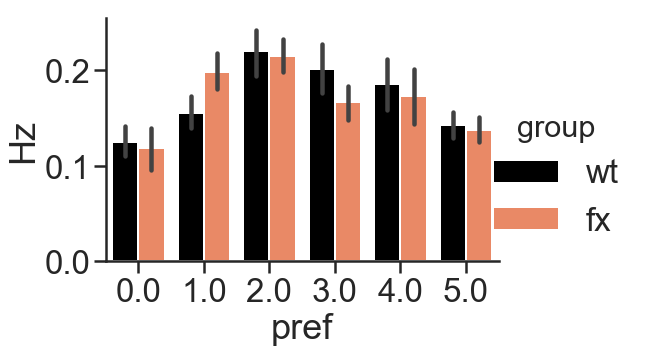

In [99]:
tmp = df_odd[df_odd.abs_times == 0.5].groupby(['group', 'et', 'pref']).agg({'Hz': 'count'}).groupby(level=1).apply(lambda x:
                                                  x / float(x.sum())).reset_index()
tmp = tmp.sort_values(by = ['pref', 'group'], ascending= [False, False])

ax = sns.catplot(x = "pref", y = "Hz",   data = tmp,  kind = 'bar', ci = 68, 
                  palette = colors_group, hue = 'group', 
#                  col = 'n_type', col_wrap = 1,
                    size = 5, aspect=1.5
                    )
# plt.savefig('bar-pref-dist-proportion-by-et.pdf')

In [104]:
tmp.groupby(['group', 'pref']).count()

et  Hz
group pref        
fx    0.0   14  14
      1.0   14  14
      2.0   14  14
      3.0   14  14
      4.0   14  14
      5.0   13  13
wt    0.0   15  15
      1.0   16  16
      2.0   15  15
      3.0   16  16
      4.0   16  16
      5.0   15  15

In [106]:
val = 'Hz'
cond = 'pref'
fig_inp = tmp
for l in sorted(fig_inp[cond].unique()):
    
    stat_inp = fig_inp[fig_inp[cond] == l]
    x1 = stat_inp[(stat_inp.group == 'wt') ][val].dropna().values
    x2 = stat_inp[(stat_inp.group == 'fx') ][val].dropna().values
    
#     x3 = stat_inp[(stat_inp.group == 'wt') & (stat_inp.n_type == 'fs')][val].dropna().values
#     x4 = stat_inp[(stat_inp.group == 'fx') & (stat_inp.n_type == 'fs')][val].dropna().values
    
    print l
    print 'wt', len(x1) , np.mean(x1), sstat.sem(x1)
    print 'fx', len(x2) , np.mean(x2), sstat.sem(x2)
#     print 'wt, fs', len(x3) ,np.mean(x3), sstat.sem(x3)
#     print 'fx, fs', len(x4) ,np.mean(x4), sstat.sem(x4)

    print sstat.mannwhitneyu(x1, x2)
#     print 'fs', sstat.mannwhitneyu(x3, x4)
    print '------------------------'


0.0
wt 15 0.12479691438108716 0.016895860799861422
fx 14 0.11869157269217774 0.022151235756766047
MannwhitneyuResult(statistic=94.0, pvalue=0.32330256455856365)
------------------------
1.0
wt 16 0.15573913903305334 0.016326738185092133
fx 14 0.19855147534268602 0.01940172880298617
MannwhitneyuResult(statistic=77.0, pvalue=0.0757598861026964)
------------------------
2.0
wt 15 0.2196549553321205 0.026097603116922163
fx 14 0.21512075935885938 0.018298253265674542
MannwhitneyuResult(statistic=102.5, pvalue=0.4652088078619925)
------------------------
3.0
wt 16 0.20170039772524528 0.026373653007201257
fx 14 0.1670409842107122 0.018838795544411435
MannwhitneyuResult(statistic=101.0, pvalue=0.3312227342147457)
------------------------
4.0
wt 16 0.1861261397868327 0.026944137463959024
fx 14 0.17323193045065316 0.029992992179388344
MannwhitneyuResult(statistic=105.0, pvalue=0.39349989889577325)
------------------------
5.0
wt 15 0.14241140863865223 0.015037328110803366
fx 13 0.137160453171443

In [792]:
tmp_tun

group      cluster_id stim1         Hz  abs_times  depth  times  \
3153    fx  26et014right-1  ctr0  21.415200      0.425    100  0.425   
3154    fx  26et014right-1  ctr1  18.139284      1.425    100  0.425   
3155    fx  26et014right-1  ctr2  16.135988      2.425    100  0.425   
3156    fx  26et014right-1  ctr3  13.871071      3.425    100  0.425   
3157    fx  26et014right-1  ctr4  12.919090      4.425    100  0.425   
3158    fx  26et014right-1  ctr5  13.796441      5.425    100  0.425   

        zscore        ztc      bc_fr      norm  pref  
3153  1.799098  15.169195  17.497124  1.000000     0  
3154  1.761357   8.444906  13.079552  0.538932     0  
3155  1.836233  25.429248  11.636783  0.388348     0  
3156  1.812008   5.979221   9.853652  0.202240     0  
3157  1.714484   5.236999   7.915954  0.000000     0  
3158  2.115811   6.903438  10.164293  0.234662     0

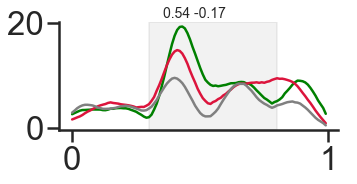

In [1112]:
stims = sorted(df_odd.stim1.unique())
colors = ['green', 'crimson', 'gray']
_inp = df_odd[(df_odd.group == 'wt') 
              & (df_odd.n_type == 'fs')  
              & (df_odd.resp_sig == 'exc')]

for unit in _inp.cluster_id.unique()[13:14]:
    tmp = df_odd[df_odd.cluster_id == unit]
    tmp = tmp.sort_values(by = ['times', 'stim1'], ascending = [True, False])
    f, ax = plt.subplots(1 , figsize = (5,2), sharey=False, sharex=False, facecolor = 'w')
    
#     tmp_tun = df_tuning[df_tuning.cluster_id == unit]
#     ax[0].plot(tmp_tun.stim1, tmp_tun.bc_fr, c = 'gray')
    
    sns.despine()
    plt.suptitle(str(round(tmp.ssa_hz.values[0],2)) + ' '
                 +  str(round(tmp.dd_hz.values[0],2)), size = 14 )
    for idx, stim in enumerate(sorted(tmp.stim1.unique())):
        ax.plot( tmp[(tmp.stim1 == stim)].times, tmp[(tmp.stim1 == stim)].Hz, label = stims[idx], color = colors[idx]  )
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     break
ax.axvspan(0.3, 0.8, alpha = 0.05, color='k')
plt.savefig(str(unit) + 'wt_fs_odd_example.pdf')

## Waveform-based RS/FS splitting

In [13]:
import resampy
import scipy.optimize as opt
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [14]:
result = df_tmt
samples = np.concatenate([np.arange(82)] * result.cluster_id.unique().size)
result['samples'] = samples
spk_width = {}
d_fwhm = {}
tr2peak = {}
neuron_type = {}
ls = []
ls2 = []
ls3 = []
# f, ax = plt.subplots(1,2)
for ii in result.cluster_id.unique()[:]:
#trough-to-peak    
    #tp =  result[(result['cuid'] == ii)  & (result.index > 18)  ].tmt.idxmax() - result[(result['cuid'] == ii)  & (result.index == 18)  ].index
    tmt_data = np.array(result[(result['cluster_id'] == ii)   ].tmt)

    y = resampy.resample( tmt_data[::-1] , 1 ,10,  filter='sinc_window',
                                    num_zeros=10, precision=5,
                                    window=ssig.hann)
    trough_idx = y.argmin()
    peak_idx = y[:y.argmin()].argmax()
#     plt.plot(y)
#     plt.axvline(x= trough_idx, color = 'k', linestyle = '--')
#     plt.axvline(x= peak_idx, color = 'r',linestyle = '--')
#     plt.axvline(x= peak_idx-100, color = 'b',linestyle = '--')
#     plt.show()

    tp = abs((trough_idx - peak_idx)/300.0)
    
    x = np.arange(y.size)
    y_gaus = y*(-1)
    popt,pcov = opt.curve_fit(gaus,x,y_gaus,p0=[0.2, y.argmin(), 10])
    fwhm = popt[-1]/300*2.355
    
#     plt.plot(x,y*(-1),'b+:')
#     plt.plot(x,gaus(x,*popt),'r--')
#     plt.show()

    f,pxx = ssig.welch(tmt_data, fs=3e4,  nfft=5096,  nperseg=48,
                          return_onesided=True, scaling='spectrum')

    df = np.vstack((f, pxx))
    df = pd.DataFrame(df)
    idx = df.T[1].idxmax()
    w = df.T[0][idx]
    w = 1/w*1000.0

    ls2.append(w)
    ls.append(tp)
    
    spk_width[ii] = w
    tr2peak[ii] = tp
    
    if tp < 0.45 and w < 1.2:
        neuron_type[ii] = 'fs'
    elif tp > 0.45 and w > 1.2:
        neuron_type[ii] = 'rs'
    else:
        neuron_type[ii] = 'un'

#p/t ratio
    edge = 100
    if peak_idx < 100:
        edge = peak_idx
    y_slope = y[peak_idx-edge:peak_idx]
    x_slope = np.arange(y_slope.size)
    slope, intercept, r_value, p_value, std_err = sstat.linregress(x_slope, y_slope)
    ls3.append(1e3*(slope))
    
#     plt.plot(x_slope, y_slope, 'o')
#     plt.plot(x_slope, intercept + slope*x_slope, 'r')
#     plt.show()
result['n_type'] = result.cluster_id.map(neuron_type)
result['sp_w'] = result.cluster_id.map(spk_width)
result['fwhm'] = result.cluster_id.map(d_fwhm)
result['tp'] = result.cluster_id.map(tr2peak)

In [15]:
total = result.cluster_id.unique().size
print total
print result[result['samples'] == 0].groupby('n_type').cluster_id.count()/total


2888
n_type
fs    0.175900
rs    0.757964
un    0.066136
Name: cluster_id, dtype: float64


In [17]:
d_group = dict(zip(df_vmmn['cluster_id'], df_vmmn.group))
result['group'] = result.cluster_id.map(d_group)

In [18]:
result.head()

cluster_id  depth                                               path  \
0  16et017left-2    150  U:\Data\pak6\OpenEphys\probe_64DA\FX\sf-nov-vm...   
1  16et017left-2    150  U:\Data\pak6\OpenEphys\probe_64DA\FX\sf-nov-vm...   
2  16et017left-2    150  U:\Data\pak6\OpenEphys\probe_64DA\FX\sf-nov-vm...   
3  16et017left-2    150  U:\Data\pak6\OpenEphys\probe_64DA\FX\sf-nov-vm...   
4  16et017left-2    150  U:\Data\pak6\OpenEphys\probe_64DA\FX\sf-nov-vm...   

   tmt  samples n_type      sp_w  fwhm        tp group  
0  0.0        0     rs  1.516667   NaN  1.116667    wt  
1  0.0        1     rs  1.516667   NaN  1.116667    wt  
2  0.0        2     rs  1.516667   NaN  1.116667    wt  
3  0.0        3     rs  1.516667   NaN  1.116667    wt  
4  0.0        4     rs  1.516667   NaN  1.116667    wt

(20, 85.05)

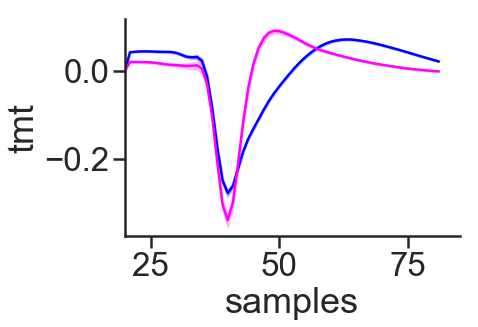

In [1160]:
sns.lineplot(x = 'samples', y = 'tmt', data = result[(result.group == 'fx') 
             & (result.n_type.str.contains('s'))], hue = 'n_type', 
             ci = 95, legend = False, palette = ['blue', 'magenta'])
sns.despine()
plt.xlim(20,)
# plt.savefig('fx_template_wvform_odd.pdf')

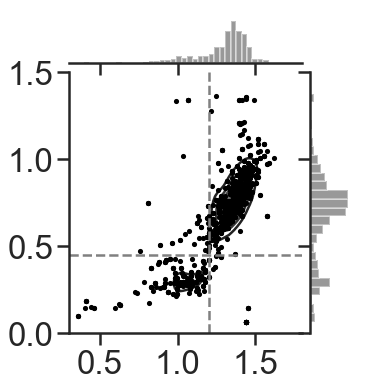

In [1150]:
g = (sns.jointplot(x = 'sp_w', y = 'tp', data= result[(result.samples == 0) 
                & (result.group == 'wt')], stat_func= None,
             color= "k", s = 10)
       .plot_joint(sns.kdeplot, zorder=0, n_levels=6))
g.set_axis_labels('', '')
plt.xlim(0.3, 1.8)
plt.ylim(0, 1.5)
plt.axvline(x= 1.2, linestyle = '--')
plt.axhline(y= 0.45, linestyle = '--')
# plt.savefig('wt_ntype_split_odd.png')

In [1819]:
result[result.samples == 0].groupby(['group', 'n_type']).mean()

depth  tmt  samples      sp_w  fwhm        tp
group n_type                                                    
fx    fs      530.298013  0.0        0  1.010875   NaN  0.303598
      rs      450.255537  0.0        0  1.370174   NaN  0.800398
      un      598.913043  0.0        0  1.183426   NaN  0.537464
wt    fs      581.944444  0.0        0  0.978708   NaN  0.298434
      rs      460.437500  0.0        0  1.367286   NaN  0.795954
      un      611.688312  0.0        0  1.194587   NaN  0.491255

In [174]:
y_sf = resampy.resample( X.T , 1 ,5,  filter='sinc_window',
                                num_zeros=10, precision=5,
                                window=ssig.hann)

## Linear Discriminant Analysis

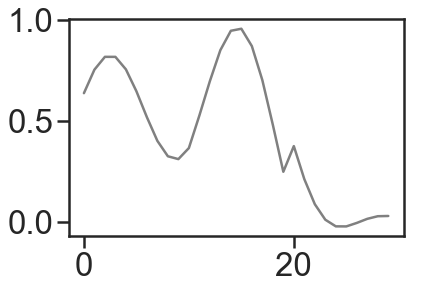

In [175]:
plt.plot(y_sf[0])

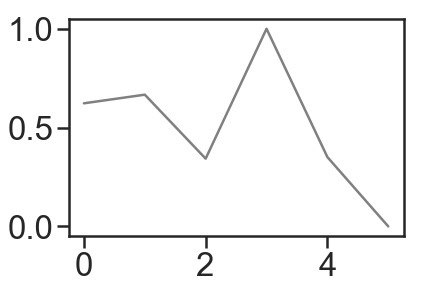

In [172]:

plt.plot(X[:,0])

In [251]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

In [415]:
x_tmp = tmp_3km[(tmp_3km.r_groups != 6) & (tmp_3km.stim1 != 'std3') & (tmp_3km.group == 'fx')]
x_tmp = x_tmp[~(x_tmp.cluster_id.isin(ctr2_units))]
x_tmp = x_tmp[(x_tmp.times > 0.2) & (x_tmp.times<0.9)]
X = x_tmp.pivot('cuid', 'times', 'zscore').values
y = x_tmp.pivot('cuid', 'times', 'stim1').values[:,0]
lda = LinearDiscriminantAnalysis(n_components=2)
X_r = lda.fit(X, y).transform(X)
# pca = PCA(n_components=2)
# X_r = pca.fit(X).transform(X)

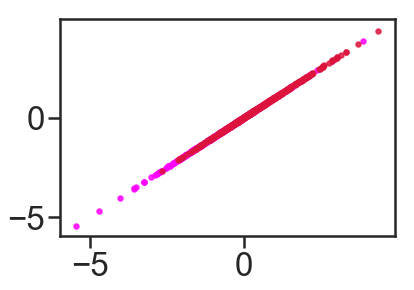

In [416]:
for color, i, target_name in zip(colors, ['ctr2', 'dev9', 'std3'], y):
    plt.scatter(X_r[y == i], X_r[y == i], alpha=.8, color=color, s = 20,
                label=y)
# plt.ylim(-6, 6)
# plt.xlim(-6, 6)

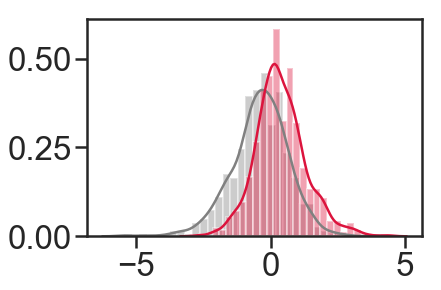

In [417]:
sns.distplot(X_r[y == 'ctr2'])
sns.distplot(X_r[y == 'dev9'])


In [345]:
lda_df = pd.DataFrame(X_r, columns= ['comp1', 'comp2'])
lda_df['stim1'] = y
v = lda_df.groupby('stim1').mean()
print v
v = v.values
origin = [0], [0] # origin point
plt.quiver( [0, 0, 0], [0, 0, 0], v[:,0], v[:,1], angles='xy', scale_units='xy', scale=1, color = colors, width = 0.015)
plt.ylim(-1, 1)
plt.xlim(-1, 1)

ValueError: Shape of passed values is (1, 56), indices imply (2, 56)

In [18]:
df2.head()

templates     times  unit_id   et     side      cluster_id  \
71         45  0.355667       45  023  right-1  45et023right-1   
72         45  0.360900       45  023  right-1  45et023right-1   
73         45  0.371567       45  023  right-1  45et023right-1   
74          3  0.374533        3  023  right-1   3et023right-1   
75         10  0.379100       10  023  right-1  10et023right-1   

                                                 path  trial_n  stim1  \
71  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...      0.0      2   
72  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...      0.0      2   
73  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...      0.0      2   
74  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...      0.0      2   
75  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...      0.0      2   

    trial_spikes  
71      0.355667  
72      0.360900  
73      0.371567  
74      0.374533  
75      0.379100

## Units trial-based analysis

In [479]:
# target_units = df_odd[(df_odd.resp_sig == 'exc')
#               & (df_odd.pref != 2)
#                & (df_odd.pref >-1)
#               ].cluster_id.unique()
# _data = df_spikes[df_spikes.cluster_id.isin(target_units)]
_data = df_spikes
df2 = _data[(_data.loc[:, 'times'] <= 120)] #sf-tuning
df2.loc[:, 'trial_n'] = df2.loc[:, 'times'] //1.0
df2.loc[:,'stim1'] = df2.loc[:, 'trial_n'].map(sf_tuning)
df2.loc[:, 'trial_spikes'] = df2.times - df2.trial_n
df2 = df2[(df2.trial_spikes > 0.35) & (df2.trial_spikes < 0.8)]

df3 = _data[(_data.loc[:, 'times'] > 120)   & ( _data.loc[:, 'times']<=320)] #sf-nov-odd
df3.times = df3.times - 120
df3.loc[:, 'trial_n'] = df3.loc[:, 'times'] //1.0
df3.loc[:,'stim1'] = df3.loc[:, 'trial_n'].map(oddball)
df3.loc[:,'trial_spikes'] = df3.times - df3.trial_n
df3 = df3[(df3.trial_spikes > 0.35) & (df3.trial_spikes < 0.8)]

C:\Users\Chub_lab\Anaconda2\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Chub_lab\Anaconda2\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Chub_lab\Anaconda2\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

## SF decoding

In [448]:
l5_units = df_odd[df_odd.layer == 'l5/6'].cluster_id.unique()
df2 = df2[df2.cluster_id.isin(l5_units)]

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split, RepeatedStratifiedKFold, cross_val_score, StratifiedKFold
from collections import defaultdict
from statsmodels.formula.api import ols
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [9]:
df2['group'] = df2.et.map(groups)
# df2_sub = df2[(df2.trial_spikes >= 0.65) & (df2.trial_spikes < 0.75) & (df2.group == 'fx')]
# resp_units = df2_sub.groupby('cluster_id').times.count().reset_index()
# resp_units = resp_units[resp_units.times > 10].cluster_id.unique()

In [77]:
tmp = df2_sub[df2_sub.cluster_id.isin(resp_units)].groupby(['cluster_id', 'trial_n']).trial_spikes.count().reset_index()
tmp2 = tmp.pivot('trial_n', 'cluster_id', 'trial_spikes')
tmp2 = tmp2.fillna(0)


In [444]:
df2_l2.head()

templates     times  unit_id   et     side       cluster_id  \
88          87  0.428300       87  023  right-1   87et023right-1   
92          65  0.430133       65  023  right-1   65et023right-1   
107        170  0.441567      170  023  right-1  170et023right-1   
114        170  0.446333      170  023  right-1  170et023right-1   
123        170  0.451067      170  023  right-1  170et023right-1   

                                                  path  trial_n  stim1  \
88   U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...      0.0      2   
92   U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...      0.0      2   
107  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...      0.0      2   
114  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...      0.0      2   
123  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...      0.0      2   

     trial_spikes group  
88       0.428300    wt  
92       0.430133    wt  
107      0.441567    wt  
114      0.446333    wt  
123      0.451067    wt

In [367]:
ls_cond = []
ls_conf_matrix = []
nested_dict = lambda: defaultdict(nested_dict)
d_coef = nested_dict()
sh_flag = False
y_ = np.array(sf_tuning.values())
time_w = [(0, 1), (0.35, 0.45), (0.45, 0.55), (0.55, 0.65), (0.65, 0.75)]

for gr in df2.group.unique()[1:]:
    print gr
    for w in time_w[4:]:
        print w
        df2_sub = df2[(df2.trial_spikes >= w[0]) & (df2.trial_spikes < w[1]) & (df2.group == gr)]
        resp_units = df2_sub.groupby('cluster_id').times.count().reset_index()
        resp_units = resp_units[resp_units.times > 10].cluster_id.unique()
        tmp = df2_sub[df2_sub.cluster_id.isin(resp_units)].groupby(['cluster_id', 
                                                'trial_n']).trial_spikes.count().reset_index()
        tmp2 = tmp.pivot('trial_n', 'cluster_id', 'trial_spikes')
        tmp2 = tmp2.fillna(0)

        ls = []
# coef_arr = np.zeros((100,5, _data.cuid.unique().size ))


        x_ = tmp2.values
        for i in range(10):
#             if sh_flag == True:
#                 x_sh = np.zeros((100,_data.cuid.unique().size ))
#                 y = np.array([0, 1, 2, 3 ,4]*20)
#                 for u in (np.unique(y)):
#                     x_sh[(u*20):(u*20+20)] = permute_columns(x[y==u])
#                 y_sh = sorted(y)
#                 x_, y_ = x_sh, y_sh
            X_train, X_test, y_train, y_test = train_test_split(x_, y_,
                                                                #random_state=42,
                                                                stratify = y_,
                                                                test_size = 0.5)
#             train_samples, n_features = X_train.shape
#             n_classes = np.unique(y).shape[0]
            #print np.unique(y_test, return_counts = True)
#             models = { 'multinomial': {'name': 'Multinomial', 'iters': [1, 3, 7]}}
#             solver = 'lbfgs'
#             # Add initial chance-level values for plotting purpose
#             accuracies = [1 / n_classes]
#             times = [0]
#             densities = [1]
#             model = 'multinomial'
#             model_params = models[model]

#             # Small number of epochs for fast runtime

#             lr = LogisticRegression(solver=solver,
#                                     multi_class='multinomial',
#                                     C = 1,
#                                     penalty='l2',
#                                     fit_intercept=True,
#                                     #max_iter=100,
#                                     #random_state=42,
#                                     )

#             lr.fit(X_train, y_train)
            lda.fit(X_train, y_train)
            y_pred = lda.predict(X_test)
            acc = cross_val_score(lda, x_, y_, cv = kf)
            conf_m = metrics.confusion_matrix(y_test, y_pred)
            ls_conf_matrix.append(conf_m)
            accuracy = np.sum(y_pred == y_test) / len(y_test)
            tmp_df = pd.DataFrame({'cv': i, 'group': gr, 'window': w[0], 'acc': accuracy}, index = [0])
            ls_cond.append(tmp_df)
        #     density = np.mean(lr.coef_ != 0, axis=1) * 100
        #     coef_arr[i] = lr.coef_
#             ls.append(accuracy)
            


fx
(0.65, 0.75)


Text(21.5,0.5,u'True SF')

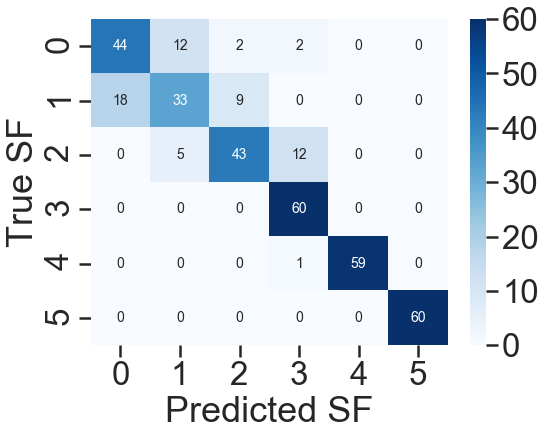

In [366]:
f, ax = plt.subplots(figsize = (8, 6))
cm = np.sum(ls_conf_matrix, axis = 0)
sns.heatmap(cm, annot=True, cmap = 'Blues', ax = ax, annot_kws={"fontsize":14})
ax.set_xlabel('Predicted SF')
ax.set_ylabel('True SF')

In [114]:
out = pd.concat(ls_cond)
out.loc[:,'error'] = 1 - out.acc
out.head()

acc  cv group  window     error
0  0.666667   0    wt     0.0  0.333333
0  0.791667   1    wt     0.0  0.208333
0  0.583333   2    wt     0.0  0.416667
0  0.750000   3    wt     0.0  0.250000
0  0.750000   4    wt     0.0  0.250000

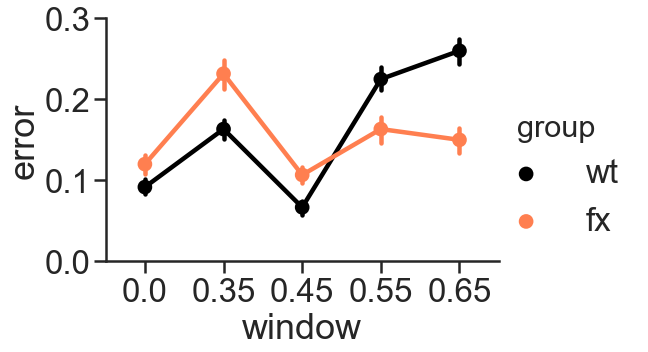

In [27]:
sns.catplot(x = 'window', y = 'error', data = out, hue = 'group', 
            kind = 'point', height = 5, aspect = 1.5, palette = colors_group , ci = 68)
plt.ylim(0, 0.3)
# plt.savefig('point-sf-decod-lda-bytime.pdf')

In [590]:
out[out.window > 0.5].groupby(['group', 'window']).error.mean()

group  window
fx     0.55      0.163333
       0.65      0.150000
wt     0.55      0.225000
       0.65      0.260000
Name: error, dtype: float64

In [12]:
lda = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = 'auto')
kf = KFold(n_splits = 4)
ls_cond = []
rskf = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 5,
     random_state = 3)
time_w = [(0, 1), (0.35, 0.45), (0.45, 0.55), (0.55, 0.65), (0.65, 0.75)]
_data = df2
for gr in _data.group.unique():
    for w in time_w:
        df2_sub = _data[(_data.trial_spikes >= w[0]) & (_data.trial_spikes < w[1]) & (_data.group == gr)]
        resp_units = df2_sub.groupby('cluster_id').times.count().reset_index()
        resp_units = resp_units[resp_units.times > 10].cluster_id.unique()
        tmp = df2_sub[df2_sub.cluster_id.isin(resp_units)].groupby(['cluster_id', 
                                                'trial_n']).trial_spikes.count().reset_index()
        tmp2 = tmp.pivot('trial_n', 'cluster_id', 'trial_spikes')
        tmp2 = tmp2.fillna(0)

        ls = []
# coef_arr = np.zeros((100,5, _data.cuid.unique().size ))

        x_ = tmp2.values
        y_ = sf_tuning.values()
        
        print gr, w, x_.shape

        scores = cross_val_score(lda, x_, y_, cv = rskf)
#         print scores
        tmp_df = pd.DataFrame({'cv': i, 'group': gr, 'window': w[0], 'acc': scores})
        ls_cond.append(tmp_df)

 wt (0, 1) (120L, 1496L)


C:\Users\Chub_lab\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


wt (0.35, 0.45) (120L, 1394L)
wt (0.45, 0.55) (120L, 1418L)
wt (0.55, 0.65) (120L, 1324L)
wt (0.65, 0.75) (120L, 1324L)
fx (0, 1) (120L, 1410L)
fx (0.35, 0.45) (120L, 1282L)
fx (0.45, 0.55) (120L, 1295L)
fx (0.55, 0.65) (120L, 1224L)
fx (0.65, 0.75) (120L, 1226L)


### by rec decoding

In [352]:
lda = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = 'auto')
kf = KFold(n_splits = 4)
ls_cond = []
rskf = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 5,
     random_state = 3)
for fname in df2.path.unique():
    for w in time_w:
        df2_sub = df2[(df2.trial_spikes >= w[0]) & (df2.trial_spikes < w[1]) & (df2.path == fname)]
        gr = df2_sub.group.unique()[0]
        resp_units = df2_sub.groupby('cluster_id').times.count().reset_index()
        resp_units = resp_units[resp_units.times > 10].cluster_id.unique()
        tmp = df2_sub[df2_sub.cluster_id.isin(resp_units)].groupby(['cluster_id', 
                                                'trial_n']).trial_spikes.count().reset_index()
    
        n_units = tmp.cluster_id.unique().size
        x = np.zeros((120, n_units))
        for idu, unit in enumerate(sorted(tmp.cluster_id.unique())):
            tmp2 = tmp[tmp.cluster_id == unit]
            trials = tmp2.trial_n.values.astype(int)
            sp_counts = tmp2.trial_spikes.values
            x[trials, idu] = sp_counts
        
        ls = []
# coef_arr = np.zeros((100,5, _data.cuid.unique().size ))

        x_ = x
        y_ = sf_tuning.values()

        scores = cross_val_score(lda, x_, y_, cv = kf)
#         print scores
        tmp_df = pd.DataFrame({'cv': i, 'group': gr, 'window': w[0], 'acc': scores, 'fname':fname} )
        ls_cond.append(tmp_df)

In [13]:
out = pd.concat(ls_cond)
out.loc[:,'error'] = 1 - out.acc
out.head()

acc   cv group  window     error
0  1.000000  299    wt     0.0  0.000000
1  0.933333  299    wt     0.0  0.066667
2  0.866667  299    wt     0.0  0.133333
3  0.900000  299    wt     0.0  0.100000
4  0.900000  299    wt     0.0  0.100000

In [25]:
out.groupby(['group', 'window']).error.agg(['mean', 'std'])

mean       std
group window                    
fx    0.00    0.120000  0.055567
      0.35    0.231667  0.084102
      0.45    0.106667  0.049085
      0.55    0.163333  0.075626
      0.65    0.150000  0.072950
wt    0.00    0.091667  0.043090
      0.35    0.163333  0.051753
      0.45    0.066667  0.040465
      0.55    0.225000  0.062944
      0.65    0.260000  0.071410

### Unit based slope across trials

In [418]:
from sklearn.linear_model import TheilSenRegressor

In [424]:
# d_slope = {}
# d_slope['dev_slope'] = {}
# d_slope['ctr_slope'] = {}
ls = []
for unit in sorted(_data.cluster_id.unique())[:]:
    ctr_slope = np.nan
    dev_slope = np.nan
    r_value = np.nan
#     f, ax = plt.subplots(1, 2, figsize = (12, 4))
    ctr_df = df2[(df2.cluster_id == unit) & (df2.stim1 == 2)]
    dev_df = df3[(df3.cluster_id == unit) & (df3.stim1 == 9)]
    
    if ctr_df.trial_n.unique().size < 16 or dev_df.trial_n.unique().size < 20:
        continue
    y_ctr = ctr_df.groupby('trial_n').trial_spikes.count().values
    y_dev = dev_df.groupby('trial_n').trial_spikes.count().values
    
    x_ctr = np.arange(y_ctr.size)
    x_dev = np.arange(y_dev.size)
    
    reg = TheilSenRegressor(random_state=0).fit(x_ctr.reshape(-1, 1), y_ctr)
    ctr_slope = reg.coef_[0]
#     r2_ctr, p_val_ctr = sstat.pearsonr(x_ctr, y_ctr)
    
#     reg_line_ctr = [(slope_ctr*x) + intercept for x in x_ctr]
#     ax[0].scatter(x_ctr, y_ctr)
#     ax[0].plot(x_ctr, reg_line_ctr)
#     ax[0].text(0.95, 0.01, slope_ctr,
#         verticalalignment='bottom', horizontalalignment='right',
#         transform= ax[0].transAxes,
#         color='magenta', fontsize=20)
    
    reg = TheilSenRegressor(random_state=0).fit(x_dev.reshape(-1, 1), y_dev)
    dev_slope = reg.coef_[0]
#     r2_dev, p_val_dev = sstat.pearsonr(x_dev, y_dev)
   
    
#     reg_line_dev = [(slope_dev*x) + intercept for x in x_dev]
#     ax[1].scatter(x_dev, y_dev)
#     ax[1].plot(x_dev, reg_line_dev)
#     ax[1].text(0.95, 0.01, slope_dev,
#     verticalalignment='bottom', horizontalalignment='right',
#     transform= ax[1].transAxes,
#     color='crimson', fontsize=20)
    tmp_df = pd.DataFrame({  'cluster_id':unit,'r2_dev': dev_slope, 'r2_ctr': ctr_slope,
                          }, index = [0])
    ls.append(tmp_df)
df_unit_slope = pd.concat(ls)

In [423]:
x_ctr.reshape(-1, 1)

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18]])

### Rec based slope across trials

In [819]:
# x_ctr = np.arange(20)
# x_dev = np.arange(25)
ls = []
for rec in sorted(_data.path.unique())[:]:
#     f, ax = plt.subplots(1, 2, figsize = (12, 4))
    et = _data[_data.path == rec].et.iloc[0]
    for rg in range(5):
        slope_dev = np.nan
        slope_ctr = np.nan
        rg_units = tmp_3km[tmp_3km.r_groups == rg].cluster_id.unique()
        try:
            ctr_df = df2[(df2.path == rec) & (df2.stim1 == 2) & (df2.cluster_id.isin(rg_units))]
      
#             y_ctr = ctr_df.groupby(['cluster_id', 
#                     'trial_n']).trial_spikes.count().reset_index().groupby('trial_n').mean().values.flatten()
            
            x_ctr = ctr_df.groupby(['cluster_id', 
                    'trial_n']).trial_spikes.count().reset_index().trial_n.values
            y_ctr = ctr_df.groupby(['cluster_id', 
                    'trial_n']).trial_spikes.count().reset_index().trial_spikes.values
            slope_ctr, intercept, lo_slope, hi_slope = sstat.mstats.theilslopes(x_ctr,y_ctr)
        
#             reg_line_ctr = [(slope_ctr*x) + intercept for x in x_ctr]
#             ax[0].scatter(x_ctr, y_ctr)
#             ax[0].plot(x_ctr, reg_line_ctr)
#             ax[0].text(0.95, 0.01, slope_ctr,
#                 verticalalignment='bottom', horizontalalignment='right',
#                 transform= ax[0].transAxes,
#                 color='magenta', fontsize=20)
        except:
            print 'no ctr'

        try:
            dev_df = df3[(df3.path == rec) & (df3.stim1 == 9) & (df3.cluster_id.isin(rg_units))]
        
#             y_dev = dev_df.groupby(['cluster_id', 
#                             'trial_n']).trial_spikes.count().reset_index().groupby('trial_n').mean().values.flatten()
            
            x_dev = dev_df.groupby(['cluster_id', 
                    'trial_n']).trial_spikes.count().reset_index().trial_n.values
            y_dev = dev_df.groupby(['cluster_id', 
                    'trial_n']).trial_spikes.count().reset_index().trial_spikes.values
            slope_dev, intercept, lo_slope, hi_slope = sstat.mstats.theilslopes(x_dev,y_dev)
      
#             reg_line_dev = [(slope_dev*x) + intercept for x in x_dev]
#             ax[1].scatter(x_dev, y_dev)
#             ax[1].plot(x_dev, reg_line_dev)
#             ax[1].text(0.95, 0.01, slope_dev,
#             verticalalignment='bottom', horizontalalignment='right',
#             transform= ax[1].transAxes,
#             color='crimson', fontsize=20)
        except:
#             print 'no dev'
            continue
            
        tmp_df = pd.DataFrame({'et':et, 'path':rec, 'r_groups':rg, 'dev_slope':slope_dev, 'ctr_slope':slope_ctr
                              }, index = [0])
        ls.append(tmp_df)
        
df_slope = pd.concat(ls)

no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr
no ctr


In [398]:
tmp_3km.to_pickle('fx-vmmn-paper-kmeans.pkl')

In [798]:
df_slope['group'] = df_slope.et.map(groups)
df_slope.head()

ctr_slope  dev_slope   et  \
0    0.00000   0.000000  013   
0   -0.50000   0.964286  013   
0    0.00000   0.000000  013   
0   -0.09375   0.000000  013   
0    0.87500   1.200000  014   

                                                path  r_groups group  
0  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...         0    wt  
0  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...         1    wt  
0  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...         2    wt  
0  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...         3    wt  
0  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...         0    fx

In [651]:
tmp_3km = tmp_3km.drop(['intercept', 'std_err'], axis=1)

In [425]:
tmp_3km = pd.merge(df_unit_slope, tmp_3km, on="cluster_id")

In [716]:
ctr_df.groupby(['cluster_id', 
                    'trial_n']).trial_spikes.count()

cluster_id    trial_n
9etW03left-1  0.0         6
              10.0        8
              13.0        6
              19.0        2
              26.0        5
              29.0        9
              32.0        3
              39.0        8
              44.0        7
              66.0        4
              68.0        3
              75.0        2
              77.0        6
              79.0       12
              84.0        8
              85.0       11
              105.0       5
              112.0      12
              113.0      11
              118.0       6
Name: trial_spikes, dtype: int64

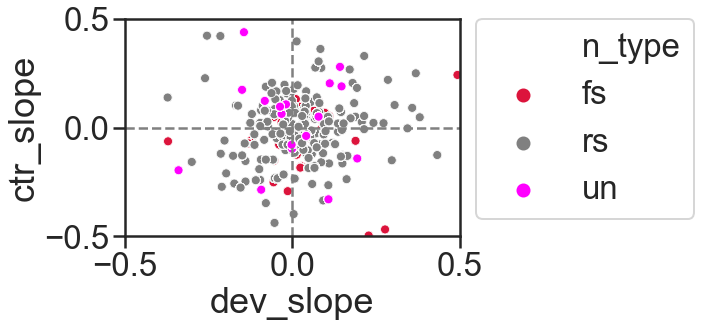

In [191]:
_inp = tmp_3km[(tmp_3km.r_groups == 2)
              & (tmp_3km.group == 'wt')
#               & (tmp_3km.ssa_hz > 0)
              ]
_inp = _inp.sort_values(by = ['n_type'])
g = sns.scatterplot(data = _inp, x = 'dev_slope', y= 'ctr_slope', hue = 'n_type',
#                   xlim = (-0.5, 0.5), ylim = (-0.5, 0.5), 
                palette = ['crimson', 'gray', 'magenta'],
              s = 80)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# g.set_axis_labels('ssa', 'dd')
# plt.axhline(y= 0.45, linestyle = '--')
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.axvline(x= 0, linestyle = '--')
plt.axhline(y= 0, linestyle = '--')

In [221]:
tmp_3km.head()

Hz  abs_times            cluster_id  \
322399   0.311342       2.99   30etPvLMopto2left-1   
307570  11.464520       2.70  127etPvLMopto1left-1   
307569  12.147364       2.69  127etPvLMopto1left-1   
307568  12.845967       2.68  127etPvLMopto1left-1   
307567  13.632262       2.67  127etPvLMopto1left-1   

                                                     cuid  depth         et  \
322399  30etPvLMopto2left-1etPvLMopto22sf-tuning-LMopt...   25.0  PvLMopto2   
307570  127etPvLMopto1left-1etPvLMopto12sf-tuning-LMop...  800.0  PvLMopto1   
307569  127etPvLMopto1left-1etPvLMopto12sf-tuning-LMop...  800.0  PvLMopto1   
307568  127etPvLMopto1left-1etPvLMopto12sf-tuning-LMop...  800.0  PvLMopto1   
307567  127etPvLMopto1left-1etPvLMopto12sf-tuning-LMop...  800.0  PvLMopto1   

        opto              paradigm  \
322399     1  sf-tuning-LMopto-g01   
307570     1  sf-tuning-LMopto-g01   
307569     1  sf-tuning-LMopto-g01   
307568     1  sf-tuning-LMopto-g01   
307567     1  sf-tuning-LMopto-g01   

                                                     path    side stim1  \
322399  U:\Data\pak6\OpenEphys\probe_64DB\PV_Ai32\vmmn...  left-1  ctr2   
307570  U:\Data\pak6\OpenEphys\probe_64DB\PV_Ai32\vmmn...  left-1  ctr2   
307569  U:\Data\pak6\OpenEphys\probe_64DB\PV_Ai32\vmmn...  left-1  ctr2   
307568  U:\Data\pak6\OpenEphys\probe_64DB\PV_Ai32\vmmn...  left-1  ctr2   
307567  U:\Data\pak6\OpenEphys\probe_64DB\PV_Ai32\vmmn...  left-1  ctr2   

        times    zscore        ztc  pref  ssa_hz  dd_hz  
322399   0.99 -2.186241  -2.330267  ctr1     NaN    NaN  
307570   0.70  0.336032  14.362097  ctr4     NaN    NaN  
307569   0.69  0.434332  15.507272  ctr4     NaN    NaN  
307568   0.68  0.534900  16.678874  ctr4     NaN    NaN  
307567   0.67  0.648092  17.997544  ctr4     NaN    NaN

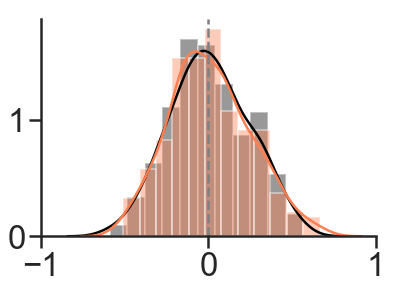

In [672]:
_inp = fig_inp[(fig_inp.r_groups == 3) ]
\
val = 'r2_ctr'
x = _inp[_inp.group == 'wt'][val].values
y = _inp[_inp.group == 'fx'][val].values
sns.distplot(x,  color = 'k')
sns.distplot(y,  color = 'coral')
plt.xlim(-1, 1)
plt.axvline(x = 0, linestyle = '--')
sns.despine()

In [671]:
print x.size
print y.size

196
247


In [275]:
sstat.ks_2samp(x, y)

Ks_2sampResult(statistic=0.13901503413935695, pvalue=0.004790515216261598)

In [ ]:
groups = {'479': 'wt', '480': 'fx', '481':'fx', '482': 'fx', '483': 'wt', '484': 'wt', '485':'wt', '486':'fx', 
          '013': 'wt', '014': 'fx', '016': 'fx', '017': 'wt', '018': 'fx', '019': 'wt', '020': 'wt', '022': 'fx',
         '023': 'wt', '024': 'fx', '025': 'fx', '026': 'fx', '027': 'fx', '028': 'fx', '029': 'wt', '030': 'fx', '031': 'fx', '032': 'fx', 
          '033': 'fx' , '034': 'fx', '035': 'wt', 'W00': 'wt', 'W01': 'wt',
 'W02': 'wt', 'W03': 'wt', 'W04': 'wt', 'W05':'wt'}

## Correlations

In [1201]:
target_units = df_odd[(df_odd.resp_sig == 'exc')
#               & (df_odd.tun_group == 'in_odd')
#                & (df_odd.pref >-1)
              ].cluster_id.unique()
_data = df_spikes[df_spikes.cluster_id.isin(target_units)]
df2 = _data[(_data.loc[:, 'times'] <= 120)] #sf-tuning
df2.loc[:, 'trial_n'] = df2.loc[:, 'times'] //1.0
df2.loc[:,'stim1'] = df2.loc[:, 'trial_n'].map(sf_tuning)
df2.loc[:, 'trial_spikes'] = df2.times - df2.trial_n
df2 = df2[(df2.trial_spikes > 0.35) & (df2.trial_spikes < 0.8)]

df3 = _data[(_data.loc[:, 'times'] > 120)   & ( _data.loc[:, 'times']<=320)] #sf-nov-odd
df3.times = df3.times - 120
df3.loc[:, 'trial_n'] = df3.loc[:, 'times'] //1.0
df3.loc[:,'stim1'] = df3.loc[:, 'trial_n'].map(oddball)
df3.loc[:,'trial_spikes'] = df3.times - df3.trial_n
df3 = df3[(df3.trial_spikes > 0.35) & (df3.trial_spikes < 0.8)]

In [481]:
# returns spike count for ach bin, should be used with groupby.apply
def get_trial_spikes_count(df, bins):
    binned_spike_count = df.groupby(pd.cut(df["trial_spikes"], bins)).times.count().values
    return binned_spike_count

In [482]:
import itertools
def noise_corr(df, d):
    correlations = []
    labels = []
    columns = df.columns.tolist()

    for col_a, col_b in itertools.combinations(columns, 2):
        a = [d[col_a], d[col_b]]
        a.sort(key=str.lower)
        rsc = df.loc[:, {col_a, col_b}].corr(method = 'pearson', min_periods = 15).values[0][1]
        correlations.append(rsc)
        labels.append(a[0] + '' + a[1])
#     corr_arr = np.array(correlations)
    out = pd.DataFrame({'cond':labels, 'rsc':[i for i in correlations]  })
#     out.columns = ['PCC', 'p-value']
    out = out.dropna()
    return out

In [483]:
import itertools
def signal_corr(df, d):
    correlations = []
    labels = []
    columns = df.columns.tolist()

    for col_a, col_b in itertools.combinations(columns, 2):
        a = [d[col_a], d[col_b]]
        a.sort(key=str.lower)
        rsc = df.loc[:, {col_a, col_b}].corr(method = 'pearson', min_periods = 20).values[0][1]
        correlations.append(rsc)
        labels.append(a[0] + '' + a[1])
#     corr_arr = np.array(correlations)
    out = pd.DataFrame({'cond':labels, 'r_sig':[i for i in correlations]  })
#     out.columns = ['PCC', 'p-value']
    out = out.dropna()
    return out

### Spike count correlations

In [1345]:
# x_ctr = np.arange(20)
# x_dev = np.arange(25)
# stim1 : 9 (dev), 3 (std), 
cond = 'layer'
ls = []
stim1 = 3
type_dict = dict(zip(df_odd.cluster_id, df_odd[cond].astype('str') ))
for rec in sorted(_data.path.unique())[:]:
#     f, ax = plt.subplots(1, 2, figsize = (12, 4))
    et = _data[_data.path == rec].et.iloc[0]
    group = groups[et]
    sp_df = df3[(df3.path == rec) & (df3.stim1 == stim1) ]
    # sp_df.times > 0.5 < 1
    inp_mat = sp_df.groupby(['cluster_id', 'trial_n']).trial_spikes.count().reset_index()
    inp_mat = inp_mat.pivot('trial_n', 'cluster_id', 'trial_spikes')
    # if stim1 is std, to account for number of trials
    if stim1 == 3:
        inp_mat = inp_mat[:20]
#     inp_mat.mean(axis = 1).plot()
#     plt.show()
    out = noise_corr(inp_mat, type_dict)
#     print inp_mat.shape, out.shape
    out['stim1'] = stim1
    out['et'] = et
    out['group'] = group
    out['path'] = rec
    ls.append(out)

df_rsc = pd.concat(ls)

In [1326]:
df_rsc.head()

cond       rsc  stim1   et group  \
0    untununtun  0.351710      3  013    wt   
1   in_odduntun  0.050869      3  013    wt   
2    untununtun  0.061411      3  013    wt   
3  out_odduntun  0.076417      3  013    wt   
4    untununtun -0.074182      3  013    wt   

                                                path  
0  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...  
1  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...  
2  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...  
3  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...  
4  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...

In [1246]:
# x_ctr = np.arange(20)
# x_dev = np.arange(25)
# stim1 df2: 0-5 (sd2 is ctr) 
cond = 'layer'
stim1 = 2
ls = []
type_dict = dict(zip(df_odd.cluster_id, df_odd[cond].astype('str') ))
for rec in sorted(_data.path.unique())[:]:
#     f, ax = plt.subplots(1, 2, figsize = (12, 4))
    et = _data[_data.path == rec].et.iloc[0]
    group = groups[et]
    sp_df = df2[(df2.path == rec) & (df2.stim1 == stim1) ]
    # sp_df.times > 0.5 < 1
    inp_mat = sp_df.groupby(['cluster_id', 'trial_n']).trial_spikes.count().reset_index()
    inp_mat = inp_mat.pivot('trial_n', 'cluster_id', 'trial_spikes')

    out = noise_corr(inp_mat, type_dict)
#     print inp_mat.shape, out.shape
    out['stim1'] = 'std'
    out['et'] = et
    out['group'] = group
    out['path'] = rec
    ls.append(out)

df_rsc = pd.concat(ls)

In [1247]:
df_rsc.head()

cond       rsc stim1   et group  \
1   in_odduntun  0.192304   std  013    wt   
2    untununtun  0.270849   std  013    wt   
3  out_odduntun -0.245764   std  013    wt   
5    untununtun -0.033737   std  013    wt   
6    untununtun -0.133649   std  013    wt   

                                                path  
1  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...  
2  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...  
3  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...  
5  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...  
6  U:\Data\pak6\OpenEphys\probe_64DB\FX\sf-nov-od...

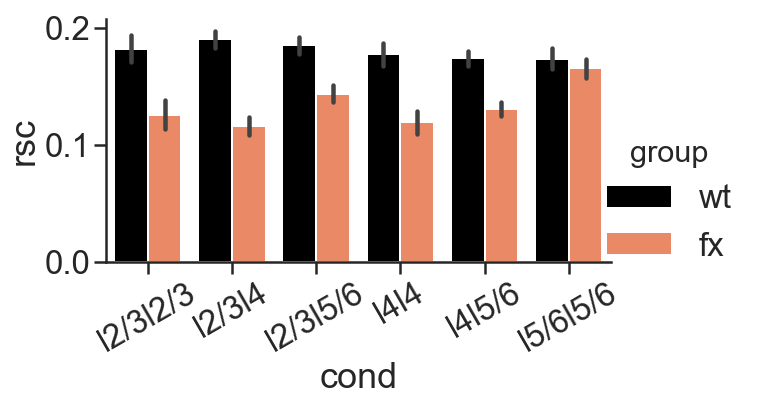

In [1348]:
fig_inp = df_rsc

# _data = _data[(_data.window == 0.1)| (_data.window == 0.2)]
fig_inp = fig_inp.sort_values(by=[ 'group', 'cond' ], ascending  = [False, True])

colors = ['k', 'coral', 'magenta']
fp = sns.catplot(y = 'rsc', x ='cond', data = fig_inp, hue = 'group',  
               palette=(colors), 
#                     col = 'layer', col_wrap = 2,
              height = 5, aspect=1.8, kind = 'bar',  ci = 68 )

plt.xticks(rotation = 30)
# plt.ylim(0, 0.2)
# plt.savefig('bar-rsc-layer-std.pdf')

In [1347]:
ls_cond = []
ls_p = []
for idx, r in enumerate(sorted(df_rsc['cond'].unique())):
    tmp = df_rsc[df_rsc['cond'] == r]
    print r
    x1 = tmp[ (tmp.group == 'wt')].rsc.dropna().values
    x2 = tmp[ (tmp.group == 'fx') ].rsc.dropna().values
    x1_mean, x1_sem =  np.mean(x1), sstat.sem(x1)
    x2_mean, x2_sem = np.mean(x2), sstat.sem(x2)

    x1_x2 = sstat.mannwhitneyu(x1, x2)
    data_tmp = pd.DataFrame({'cond': r,  'group': ['wt', 'fx'], 
    'mean': [x1_mean, x2_mean], 'sem': [x1_sem, x2_sem ], 
    'n_pairs': [len(x1), len(x2)], 'group': ['wt', 'fx'], 'cond': r, 'stim1': stim1,
    'p_val': x1_x2[1], 'u_stat': x1_x2[0] })
    ls_cond.append(data_tmp)
    ls_p.append(x1_x2[1])
    print '-------------------------'

adj = multipletests(np.array(ls_p), method='fdr_bh')
stat_table = pd.concat(ls_cond)
stat_table['adj_p'] = np.repeat(adj[1],2)
stat_table

l2/3l2/3
-------------------------
l2/3l4
-------------------------
l2/3l5/6
-------------------------
l4l4
-------------------------
l4l5/6
-------------------------
l5/6l5/6
-------------------------


cond group      mean  n_pairs         p_val       sem  stim1  \
0  l2/3l2/3    wt  0.182397      631  1.857268e-04  0.011272      3   
1  l2/3l2/3    fx  0.125622      546  1.857268e-04  0.012878      3   
0    l2/3l4    wt  0.190285     1504  6.071187e-11  0.007601      3   
1    l2/3l4    fx  0.116687     1500  6.071187e-11  0.007651      3   
0  l2/3l5/6    wt  0.185154     1736  4.771743e-06  0.006916      3   
1  l2/3l5/6    fx  0.144001     1645  4.771743e-06  0.007042      3   
0      l4l4    wt  0.178160      971  1.304121e-05  0.009461      3   
1      l4l4    fx  0.119800      912  1.304121e-05  0.009583      3   
0    l4l5/6    wt  0.174282     2045  7.003010e-07  0.006647      3   
1    l4l5/6    fx  0.130520     2180  7.003010e-07  0.006298      3   
0  l5/6l5/6    wt  0.173540     1144  1.468619e-01  0.008659      3   
1  l5/6l5/6    fx  0.165453     1247  1.468619e-01  0.008206      3   

      u_stat         adj_p  
0   151561.5  2.228721e-04  
1   151561.5  2.228721e-04  
0   974989.0  3.642712e-10  
1   974989.0  3.642712e-10  
0  1302259.5  9.543486e-06  
1  1302259.5  9.543486e-06  
0   393191.0  1.956182e-05  
1   393191.0  1.956182e-05  
0  2037871.0  2.100903e-06  
1  2037871.0  2.100903e-06  
0   695577.5  1.468619e-01  
1   695577.5  1.468619e-01

## Neural variability

In [1189]:
ls = []
for path in df2.path.unique():

    for stim in df2.stim1.unique():
        tmp = df2[(df2.path == path) & (df2.stim1 == stim)]
        group = groups[tmp.et.values[0]]
        et = tmp.et.values[0]
        inp_mat = tmp.groupby(['cluster_id']).trial_spikes.std().reset_index()

        inp_mat = inp_mat.assign(et = et, group = group, stim1= stim, path = path)
        ls.append(inp_mat)
df_var = pd.concat(ls)      

In [1192]:
colors_group

['k', 'coral']

In [1202]:
df2.cluster_id.unique().size

1156

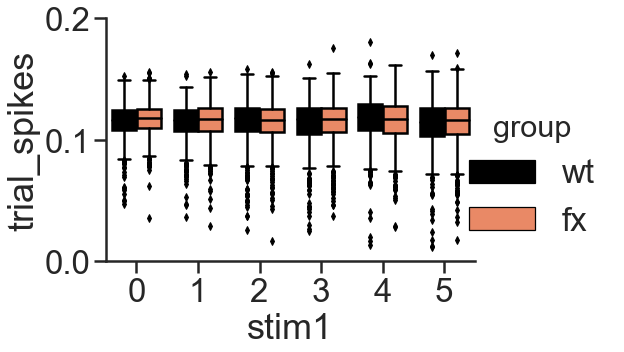

In [1214]:
fp = sns.catplot(y = 'trial_spikes', x = 'stim1', data = df_var, hue = 'group',  
               palette=(colors_group), 
#                     col = 'layer', col_wrap = 2,
              height = 5, aspect=1.5, kind = 'box',  ci = 68 )
plt.ylim(0, 0.2)
# plt.savefig('box_sd_spikes_sf_tuning.pdf')

array([0.1407315 , 0.1407315 , 0.15701424, 0.15701424, 0.2873154 ,
       0.2873154 , 0.32289907, 0.32289907, 0.15936803, 0.15936803,
       0.2873154 , 0.2873154 ])

In [1215]:
ls_cond = []
ls_p = []
cond = 'stim1'
val = 'trial_spikes'
for idx, r in enumerate(sorted(df_var[cond].unique())):
    tmp = df_var[df_var[cond] == r]
    print r
    x1 = tmp[ (tmp.group == 'wt')][val].dropna().values
    x2 = tmp[ (tmp.group == 'fx') ][val].dropna().values
    x1_mean, x1_sem =  np.mean(x1), sstat.sem(x1)
    x2_mean, x2_sem = np.mean(x2), sstat.sem(x2)

    x1_x2 = sstat.mannwhitneyu(x1, x2)
    ls_p.append(x1_x2[1])
    data_tmp = pd.DataFrame({cond: r,  'group': ['wt', 'fx'], 
    'mean': [x1_mean, x2_mean], 'sem': [x1_sem, x2_sem ], 
    'n_pairs': [len(x1), len(x2)], 'group': ['wt', 'fx'], 'stim1': r,
    'p_val': x1_x2[1], 'u_stat': x1_x2[0] })
    ls_cond.append(data_tmp)
    print '-------------------------'

adj = multipletests(np.array(ls_p), method='fdr_bh')
stat_table = pd.concat(ls_cond)
stat_table['adj_p'] = np.repeat(adj[1],2)
stat_table

0
-------------------------
1
-------------------------
2
-------------------------
3
-------------------------
4
-------------------------
5
-------------------------


group      mean  n_pairs     p_val       sem  stim1    u_stat     adj_p
0    wt  0.115239      594  0.023455  0.000592      0  155640.0  0.140732
1    fx  0.117219      562  0.023455  0.000588      0  155640.0  0.140732
0    wt  0.114104      594  0.052338  0.000635      1  157708.0  0.157014
1    fx  0.115851      562  0.052338  0.000649      1  157708.0  0.157014
0    wt  0.114471      594  0.239430  0.000765      2  162896.0  0.287315
1    fx  0.114422      562  0.239430  0.000765      2  162896.0  0.287315
0    wt  0.113631      594  0.322899  0.000793      3  164306.0  0.322899
1    fx  0.114734      562  0.322899  0.000792      3  164306.0  0.322899
0    wt  0.116900      594  0.079684  0.000792      4  158930.0  0.159368
1    fx  0.115676      562  0.079684  0.000808      4  158930.0  0.159368
0    wt  0.112902      593  0.225517  0.000825      5  162362.0  0.287315
1    fx  0.113651      562  0.225517  0.000867      5  162362.0  0.287315

## Locomotion analysis

In [472]:
import pickle
def natural_key(string_):
    """See http://www.codinghorror.com/blog/archives/001018.html"""
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]
def get_speed(df):
    out = np.gradient(df['position'])
    df['speed'] = out
    return df
groups = {'026': 'fx', '027': 'fx', '028': 'fx', '029': 'wt', '030': 'fx', '031': 'fx', '032': 'fx'  ,
          '033': 'fx', '034': 'fx', '035': 'wt', 'W00': 'wt', 'W01': 'wt',
 'W02': 'wt', 'W03': 'wt', 'W04': 'wt', 'W05':'wt'}

In [463]:
path = r"U:\Data\pak6\Pupilometry\FX\GN-nov-vmmn_pupil\set5_wheel_12-18-18"
# looking for all .continuous files in all subfolders
configfiles = [os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(path)
    for f in fnmatch.filter(files, 'speed*.pkl')]
lcm_file_list=sorted(configfiles, key=natural_key)
print lcm_file_list[:5]

['U:\\Data\\pak6\\Pupilometry\\FX\\GN-nov-vmmn_pupil\\set5_wheel_12-18-18\\026\\001_videos_2018-12-27_18-42-29\\speed_2018-12-27_18-42-29.pkl', 'U:\\Data\\pak6\\Pupilometry\\FX\\GN-nov-vmmn_pupil\\set5_wheel_12-18-18\\026\\002_videos_2018-12-27_19-04-03\\speed_2018-12-27_19-04-03.pkl', 'U:\\Data\\pak6\\Pupilometry\\FX\\GN-nov-vmmn_pupil\\set5_wheel_12-18-18\\027\\001_videos_2018-12-27_19-29-26\\speed_2018-12-27_19-29-25.pkl', 'U:\\Data\\pak6\\Pupilometry\\FX\\GN-nov-vmmn_pupil\\set5_wheel_12-18-18\\027\\002_videos_2018-12-27_19-51-13\\speed_2018-12-27_19-51-13.pkl', 'U:\\Data\\pak6\\Pupilometry\\FX\\GN-nov-vmmn_pupil\\set5_wheel_12-18-18\\028\\001_videos_2018-12-26_20-38-17\\speed_2018-12-26_20-38-17.pkl']


In [467]:
for fname in lcm_file_list[:]:
    rec = fname.split('\\')[-2].split('_')[0]
    et = fname.split('\\')[-3]
    print et, rec
    

026 001
026 002
027 001
027 002
028 001
028 002
029 001
029 002
030 001
030 002
031 001
031 002
032 001
032 002
033 001
033 002
034 001
034 002
035 001
W00 001
W00 002
W01 001
W01 002
W02 001
W02 002
W03 001
W03 002
W04 001
W04 002
W05 001
W05 002


In [468]:
ls_df2 = []
step = 0.025
for fname in lcm_file_list[:]:

    rec = fname.split('\\')[-2].split('_')[0]
    et = fname.split('\\')[-3]
    ls_df = []
    objs = []
    f = open(fname, 'rb')
    objs = []
    while 1:
        try:
            objs.append(pickle.load(f))
        except EOFError:
            break
    f.close()
    speed_ls = [pair[1].split(',')[:-1] for pair in enumerate(objs)]
    speed_ls2 = [[int(x) for x in speed_ls[pair[0]]] for pair in enumerate(speed_ls)]
    samples = min(len(x) for x in speed_ls2)
    speed_ls3 = [x[:samples] for x in speed_ls2]
    #     print len(speed_ls4)
    samples = np.arange(samples)
    for i, v in enumerate(speed_ls3):
        tmp = pd.DataFrame({  'et':et, 
            'trial':i, 'samples':samples, 'times': samples*step, 'position': np.array(v),  'fpath': str(fname), 
                'et': et, 'rec': rec, 'paradigm': 'gn_var'
                             })
        ls_df.append(tmp)
    df_tmp = pd.concat(ls_df)
    ls_df2.append(df_tmp)

df_speed = pd.concat(ls_df2)

In [471]:
df_speed = df_speed.groupby(['fpath', 'trial']).apply(get_speed)
df_speed['group'] = df_speed.et.map(groups)
df_speed['stim1'] = df_speed.trial.map(oddball)
df_speed.head()

et                                              fpath paradigm  position  \
0  026  U:\Data\pak6\Pupilometry\FX\GN-nov-vmmn_pupil\...   gn_var         1   
1  026  U:\Data\pak6\Pupilometry\FX\GN-nov-vmmn_pupil\...   gn_var         1   
2  026  U:\Data\pak6\Pupilometry\FX\GN-nov-vmmn_pupil\...   gn_var         0   
3  026  U:\Data\pak6\Pupilometry\FX\GN-nov-vmmn_pupil\...   gn_var         0   
4  026  U:\Data\pak6\Pupilometry\FX\GN-nov-vmmn_pupil\...   gn_var         0   

   rec  samples  times  trial  speed  
0  001        0  0.000      0    0.0  
1  001        1  0.025      0   -0.5  
2  001        2  0.050      0   -0.5  
3  001        3  0.075      0    0.0  
4  001        4  0.100      0    0.0

In [4]:
path = r"U:\Data_Analysis\pak6\Analysis of units\fx_gn-var_lcm_12-26-18.pkl"
df_speed = pd.read_pickle(path)
df_speed.head()

et                                              fpath paradigm  position  \
0  026  U:\Data\pak6\Pupilometry\FX\GN-nov-vmmn_pupil\...   gn_var         1   
1  026  U:\Data\pak6\Pupilometry\FX\GN-nov-vmmn_pupil\...   gn_var         1   
2  026  U:\Data\pak6\Pupilometry\FX\GN-nov-vmmn_pupil\...   gn_var         0   
3  026  U:\Data\pak6\Pupilometry\FX\GN-nov-vmmn_pupil\...   gn_var         0   
4  026  U:\Data\pak6\Pupilometry\FX\GN-nov-vmmn_pupil\...   gn_var         0   

   rec  samples  times  trial  speed group  stim1  
0  001        0  0.000      0    0.0    fx      3  
1  001        1  0.025      0   -0.5    fx      3  
2  001        2  0.050      0   -0.5    fx      3  
3  001        3  0.075      0    0.0    fx      3  
4  001        4  0.100      0    0.0    fx      3

In [5]:
df_speed.groupby(['group', 'et']).stim1.unique()

group  et 
fx     026    [3, 9]
       027    [3, 9]
       028    [3, 9]
       030    [3, 9]
       031    [3, 9]
       032    [3, 9]
       033    [3, 9]
       034    [3, 9]
wt     029    [3, 9]
       035    [3, 9]
       W00    [3, 9]
       W01    [3, 9]
       W02    [3, 9]
       W03    [3, 9]
       W04    [3, 9]
       W05    [3, 9]
Name: stim1, dtype: object

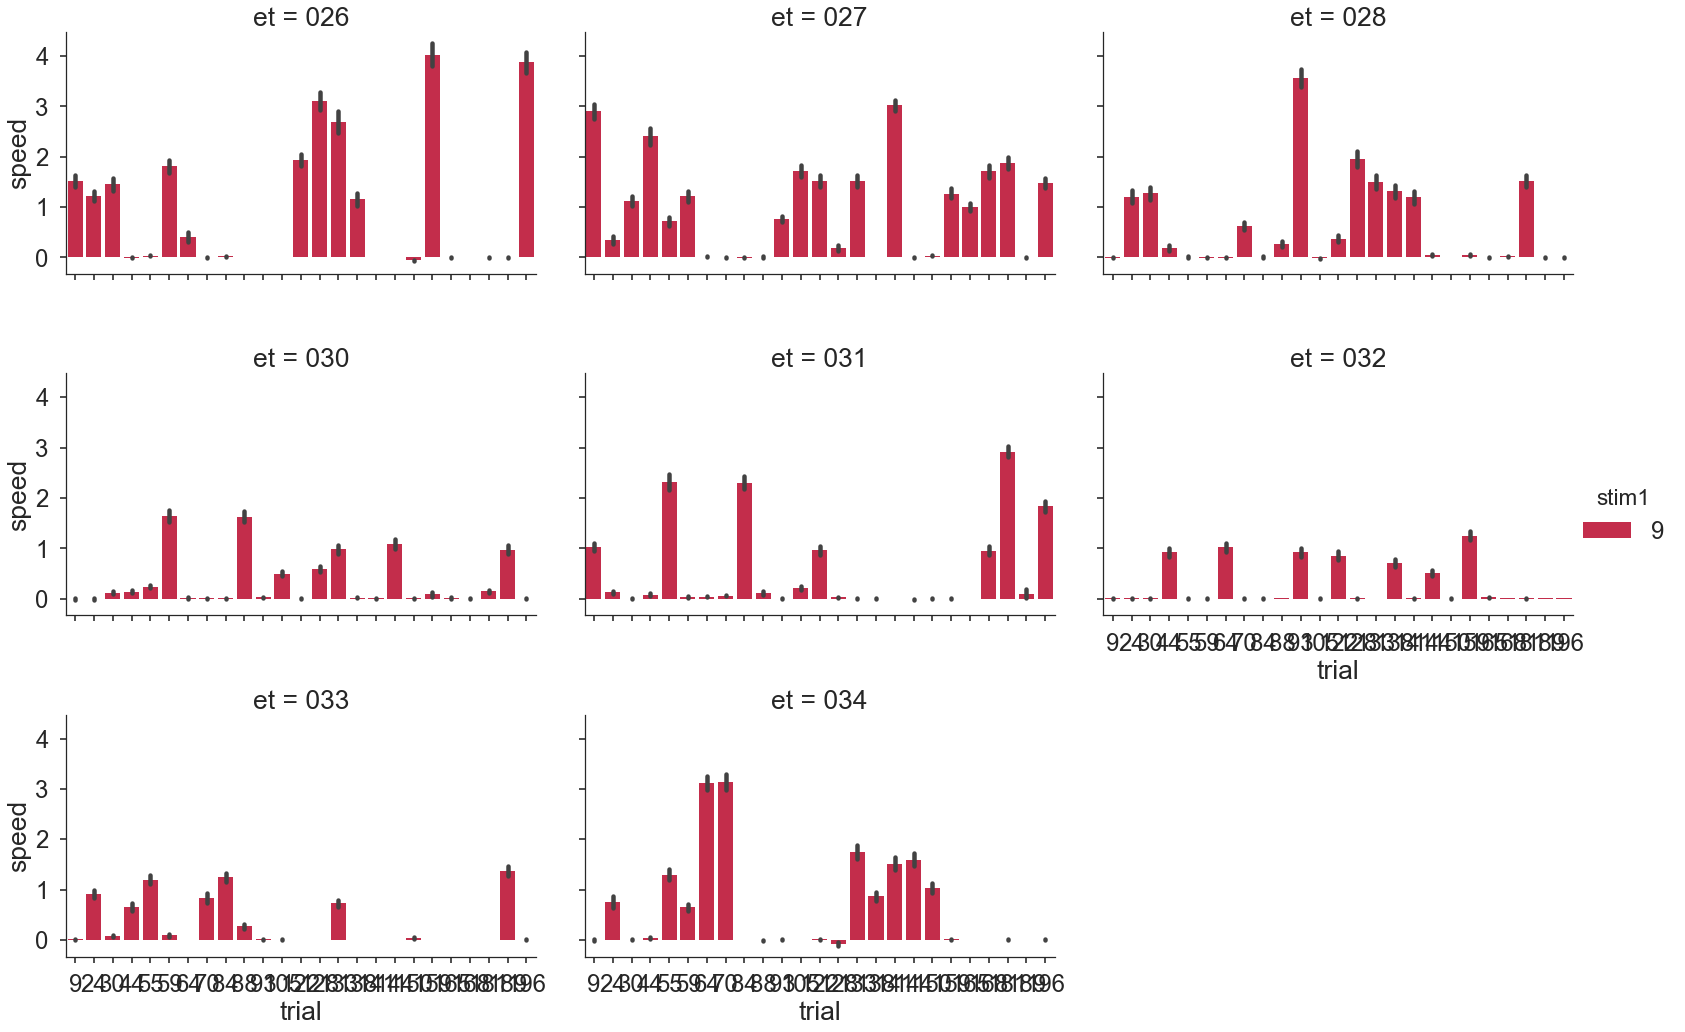

In [489]:
# f, ax = plt.subplots(figsize = (12, 8), facecolor = 'w')
data = df_speed
fig_inp = data[(data.times >0.3)]
fig_inp = fig_inp[(fig_inp.group == 'fx')
              & (fig_inp.stim1 == 9) 
#                 & (data.paradigm.str.contains('025')) 
#                 & (data.et == data.et.unique()[4])
               ]   
# fig_inp = fig_inp.groupby([ 'et', 'trial']).mean().reset_index(drop = True)
fig_inp = fig_inp.sort_values(by= ['trial'])
ax = sns.factorplot(x="trial", y="speed",   data= fig_inp,  kind = 'bar', ci = 68, hue = 'stim1',
                   palette = ['crimson', 'crimson'], col = 'et', col_wrap = 3,
#                    capsize = 0.02, saturation = 1,
                   size = 5, aspect=1.5 )

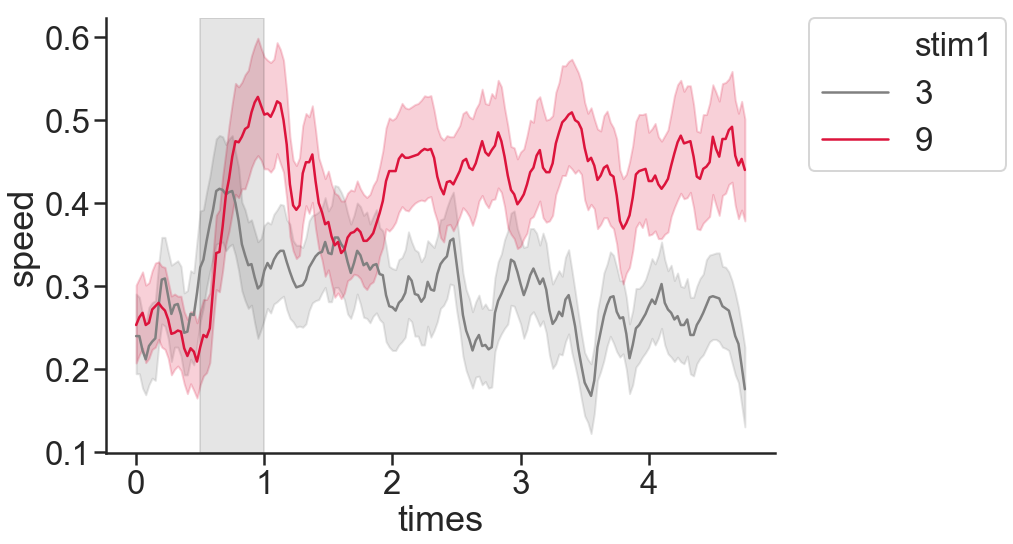

In [13]:
plt.figure(figsize=(12, 8), facecolor = 'w')

data = df_speed
_inp = data[(data.trial.isin(odd_idx[0])) 
              | (data.trial.isin(odd_idx[0]-1))
           ]
_inp = _inp[_inp.group == 'wt']
# _inp = _inp[_inp.lcm == 1]
# _inp = _inp[_inp.times < 1]
_inp = _inp.sort_values(by = 'stim1')
sns.lineplot(data = _inp.reset_index(), 
           x = 'times', y = 'speed', hue = 'stim1', estimator = np.nanmean, 
           ci = 68, palette = ['gray', 'crimson'],
#                size = 5, aspect = 1.5, kind = 'point',
            )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.xlim(1.2, 2)
# plt.axvspan(1, 1.5, alpha = 0.2, color='k')
plt.axvspan(0.5, 1, alpha = 0.1, color='k')
# plt.axvspan(1.5 ,2, color='green', alpha=0.25 )
sns.despine()
# plt.savefig('ppl_kic.pdf', transparent=True)

In [10]:
df_speed.stim1.unique()

array([3, 9], dtype=int64)